<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_ver10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

Using TensorFlow backend.


In [2]:
!rm -rf generator1.h5
!wget "https://github.com/rajagopalmotivate/try1/blob/master/generator1.h5"
!ls -al
##https://github.com/rajagopalmotivate/try1/raw/master/generator1.h5

--2018-12-05 08:52:35--  https://github.com/rajagopalmotivate/try1/blob/master/generator1.h5
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘generator1.h5’

generator1.h5           [ <=>                ]  54.11K  --.-KB/s    in 0.05s   

2018-12-05 08:52:36 (1.06 MB/s) - ‘generator1.h5’ saved [55407]

total 46964
drwxr-xr-x 1 root root     4096 Dec  5 08:52 .
drwxr-xr-x 1 root root     4096 Dec  5 05:42 ..
-rw-r--r-- 1 root root 22256168 Dec  5 08:34 combined1.h5
drwxr-xr-x 1 root root     4096 Dec  3 17:43 .config
-rw-r--r-- 1 root root 15348832 Dec  5 08:34 discriminator1.h5
-rw-r--r-- 1 root root    55407 Dec  5 08:52 generator1.h5
-rw-r--r-- 1 root root    55407 Dec  5 08:35 generator1.h5.1
-rw-r--r-- 1 root root 10336800 Dec  5 08:35 generator1.h5.2
drwxr-xr-x 2 root root     4096 Dec  3 17:43 sample_

In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
##X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0] 
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            else :
              fake_images = fake_images2
              fake_labels = fake_labels2
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW(averagemode = 1, loadpretrainedweights=false):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
  ##  models = [generator1, generator2]
    models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    

    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [17]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW()


    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

Number of examples:  60000
Number of Batches:  1875
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1875 [D loss: 0.837784, acc.: 46.88%] [G loss: 0.794680]


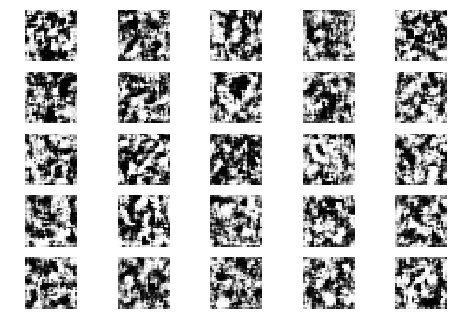

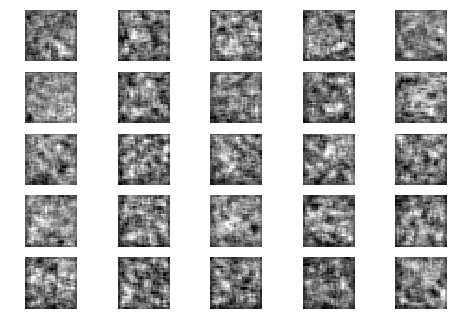

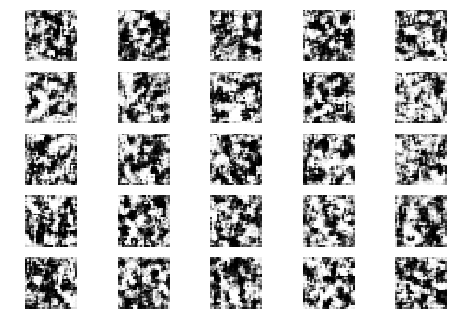

Epoch 0 Batch 1/1875 [D loss: 0.608131, acc.: 71.88%] [G loss: 0.773470]
Epoch 0 Batch 2/1875 [D loss: 0.551825, acc.: 65.62%] [G loss: 1.001573]
Epoch 0 Batch 3/1875 [D loss: 0.526462, acc.: 81.25%] [G loss: 1.237900]
Epoch 0 Batch 4/1875 [D loss: 0.395109, acc.: 81.25%] [G loss: 1.208774]
Epoch 0 Batch 5/1875 [D loss: 0.377492, acc.: 81.25%] [G loss: 1.111135]
Epoch 0 Batch 6/1875 [D loss: 0.414681, acc.: 81.25%] [G loss: 1.274039]
Epoch 0 Batch 7/1875 [D loss: 0.308012, acc.: 84.38%] [G loss: 1.520677]
Epoch 0 Batch 8/1875 [D loss: 0.382439, acc.: 90.62%] [G loss: 1.744724]
Epoch 0 Batch 9/1875 [D loss: 0.184126, acc.: 100.00%] [G loss: 1.922206]
Epoch 0 Batch 10/1875 [D loss: 0.341690, acc.: 90.62%] [G loss: 1.887522]
Epoch 0 Batch 11/1875 [D loss: 0.288147, acc.: 90.62%] [G loss: 1.644428]
Epoch 0 Batch 12/1875 [D loss: 0.187628, acc.: 96.88%] [G loss: 1.722708]
Epoch 0 Batch 13/1875 [D loss: 0.193184, acc.: 93.75%] [G loss: 2.047700]
Epoch 0 Batch 14/1875 [D loss: 0.204523, acc.:

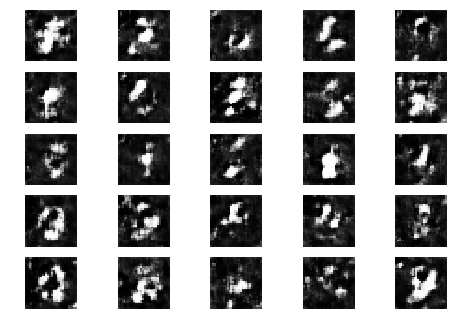

Epoch 0 Batch 101/1875 [D loss: 1.029483, acc.: 43.75%] [G loss: 2.177725]


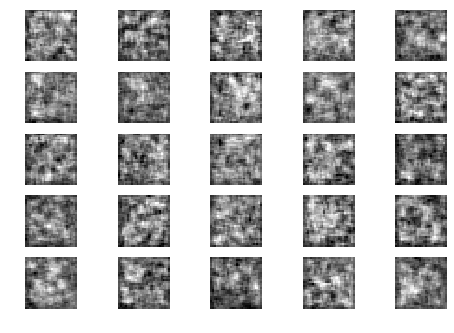

Epoch 0 Batch 102/1875 [D loss: 1.059084, acc.: 53.12%] [G loss: 1.936233]


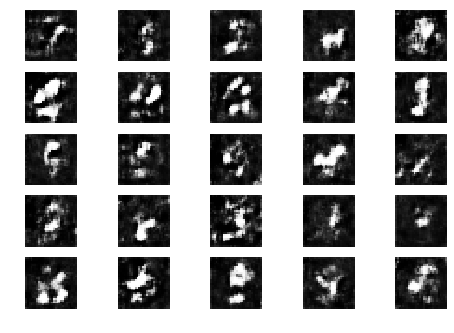

Epoch 0 Batch 103/1875 [D loss: 0.803657, acc.: 53.12%] [G loss: 1.661987]
Epoch 0 Batch 104/1875 [D loss: 0.821019, acc.: 56.25%] [G loss: 1.483954]
Epoch 0 Batch 105/1875 [D loss: 0.795847, acc.: 53.12%] [G loss: 1.132933]
Epoch 0 Batch 106/1875 [D loss: 0.848676, acc.: 59.38%] [G loss: 2.270413]
Epoch 0 Batch 107/1875 [D loss: 1.164380, acc.: 28.12%] [G loss: 1.651188]
Epoch 0 Batch 108/1875 [D loss: 0.886855, acc.: 43.75%] [G loss: 1.181461]
Epoch 0 Batch 109/1875 [D loss: 0.594512, acc.: 71.88%] [G loss: 2.187073]
Epoch 0 Batch 110/1875 [D loss: 1.227679, acc.: 40.62%] [G loss: 1.572927]
Epoch 0 Batch 111/1875 [D loss: 0.894488, acc.: 53.12%] [G loss: 1.508953]
Epoch 0 Batch 112/1875 [D loss: 0.791369, acc.: 59.38%] [G loss: 1.260075]
Epoch 0 Batch 113/1875 [D loss: 0.790119, acc.: 62.50%] [G loss: 1.710347]
Epoch 0 Batch 114/1875 [D loss: 1.188405, acc.: 34.38%] [G loss: 2.216866]
Epoch 0 Batch 115/1875 [D loss: 1.124119, acc.: 43.75%] [G loss: 1.731687]
Epoch 0 Batch 116/1875 [D

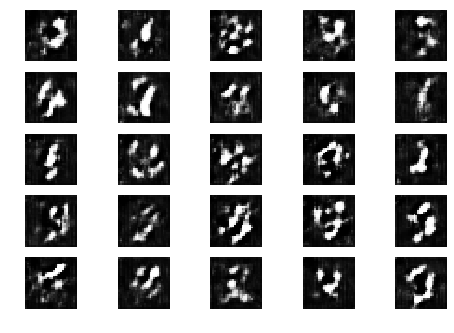

Epoch 0 Batch 201/1875 [D loss: 0.649159, acc.: 75.00%] [G loss: 1.511217]
Epoch 0 Batch 202/1875 [D loss: 0.977150, acc.: 46.88%] [G loss: 1.246295]


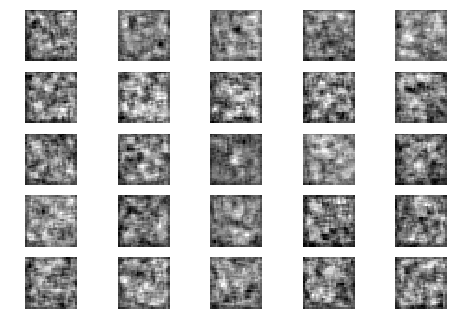

Epoch 0 Batch 203/1875 [D loss: 0.963022, acc.: 40.62%] [G loss: 1.249259]
Epoch 0 Batch 204/1875 [D loss: 0.770869, acc.: 59.38%] [G loss: 1.629985]


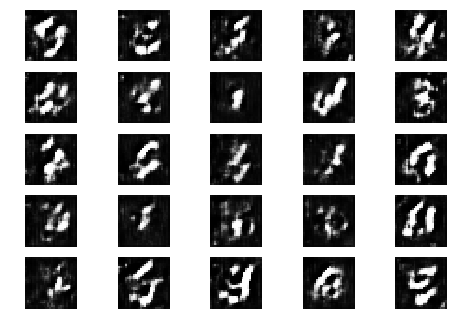

Epoch 0 Batch 205/1875 [D loss: 0.716259, acc.: 53.12%] [G loss: 1.473221]
Epoch 0 Batch 206/1875 [D loss: 0.636244, acc.: 62.50%] [G loss: 1.159064]
Epoch 0 Batch 207/1875 [D loss: 0.723533, acc.: 62.50%] [G loss: 0.799723]
Epoch 0 Batch 208/1875 [D loss: 0.715849, acc.: 62.50%] [G loss: 1.161223]
Epoch 0 Batch 209/1875 [D loss: 0.724254, acc.: 53.12%] [G loss: 1.364092]
Epoch 0 Batch 210/1875 [D loss: 0.601654, acc.: 65.62%] [G loss: 1.178614]
Epoch 0 Batch 211/1875 [D loss: 0.980742, acc.: 40.62%] [G loss: 0.872173]
Epoch 0 Batch 212/1875 [D loss: 1.117728, acc.: 37.50%] [G loss: 0.892758]
Epoch 0 Batch 213/1875 [D loss: 0.631644, acc.: 65.62%] [G loss: 1.094475]
Epoch 0 Batch 214/1875 [D loss: 0.736160, acc.: 62.50%] [G loss: 1.165644]
Epoch 0 Batch 215/1875 [D loss: 0.803454, acc.: 62.50%] [G loss: 0.768455]
Epoch 0 Batch 216/1875 [D loss: 0.954583, acc.: 53.12%] [G loss: 0.998552]
Epoch 0 Batch 217/1875 [D loss: 0.604301, acc.: 62.50%] [G loss: 1.274241]
Epoch 0 Batch 218/1875 [D

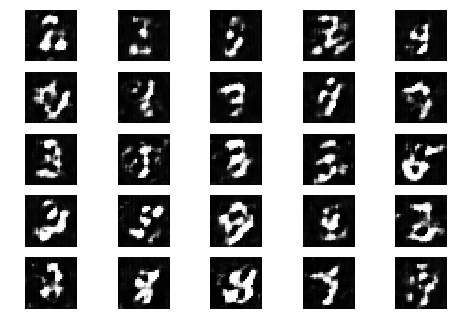

Epoch 0 Batch 301/1875 [D loss: 0.719732, acc.: 56.25%] [G loss: 0.979365]
Epoch 0 Batch 302/1875 [D loss: 1.040341, acc.: 34.38%] [G loss: 0.861788]
Epoch 0 Batch 303/1875 [D loss: 0.937974, acc.: 46.88%] [G loss: 1.343866]


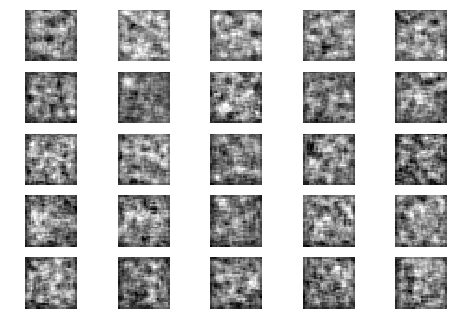

Epoch 0 Batch 304/1875 [D loss: 0.523663, acc.: 68.75%] [G loss: 1.305162]
Epoch 0 Batch 305/1875 [D loss: 0.869114, acc.: 46.88%] [G loss: 0.879309]
Epoch 0 Batch 306/1875 [D loss: 0.639209, acc.: 59.38%] [G loss: 1.191575]


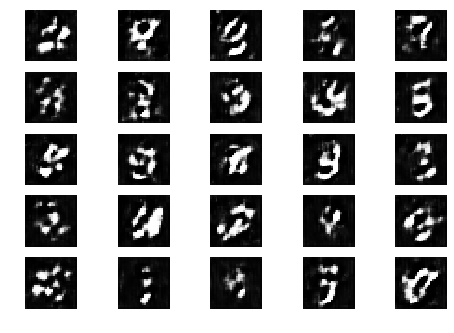

Epoch 0 Batch 307/1875 [D loss: 0.804402, acc.: 43.75%] [G loss: 0.878864]
Epoch 0 Batch 308/1875 [D loss: 0.628544, acc.: 62.50%] [G loss: 1.204114]
Epoch 0 Batch 309/1875 [D loss: 0.934119, acc.: 46.88%] [G loss: 1.233768]
Epoch 0 Batch 310/1875 [D loss: 0.658463, acc.: 59.38%] [G loss: 1.070613]
Epoch 0 Batch 311/1875 [D loss: 0.839327, acc.: 53.12%] [G loss: 1.232321]
Epoch 0 Batch 312/1875 [D loss: 0.624998, acc.: 62.50%] [G loss: 1.040753]
Epoch 0 Batch 313/1875 [D loss: 0.877700, acc.: 40.62%] [G loss: 0.962695]
Epoch 0 Batch 314/1875 [D loss: 0.798218, acc.: 56.25%] [G loss: 1.103999]
Epoch 0 Batch 315/1875 [D loss: 0.638939, acc.: 68.75%] [G loss: 0.986743]
Epoch 0 Batch 316/1875 [D loss: 0.847721, acc.: 53.12%] [G loss: 0.960092]
Epoch 0 Batch 317/1875 [D loss: 0.797880, acc.: 59.38%] [G loss: 1.021260]
Epoch 0 Batch 318/1875 [D loss: 0.571598, acc.: 65.62%] [G loss: 1.038365]
Epoch 0 Batch 319/1875 [D loss: 0.896063, acc.: 46.88%] [G loss: 1.143235]
Epoch 0 Batch 320/1875 [D

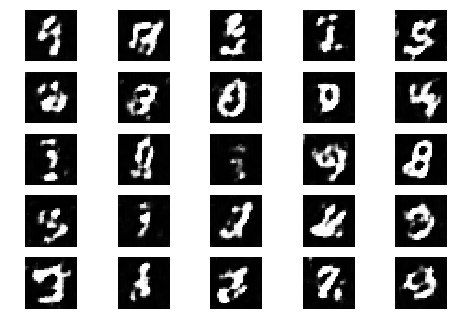

Epoch 0 Batch 401/1875 [D loss: 0.867224, acc.: 50.00%] [G loss: 1.116539]
Epoch 0 Batch 402/1875 [D loss: 0.686458, acc.: 59.38%] [G loss: 1.231292]
Epoch 0 Batch 403/1875 [D loss: 0.744524, acc.: 59.38%] [G loss: 1.089287]
Epoch 0 Batch 404/1875 [D loss: 0.627720, acc.: 65.62%] [G loss: 1.040777]


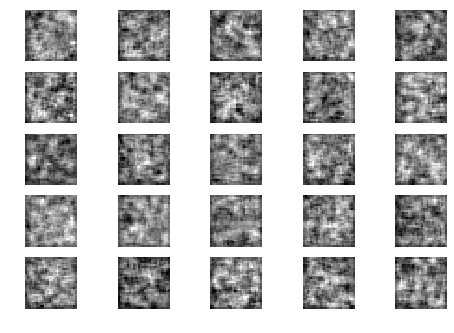

Epoch 0 Batch 405/1875 [D loss: 0.743676, acc.: 56.25%] [G loss: 1.092060]
Epoch 0 Batch 406/1875 [D loss: 0.862795, acc.: 43.75%] [G loss: 1.182260]
Epoch 0 Batch 407/1875 [D loss: 0.615612, acc.: 65.62%] [G loss: 1.140609]
Epoch 0 Batch 408/1875 [D loss: 0.815963, acc.: 65.62%] [G loss: 1.042959]


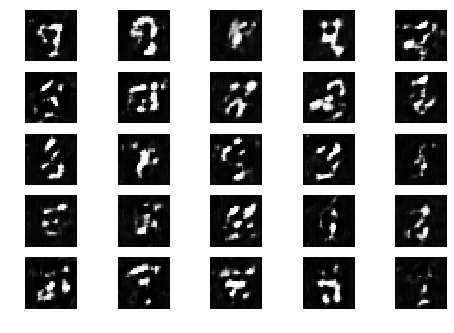

Epoch 0 Batch 409/1875 [D loss: 0.704906, acc.: 56.25%] [G loss: 1.010186]
Epoch 0 Batch 410/1875 [D loss: 0.721153, acc.: 56.25%] [G loss: 1.117758]
Epoch 0 Batch 411/1875 [D loss: 0.647190, acc.: 65.62%] [G loss: 1.209655]
Epoch 0 Batch 412/1875 [D loss: 0.669748, acc.: 59.38%] [G loss: 1.059360]
Epoch 0 Batch 413/1875 [D loss: 0.768069, acc.: 46.88%] [G loss: 1.219110]
Epoch 0 Batch 414/1875 [D loss: 0.728883, acc.: 46.88%] [G loss: 1.208607]
Epoch 0 Batch 415/1875 [D loss: 0.612019, acc.: 59.38%] [G loss: 1.059961]
Epoch 0 Batch 416/1875 [D loss: 0.662802, acc.: 56.25%] [G loss: 1.250553]
Epoch 0 Batch 417/1875 [D loss: 0.811771, acc.: 46.88%] [G loss: 1.094174]
Epoch 0 Batch 418/1875 [D loss: 0.722464, acc.: 65.62%] [G loss: 1.099054]
Epoch 0 Batch 419/1875 [D loss: 0.687407, acc.: 59.38%] [G loss: 1.019126]
Epoch 0 Batch 420/1875 [D loss: 0.681243, acc.: 62.50%] [G loss: 1.170907]
Epoch 0 Batch 421/1875 [D loss: 0.542699, acc.: 78.12%] [G loss: 1.268745]
Epoch 0 Batch 422/1875 [D

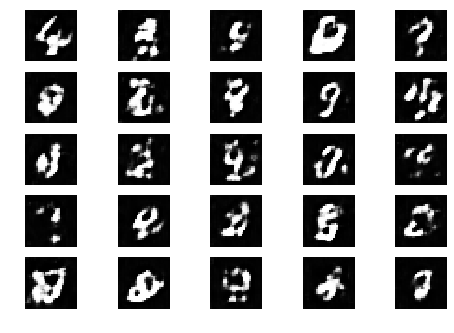

Epoch 0 Batch 501/1875 [D loss: 0.710016, acc.: 65.62%] [G loss: 1.284277]
Epoch 0 Batch 502/1875 [D loss: 0.632643, acc.: 56.25%] [G loss: 1.283492]
Epoch 0 Batch 503/1875 [D loss: 0.736616, acc.: 56.25%] [G loss: 1.042296]
Epoch 0 Batch 504/1875 [D loss: 0.883329, acc.: 43.75%] [G loss: 1.102940]
Epoch 0 Batch 505/1875 [D loss: 0.734204, acc.: 50.00%] [G loss: 1.115487]


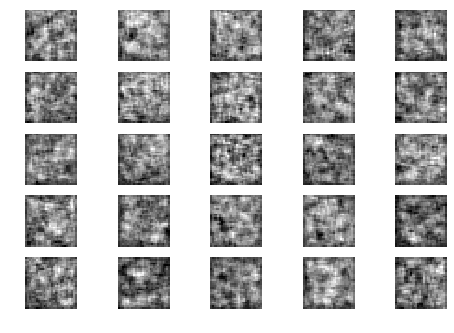

Epoch 0 Batch 506/1875 [D loss: 0.764459, acc.: 56.25%] [G loss: 0.920667]
Epoch 0 Batch 507/1875 [D loss: 0.699041, acc.: 53.12%] [G loss: 0.896520]
Epoch 0 Batch 508/1875 [D loss: 0.792281, acc.: 43.75%] [G loss: 0.976472]
Epoch 0 Batch 509/1875 [D loss: 0.707174, acc.: 62.50%] [G loss: 1.179668]
Epoch 0 Batch 510/1875 [D loss: 0.745079, acc.: 50.00%] [G loss: 1.253466]


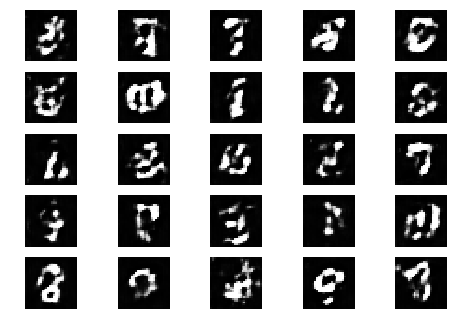

Epoch 0 Batch 511/1875 [D loss: 0.674979, acc.: 59.38%] [G loss: 1.145989]
Epoch 0 Batch 512/1875 [D loss: 0.717733, acc.: 62.50%] [G loss: 1.076334]
Epoch 0 Batch 513/1875 [D loss: 0.675190, acc.: 59.38%] [G loss: 1.156237]
Epoch 0 Batch 514/1875 [D loss: 0.638930, acc.: 65.62%] [G loss: 1.085366]
Epoch 0 Batch 515/1875 [D loss: 0.700021, acc.: 56.25%] [G loss: 1.182661]
Epoch 0 Batch 516/1875 [D loss: 0.783229, acc.: 37.50%] [G loss: 1.294204]
Epoch 0 Batch 517/1875 [D loss: 0.716737, acc.: 50.00%] [G loss: 1.189421]
Epoch 0 Batch 518/1875 [D loss: 0.622989, acc.: 59.38%] [G loss: 1.367638]
Epoch 0 Batch 519/1875 [D loss: 0.729154, acc.: 53.12%] [G loss: 0.985031]
Epoch 0 Batch 520/1875 [D loss: 0.789766, acc.: 43.75%] [G loss: 1.109470]
Epoch 0 Batch 521/1875 [D loss: 0.681328, acc.: 59.38%] [G loss: 1.316075]
Epoch 0 Batch 522/1875 [D loss: 0.881457, acc.: 37.50%] [G loss: 1.226753]
Epoch 0 Batch 523/1875 [D loss: 0.746043, acc.: 56.25%] [G loss: 1.129390]
Epoch 0 Batch 524/1875 [D

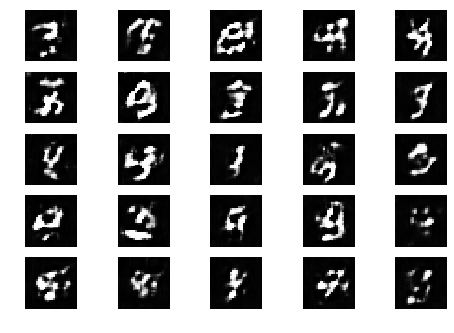

Epoch 0 Batch 601/1875 [D loss: 0.701302, acc.: 50.00%] [G loss: 1.007222]
Epoch 0 Batch 602/1875 [D loss: 0.680628, acc.: 68.75%] [G loss: 1.296365]
Epoch 0 Batch 603/1875 [D loss: 0.731542, acc.: 56.25%] [G loss: 1.209947]
Epoch 0 Batch 604/1875 [D loss: 0.877764, acc.: 25.00%] [G loss: 1.220867]
Epoch 0 Batch 605/1875 [D loss: 0.725641, acc.: 46.88%] [G loss: 1.027814]
Epoch 0 Batch 606/1875 [D loss: 0.667445, acc.: 65.62%] [G loss: 1.011954]


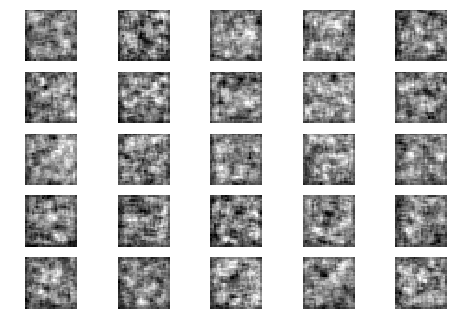

Epoch 0 Batch 607/1875 [D loss: 0.750355, acc.: 40.62%] [G loss: 1.112194]
Epoch 0 Batch 608/1875 [D loss: 0.672797, acc.: 62.50%] [G loss: 1.077493]
Epoch 0 Batch 609/1875 [D loss: 0.530745, acc.: 75.00%] [G loss: 1.196537]
Epoch 0 Batch 610/1875 [D loss: 0.713352, acc.: 59.38%] [G loss: 1.195784]
Epoch 0 Batch 611/1875 [D loss: 0.660515, acc.: 65.62%] [G loss: 1.203820]
Epoch 0 Batch 612/1875 [D loss: 0.702607, acc.: 53.12%] [G loss: 1.307762]


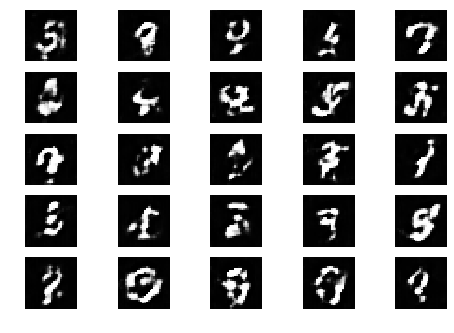

Epoch 0 Batch 613/1875 [D loss: 0.716389, acc.: 62.50%] [G loss: 1.129766]
Epoch 0 Batch 614/1875 [D loss: 0.697002, acc.: 59.38%] [G loss: 1.049281]
Epoch 0 Batch 615/1875 [D loss: 0.750935, acc.: 59.38%] [G loss: 0.943797]
Epoch 0 Batch 616/1875 [D loss: 0.566521, acc.: 65.62%] [G loss: 1.148775]
Epoch 0 Batch 617/1875 [D loss: 0.656899, acc.: 59.38%] [G loss: 1.201457]
Epoch 0 Batch 618/1875 [D loss: 0.558079, acc.: 65.62%] [G loss: 1.371705]
Epoch 0 Batch 619/1875 [D loss: 0.695053, acc.: 62.50%] [G loss: 1.196841]
Epoch 0 Batch 620/1875 [D loss: 0.670496, acc.: 65.62%] [G loss: 1.187276]
Epoch 0 Batch 621/1875 [D loss: 0.675583, acc.: 71.88%] [G loss: 1.109626]
Epoch 0 Batch 622/1875 [D loss: 0.753807, acc.: 56.25%] [G loss: 1.346602]
Epoch 0 Batch 623/1875 [D loss: 0.717113, acc.: 53.12%] [G loss: 1.488394]
Epoch 0 Batch 624/1875 [D loss: 0.589112, acc.: 71.88%] [G loss: 1.609030]
Epoch 0 Batch 625/1875 [D loss: 0.770222, acc.: 50.00%] [G loss: 1.417410]
Epoch 0 Batch 626/1875 [D

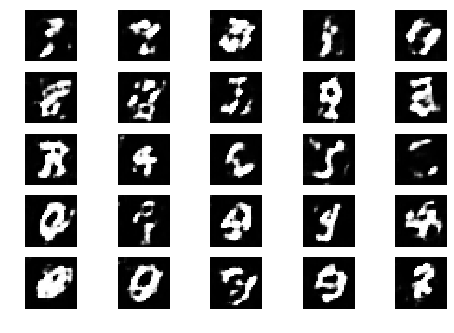

Epoch 0 Batch 701/1875 [D loss: 0.686425, acc.: 65.62%] [G loss: 1.027340]
Epoch 0 Batch 702/1875 [D loss: 0.883079, acc.: 46.88%] [G loss: 0.772956]
Epoch 0 Batch 703/1875 [D loss: 0.634811, acc.: 65.62%] [G loss: 1.047716]
Epoch 0 Batch 704/1875 [D loss: 0.609424, acc.: 68.75%] [G loss: 1.144354]
Epoch 0 Batch 705/1875 [D loss: 0.598545, acc.: 59.38%] [G loss: 1.142274]
Epoch 0 Batch 706/1875 [D loss: 0.760729, acc.: 50.00%] [G loss: 1.374283]
Epoch 0 Batch 707/1875 [D loss: 0.909211, acc.: 34.38%] [G loss: 1.011817]


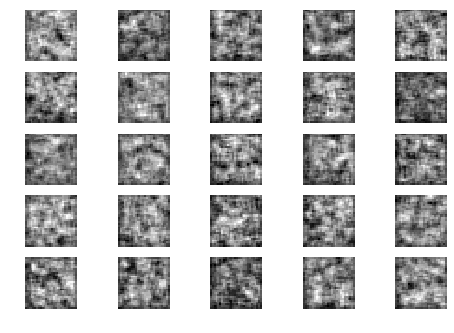

Epoch 0 Batch 708/1875 [D loss: 0.629480, acc.: 59.38%] [G loss: 1.173153]
Epoch 0 Batch 709/1875 [D loss: 0.588409, acc.: 68.75%] [G loss: 0.945259]
Epoch 0 Batch 710/1875 [D loss: 0.556867, acc.: 75.00%] [G loss: 1.472097]
Epoch 0 Batch 711/1875 [D loss: 0.747324, acc.: 56.25%] [G loss: 1.113148]
Epoch 0 Batch 712/1875 [D loss: 0.721440, acc.: 46.88%] [G loss: 1.072452]
Epoch 0 Batch 713/1875 [D loss: 0.902861, acc.: 28.12%] [G loss: 1.257939]
Epoch 0 Batch 714/1875 [D loss: 0.751988, acc.: 56.25%] [G loss: 1.124473]


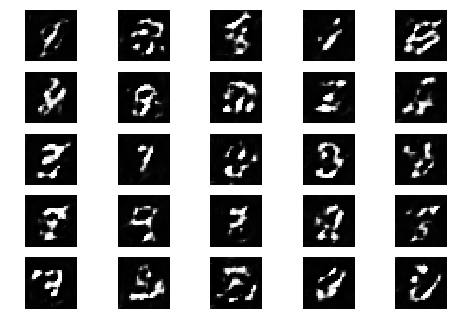

Epoch 0 Batch 715/1875 [D loss: 0.597715, acc.: 65.62%] [G loss: 1.225593]
Epoch 0 Batch 716/1875 [D loss: 0.581468, acc.: 71.88%] [G loss: 0.891359]
Epoch 0 Batch 717/1875 [D loss: 0.617849, acc.: 56.25%] [G loss: 0.987806]
Epoch 0 Batch 718/1875 [D loss: 0.798576, acc.: 50.00%] [G loss: 1.236062]
Epoch 0 Batch 719/1875 [D loss: 0.541874, acc.: 68.75%] [G loss: 1.193071]
Epoch 0 Batch 720/1875 [D loss: 0.693288, acc.: 59.38%] [G loss: 0.984727]
Epoch 0 Batch 721/1875 [D loss: 0.764537, acc.: 46.88%] [G loss: 1.082395]
Epoch 0 Batch 722/1875 [D loss: 0.569069, acc.: 68.75%] [G loss: 1.152374]
Epoch 0 Batch 723/1875 [D loss: 0.632441, acc.: 59.38%] [G loss: 1.310557]
Epoch 0 Batch 724/1875 [D loss: 0.630474, acc.: 65.62%] [G loss: 1.129650]
Epoch 0 Batch 725/1875 [D loss: 0.740863, acc.: 56.25%] [G loss: 1.126953]
Epoch 0 Batch 726/1875 [D loss: 0.794147, acc.: 53.12%] [G loss: 1.272897]
Epoch 0 Batch 727/1875 [D loss: 0.484112, acc.: 75.00%] [G loss: 1.142418]
Epoch 0 Batch 728/1875 [D

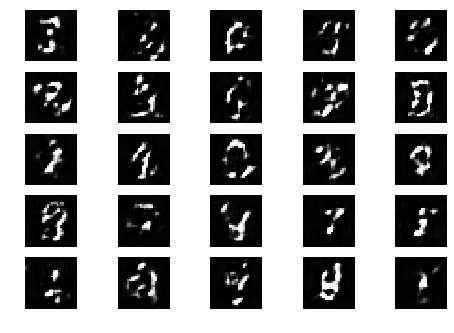

Epoch 0 Batch 801/1875 [D loss: 0.523522, acc.: 71.88%] [G loss: 1.275516]
Epoch 0 Batch 802/1875 [D loss: 0.633980, acc.: 59.38%] [G loss: 1.109959]
Epoch 0 Batch 803/1875 [D loss: 0.804679, acc.: 46.88%] [G loss: 0.884027]
Epoch 0 Batch 804/1875 [D loss: 0.640434, acc.: 59.38%] [G loss: 0.979368]
Epoch 0 Batch 805/1875 [D loss: 0.616472, acc.: 71.88%] [G loss: 1.016707]
Epoch 0 Batch 806/1875 [D loss: 0.600176, acc.: 56.25%] [G loss: 1.036835]
Epoch 0 Batch 807/1875 [D loss: 0.622078, acc.: 65.62%] [G loss: 1.201590]
Epoch 0 Batch 808/1875 [D loss: 0.770039, acc.: 37.50%] [G loss: 1.208499]


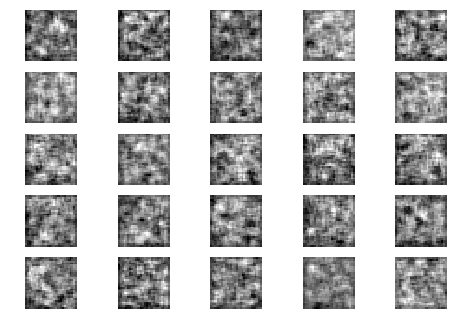

Epoch 0 Batch 809/1875 [D loss: 0.645534, acc.: 65.62%] [G loss: 1.033027]
Epoch 0 Batch 810/1875 [D loss: 0.560565, acc.: 68.75%] [G loss: 1.168686]
Epoch 0 Batch 811/1875 [D loss: 0.574198, acc.: 71.88%] [G loss: 1.347328]
Epoch 0 Batch 812/1875 [D loss: 0.519727, acc.: 78.12%] [G loss: 1.192693]
Epoch 0 Batch 813/1875 [D loss: 0.619407, acc.: 68.75%] [G loss: 1.416572]
Epoch 0 Batch 814/1875 [D loss: 0.650098, acc.: 59.38%] [G loss: 1.160753]
Epoch 0 Batch 815/1875 [D loss: 0.643466, acc.: 62.50%] [G loss: 0.998901]
Epoch 0 Batch 816/1875 [D loss: 0.783296, acc.: 40.62%] [G loss: 1.143989]


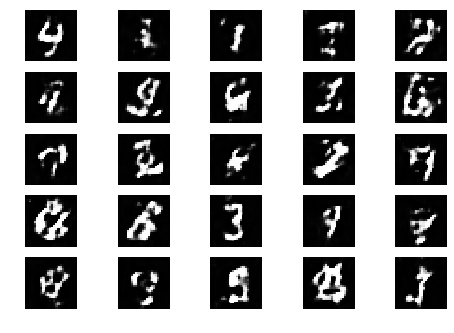

Epoch 0 Batch 817/1875 [D loss: 0.678395, acc.: 59.38%] [G loss: 1.222574]
Epoch 0 Batch 818/1875 [D loss: 0.602119, acc.: 65.62%] [G loss: 0.983570]
Epoch 0 Batch 819/1875 [D loss: 0.698287, acc.: 59.38%] [G loss: 1.020473]
Epoch 0 Batch 820/1875 [D loss: 0.675475, acc.: 62.50%] [G loss: 0.965691]
Epoch 0 Batch 821/1875 [D loss: 0.680224, acc.: 56.25%] [G loss: 1.003457]
Epoch 0 Batch 822/1875 [D loss: 0.619440, acc.: 71.88%] [G loss: 0.937267]
Epoch 0 Batch 823/1875 [D loss: 0.610388, acc.: 68.75%] [G loss: 1.048508]
Epoch 0 Batch 824/1875 [D loss: 0.714573, acc.: 53.12%] [G loss: 1.014310]
Epoch 0 Batch 825/1875 [D loss: 0.661756, acc.: 65.62%] [G loss: 0.972036]
Epoch 0 Batch 826/1875 [D loss: 0.934607, acc.: 34.38%] [G loss: 1.035343]
Epoch 0 Batch 827/1875 [D loss: 0.739759, acc.: 43.75%] [G loss: 1.098554]
Epoch 0 Batch 828/1875 [D loss: 0.816982, acc.: 43.75%] [G loss: 1.128801]
Epoch 0 Batch 829/1875 [D loss: 0.641837, acc.: 62.50%] [G loss: 1.244231]
Epoch 0 Batch 830/1875 [D

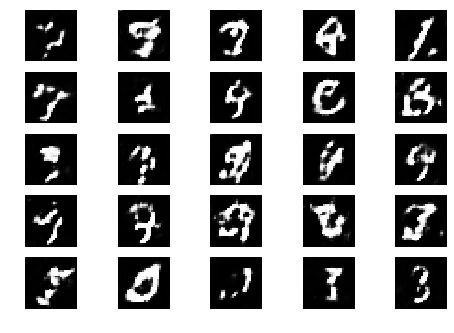

Epoch 0 Batch 901/1875 [D loss: 0.597369, acc.: 59.38%] [G loss: 1.140360]
Epoch 0 Batch 902/1875 [D loss: 0.725290, acc.: 50.00%] [G loss: 1.154020]
Epoch 0 Batch 903/1875 [D loss: 0.686466, acc.: 56.25%] [G loss: 1.202063]
Epoch 0 Batch 904/1875 [D loss: 0.638767, acc.: 68.75%] [G loss: 1.058623]
Epoch 0 Batch 905/1875 [D loss: 0.576553, acc.: 75.00%] [G loss: 1.043826]
Epoch 0 Batch 906/1875 [D loss: 0.718360, acc.: 56.25%] [G loss: 0.949885]
Epoch 0 Batch 907/1875 [D loss: 0.640970, acc.: 59.38%] [G loss: 1.046937]
Epoch 0 Batch 908/1875 [D loss: 0.644932, acc.: 65.62%] [G loss: 1.384515]
Epoch 0 Batch 909/1875 [D loss: 0.622446, acc.: 68.75%] [G loss: 1.191795]


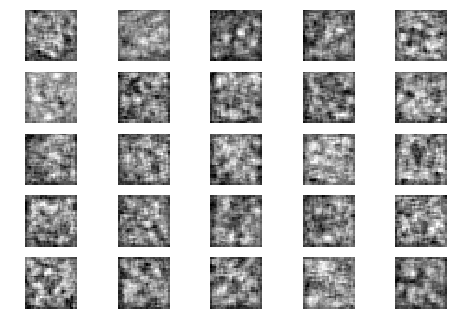

Epoch 0 Batch 910/1875 [D loss: 0.619615, acc.: 59.38%] [G loss: 0.978443]
Epoch 0 Batch 911/1875 [D loss: 0.697724, acc.: 65.62%] [G loss: 1.224739]
Epoch 0 Batch 912/1875 [D loss: 0.692924, acc.: 50.00%] [G loss: 1.094150]
Epoch 0 Batch 913/1875 [D loss: 0.528714, acc.: 78.12%] [G loss: 1.304678]
Epoch 0 Batch 914/1875 [D loss: 0.593395, acc.: 62.50%] [G loss: 1.182333]
Epoch 0 Batch 915/1875 [D loss: 0.674225, acc.: 53.12%] [G loss: 1.382145]
Epoch 0 Batch 916/1875 [D loss: 0.434663, acc.: 90.62%] [G loss: 1.285144]
Epoch 0 Batch 917/1875 [D loss: 0.755027, acc.: 56.25%] [G loss: 1.095760]
Epoch 0 Batch 918/1875 [D loss: 0.608158, acc.: 59.38%] [G loss: 1.347573]


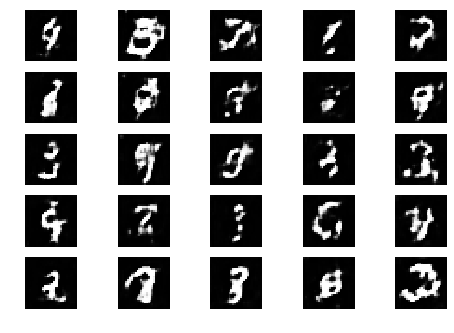

Epoch 0 Batch 919/1875 [D loss: 0.711738, acc.: 56.25%] [G loss: 1.012134]
Epoch 0 Batch 920/1875 [D loss: 0.790931, acc.: 40.62%] [G loss: 1.123070]
Epoch 0 Batch 921/1875 [D loss: 0.627189, acc.: 59.38%] [G loss: 1.107083]
Epoch 0 Batch 922/1875 [D loss: 0.726786, acc.: 59.38%] [G loss: 1.223663]
Epoch 0 Batch 923/1875 [D loss: 0.789563, acc.: 40.62%] [G loss: 1.143409]
Epoch 0 Batch 924/1875 [D loss: 0.672970, acc.: 59.38%] [G loss: 1.095094]
Epoch 0 Batch 925/1875 [D loss: 0.691319, acc.: 56.25%] [G loss: 1.100789]
Epoch 0 Batch 926/1875 [D loss: 0.769846, acc.: 56.25%] [G loss: 0.902312]
Epoch 0 Batch 927/1875 [D loss: 0.705991, acc.: 65.62%] [G loss: 1.128625]
Epoch 0 Batch 928/1875 [D loss: 0.599755, acc.: 65.62%] [G loss: 1.362680]
Epoch 0 Batch 929/1875 [D loss: 0.677985, acc.: 68.75%] [G loss: 1.359786]
Epoch 0 Batch 930/1875 [D loss: 0.710477, acc.: 59.38%] [G loss: 0.990439]
Epoch 0 Batch 931/1875 [D loss: 0.674295, acc.: 59.38%] [G loss: 0.911970]
Epoch 0 Batch 932/1875 [D

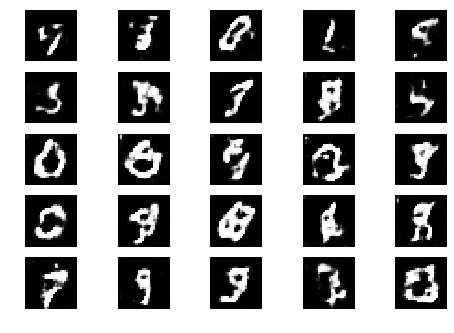

Epoch 0 Batch 1001/1875 [D loss: 0.632343, acc.: 62.50%] [G loss: 1.137439]
Epoch 0 Batch 1002/1875 [D loss: 0.635259, acc.: 59.38%] [G loss: 1.164049]
Epoch 0 Batch 1003/1875 [D loss: 0.889465, acc.: 53.12%] [G loss: 1.076646]
Epoch 0 Batch 1004/1875 [D loss: 0.710359, acc.: 56.25%] [G loss: 1.266102]
Epoch 0 Batch 1005/1875 [D loss: 0.920664, acc.: 31.25%] [G loss: 1.143064]
Epoch 0 Batch 1006/1875 [D loss: 0.776667, acc.: 50.00%] [G loss: 1.013804]
Epoch 0 Batch 1007/1875 [D loss: 0.631801, acc.: 62.50%] [G loss: 1.166366]
Epoch 0 Batch 1008/1875 [D loss: 0.712122, acc.: 62.50%] [G loss: 1.006763]
Epoch 0 Batch 1009/1875 [D loss: 0.518631, acc.: 62.50%] [G loss: 1.382566]
Epoch 0 Batch 1010/1875 [D loss: 0.965892, acc.: 28.12%] [G loss: 1.026462]


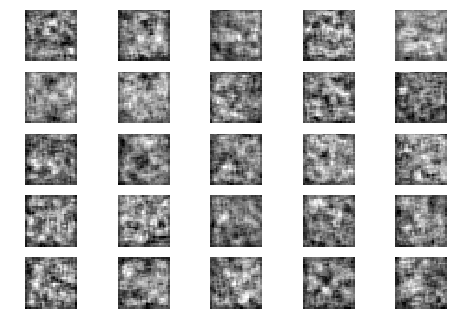

Epoch 0 Batch 1011/1875 [D loss: 0.800601, acc.: 46.88%] [G loss: 0.983276]
Epoch 0 Batch 1012/1875 [D loss: 0.666795, acc.: 65.62%] [G loss: 0.864482]
Epoch 0 Batch 1013/1875 [D loss: 0.796103, acc.: 46.88%] [G loss: 1.254816]
Epoch 0 Batch 1014/1875 [D loss: 0.608709, acc.: 71.88%] [G loss: 1.330212]
Epoch 0 Batch 1015/1875 [D loss: 0.617397, acc.: 65.62%] [G loss: 1.283076]
Epoch 0 Batch 1016/1875 [D loss: 0.740150, acc.: 59.38%] [G loss: 1.356272]
Epoch 0 Batch 1017/1875 [D loss: 0.511059, acc.: 75.00%] [G loss: 0.888616]
Epoch 0 Batch 1018/1875 [D loss: 0.742175, acc.: 50.00%] [G loss: 1.004878]
Epoch 0 Batch 1019/1875 [D loss: 0.596175, acc.: 62.50%] [G loss: 0.917107]
Epoch 0 Batch 1020/1875 [D loss: 0.715079, acc.: 59.38%] [G loss: 1.221386]


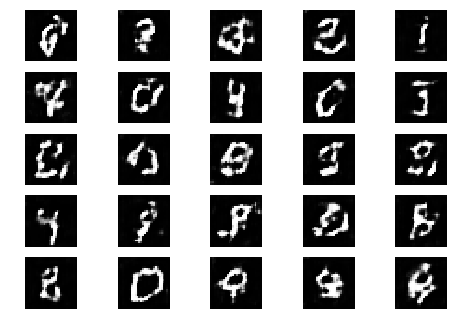

Epoch 0 Batch 1021/1875 [D loss: 0.645871, acc.: 56.25%] [G loss: 1.088947]
Epoch 0 Batch 1022/1875 [D loss: 0.603269, acc.: 68.75%] [G loss: 1.024163]
Epoch 0 Batch 1023/1875 [D loss: 0.789596, acc.: 46.88%] [G loss: 0.885556]
Epoch 0 Batch 1024/1875 [D loss: 0.608495, acc.: 68.75%] [G loss: 0.974111]
Epoch 0 Batch 1025/1875 [D loss: 0.707520, acc.: 56.25%] [G loss: 1.269538]
Epoch 0 Batch 1026/1875 [D loss: 0.776329, acc.: 56.25%] [G loss: 1.207579]
Epoch 0 Batch 1027/1875 [D loss: 0.555210, acc.: 75.00%] [G loss: 1.051481]
Epoch 0 Batch 1028/1875 [D loss: 0.566586, acc.: 71.88%] [G loss: 1.172151]
Epoch 0 Batch 1029/1875 [D loss: 0.663324, acc.: 62.50%] [G loss: 1.426085]
Epoch 0 Batch 1030/1875 [D loss: 0.558922, acc.: 68.75%] [G loss: 1.370379]
Epoch 0 Batch 1031/1875 [D loss: 0.614478, acc.: 59.38%] [G loss: 0.889783]
Epoch 0 Batch 1032/1875 [D loss: 0.831859, acc.: 46.88%] [G loss: 0.874287]
Epoch 0 Batch 1033/1875 [D loss: 0.663668, acc.: 59.38%] [G loss: 0.934887]
Epoch 0 Batc

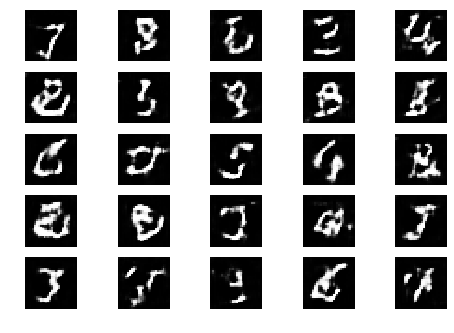

Epoch 0 Batch 1101/1875 [D loss: 0.648262, acc.: 62.50%] [G loss: 1.048169]
Epoch 0 Batch 1102/1875 [D loss: 0.715813, acc.: 56.25%] [G loss: 0.994821]
Epoch 0 Batch 1103/1875 [D loss: 0.675936, acc.: 59.38%] [G loss: 0.965816]
Epoch 0 Batch 1104/1875 [D loss: 0.752047, acc.: 46.88%] [G loss: 1.048109]
Epoch 0 Batch 1105/1875 [D loss: 0.738615, acc.: 53.12%] [G loss: 1.079398]
Epoch 0 Batch 1106/1875 [D loss: 0.652760, acc.: 59.38%] [G loss: 1.142423]
Epoch 0 Batch 1107/1875 [D loss: 0.639946, acc.: 50.00%] [G loss: 1.236427]
Epoch 0 Batch 1108/1875 [D loss: 0.742636, acc.: 53.12%] [G loss: 1.122275]
Epoch 0 Batch 1109/1875 [D loss: 0.800529, acc.: 43.75%] [G loss: 1.150647]
Epoch 0 Batch 1110/1875 [D loss: 0.641194, acc.: 65.62%] [G loss: 1.092494]
Epoch 0 Batch 1111/1875 [D loss: 0.712008, acc.: 59.38%] [G loss: 1.202954]


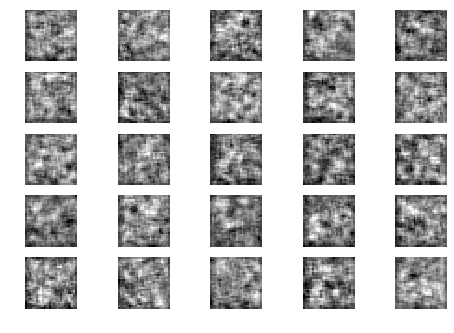

Epoch 0 Batch 1112/1875 [D loss: 0.709842, acc.: 56.25%] [G loss: 1.070330]
Epoch 0 Batch 1113/1875 [D loss: 0.625081, acc.: 65.62%] [G loss: 1.131596]
Epoch 0 Batch 1114/1875 [D loss: 0.718080, acc.: 59.38%] [G loss: 0.856481]
Epoch 0 Batch 1115/1875 [D loss: 0.530384, acc.: 75.00%] [G loss: 0.982284]
Epoch 0 Batch 1116/1875 [D loss: 0.937359, acc.: 40.62%] [G loss: 0.995555]
Epoch 0 Batch 1117/1875 [D loss: 0.781791, acc.: 53.12%] [G loss: 1.015872]
Epoch 0 Batch 1118/1875 [D loss: 0.772918, acc.: 53.12%] [G loss: 1.256679]
Epoch 0 Batch 1119/1875 [D loss: 0.709344, acc.: 56.25%] [G loss: 1.312145]
Epoch 0 Batch 1120/1875 [D loss: 0.609825, acc.: 65.62%] [G loss: 1.223693]
Epoch 0 Batch 1121/1875 [D loss: 0.649074, acc.: 62.50%] [G loss: 1.085413]
Epoch 0 Batch 1122/1875 [D loss: 0.559772, acc.: 75.00%] [G loss: 1.228577]


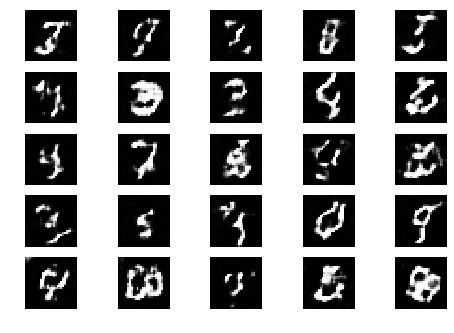

Epoch 0 Batch 1123/1875 [D loss: 0.555221, acc.: 68.75%] [G loss: 1.000224]
Epoch 0 Batch 1124/1875 [D loss: 0.795500, acc.: 43.75%] [G loss: 1.015892]
Epoch 0 Batch 1125/1875 [D loss: 0.542221, acc.: 71.88%] [G loss: 1.050450]
Epoch 0 Batch 1126/1875 [D loss: 0.718952, acc.: 50.00%] [G loss: 1.025018]
Epoch 0 Batch 1127/1875 [D loss: 0.526828, acc.: 75.00%] [G loss: 1.402431]
Epoch 0 Batch 1128/1875 [D loss: 0.700706, acc.: 56.25%] [G loss: 1.339145]
Epoch 0 Batch 1129/1875 [D loss: 0.668154, acc.: 65.62%] [G loss: 1.247143]
Epoch 0 Batch 1130/1875 [D loss: 0.851429, acc.: 37.50%] [G loss: 1.235567]
Epoch 0 Batch 1131/1875 [D loss: 0.684922, acc.: 59.38%] [G loss: 1.157981]
Epoch 0 Batch 1132/1875 [D loss: 0.779092, acc.: 46.88%] [G loss: 0.879228]
Epoch 0 Batch 1133/1875 [D loss: 0.702640, acc.: 56.25%] [G loss: 1.262899]
Epoch 0 Batch 1134/1875 [D loss: 0.672569, acc.: 71.88%] [G loss: 1.137848]
Epoch 0 Batch 1135/1875 [D loss: 0.741528, acc.: 53.12%] [G loss: 1.181463]
Epoch 0 Batc

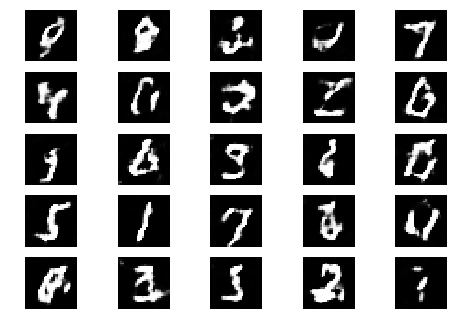

Epoch 0 Batch 1201/1875 [D loss: 0.636229, acc.: 68.75%] [G loss: 1.070186]
Epoch 0 Batch 1202/1875 [D loss: 0.635849, acc.: 59.38%] [G loss: 1.175476]
Epoch 0 Batch 1203/1875 [D loss: 0.725755, acc.: 56.25%] [G loss: 1.188516]
Epoch 0 Batch 1204/1875 [D loss: 0.784257, acc.: 43.75%] [G loss: 1.385082]
Epoch 0 Batch 1205/1875 [D loss: 0.743120, acc.: 56.25%] [G loss: 1.131384]
Epoch 0 Batch 1206/1875 [D loss: 0.609854, acc.: 59.38%] [G loss: 0.989114]
Epoch 0 Batch 1207/1875 [D loss: 0.703308, acc.: 53.12%] [G loss: 1.142132]
Epoch 0 Batch 1208/1875 [D loss: 0.613474, acc.: 65.62%] [G loss: 1.089463]
Epoch 0 Batch 1209/1875 [D loss: 0.727980, acc.: 50.00%] [G loss: 1.075720]
Epoch 0 Batch 1210/1875 [D loss: 0.634769, acc.: 68.75%] [G loss: 0.950432]
Epoch 0 Batch 1211/1875 [D loss: 0.934130, acc.: 37.50%] [G loss: 1.008000]
Epoch 0 Batch 1212/1875 [D loss: 0.664166, acc.: 53.12%] [G loss: 1.028544]


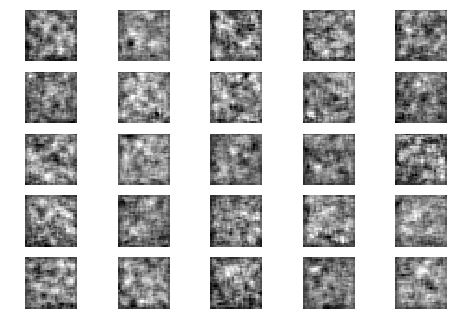

Epoch 0 Batch 1213/1875 [D loss: 0.693600, acc.: 56.25%] [G loss: 1.011062]
Epoch 0 Batch 1214/1875 [D loss: 0.671197, acc.: 62.50%] [G loss: 1.184282]
Epoch 0 Batch 1215/1875 [D loss: 0.684469, acc.: 59.38%] [G loss: 0.985163]
Epoch 0 Batch 1216/1875 [D loss: 0.592337, acc.: 62.50%] [G loss: 1.237972]
Epoch 0 Batch 1217/1875 [D loss: 0.677739, acc.: 59.38%] [G loss: 1.088009]
Epoch 0 Batch 1218/1875 [D loss: 0.693877, acc.: 59.38%] [G loss: 1.019215]
Epoch 0 Batch 1219/1875 [D loss: 0.664690, acc.: 59.38%] [G loss: 0.919073]
Epoch 0 Batch 1220/1875 [D loss: 0.901627, acc.: 40.62%] [G loss: 0.981958]
Epoch 0 Batch 1221/1875 [D loss: 0.916210, acc.: 34.38%] [G loss: 0.971117]
Epoch 0 Batch 1222/1875 [D loss: 0.804133, acc.: 50.00%] [G loss: 1.195648]
Epoch 0 Batch 1223/1875 [D loss: 0.620503, acc.: 68.75%] [G loss: 1.018138]
Epoch 0 Batch 1224/1875 [D loss: 0.638295, acc.: 65.62%] [G loss: 1.036457]


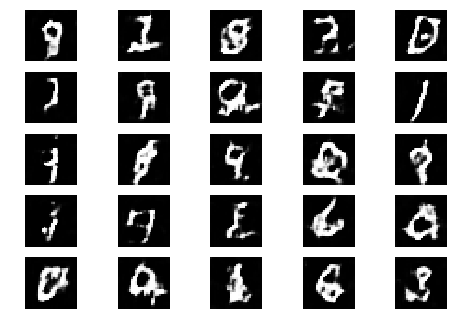

Epoch 0 Batch 1225/1875 [D loss: 0.709549, acc.: 53.12%] [G loss: 1.093329]
Epoch 0 Batch 1226/1875 [D loss: 0.560124, acc.: 65.62%] [G loss: 1.277654]
Epoch 0 Batch 1227/1875 [D loss: 0.677702, acc.: 53.12%] [G loss: 1.019145]
Epoch 0 Batch 1228/1875 [D loss: 0.742941, acc.: 62.50%] [G loss: 1.041515]
Epoch 0 Batch 1229/1875 [D loss: 0.775633, acc.: 50.00%] [G loss: 1.110363]
Epoch 0 Batch 1230/1875 [D loss: 0.642545, acc.: 56.25%] [G loss: 0.998561]
Epoch 0 Batch 1231/1875 [D loss: 0.618213, acc.: 65.62%] [G loss: 1.065583]
Epoch 0 Batch 1232/1875 [D loss: 0.611149, acc.: 68.75%] [G loss: 1.267657]
Epoch 0 Batch 1233/1875 [D loss: 0.716558, acc.: 56.25%] [G loss: 1.061678]
Epoch 0 Batch 1234/1875 [D loss: 0.638762, acc.: 62.50%] [G loss: 1.123636]
Epoch 0 Batch 1235/1875 [D loss: 0.640124, acc.: 71.88%] [G loss: 0.892517]
Epoch 0 Batch 1236/1875 [D loss: 0.573954, acc.: 68.75%] [G loss: 1.075632]
Epoch 0 Batch 1237/1875 [D loss: 0.807274, acc.: 43.75%] [G loss: 1.011717]
Epoch 0 Batc

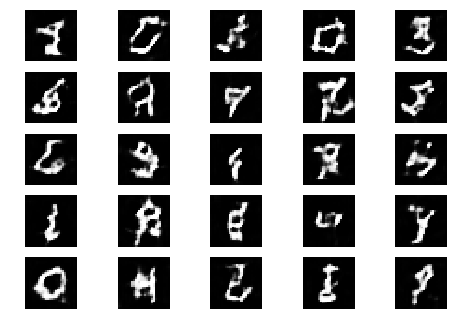

Epoch 0 Batch 1301/1875 [D loss: 0.500171, acc.: 78.12%] [G loss: 1.237135]
Epoch 0 Batch 1302/1875 [D loss: 0.591828, acc.: 59.38%] [G loss: 1.123575]
Epoch 0 Batch 1303/1875 [D loss: 0.693755, acc.: 53.12%] [G loss: 1.086287]
Epoch 0 Batch 1304/1875 [D loss: 0.823275, acc.: 37.50%] [G loss: 0.932894]
Epoch 0 Batch 1305/1875 [D loss: 0.722981, acc.: 56.25%] [G loss: 1.240368]
Epoch 0 Batch 1306/1875 [D loss: 0.920945, acc.: 34.38%] [G loss: 1.225352]
Epoch 0 Batch 1307/1875 [D loss: 0.646937, acc.: 68.75%] [G loss: 1.091561]
Epoch 0 Batch 1308/1875 [D loss: 0.513581, acc.: 81.25%] [G loss: 1.041190]
Epoch 0 Batch 1309/1875 [D loss: 0.616145, acc.: 68.75%] [G loss: 0.817378]
Epoch 0 Batch 1310/1875 [D loss: 0.711591, acc.: 56.25%] [G loss: 1.013074]
Epoch 0 Batch 1311/1875 [D loss: 0.728014, acc.: 50.00%] [G loss: 0.940960]
Epoch 0 Batch 1312/1875 [D loss: 0.708354, acc.: 65.62%] [G loss: 1.081095]
Epoch 0 Batch 1313/1875 [D loss: 0.684028, acc.: 59.38%] [G loss: 1.231828]


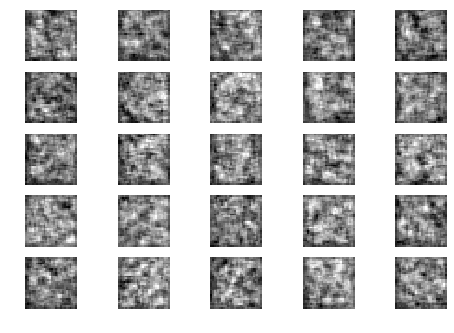

Epoch 0 Batch 1314/1875 [D loss: 0.749483, acc.: 59.38%] [G loss: 1.249456]
Epoch 0 Batch 1315/1875 [D loss: 0.671440, acc.: 62.50%] [G loss: 1.170420]
Epoch 0 Batch 1316/1875 [D loss: 0.793885, acc.: 43.75%] [G loss: 1.268551]
Epoch 0 Batch 1317/1875 [D loss: 0.805035, acc.: 46.88%] [G loss: 1.096074]
Epoch 0 Batch 1318/1875 [D loss: 0.636641, acc.: 68.75%] [G loss: 0.944408]
Epoch 0 Batch 1319/1875 [D loss: 0.568049, acc.: 65.62%] [G loss: 0.878975]
Epoch 0 Batch 1320/1875 [D loss: 0.669394, acc.: 62.50%] [G loss: 0.904568]
Epoch 0 Batch 1321/1875 [D loss: 0.739765, acc.: 46.88%] [G loss: 1.111165]
Epoch 0 Batch 1322/1875 [D loss: 0.620774, acc.: 59.38%] [G loss: 0.828205]
Epoch 0 Batch 1323/1875 [D loss: 0.618590, acc.: 62.50%] [G loss: 1.203157]
Epoch 0 Batch 1324/1875 [D loss: 0.856059, acc.: 34.38%] [G loss: 0.953090]
Epoch 0 Batch 1325/1875 [D loss: 0.687294, acc.: 50.00%] [G loss: 1.126542]
Epoch 0 Batch 1326/1875 [D loss: 0.700451, acc.: 65.62%] [G loss: 1.178607]


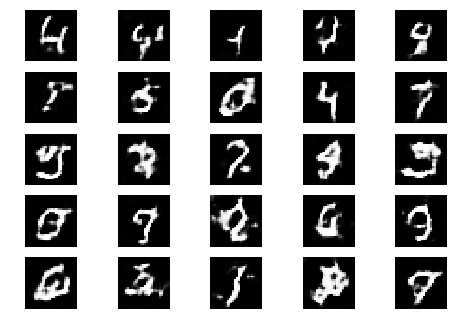

Epoch 0 Batch 1327/1875 [D loss: 0.690112, acc.: 53.12%] [G loss: 1.060675]
Epoch 0 Batch 1328/1875 [D loss: 0.875371, acc.: 34.38%] [G loss: 0.952087]
Epoch 0 Batch 1329/1875 [D loss: 0.678115, acc.: 62.50%] [G loss: 1.089001]
Epoch 0 Batch 1330/1875 [D loss: 0.576606, acc.: 62.50%] [G loss: 1.105344]
Epoch 0 Batch 1331/1875 [D loss: 0.686587, acc.: 56.25%] [G loss: 0.969470]
Epoch 0 Batch 1332/1875 [D loss: 0.624726, acc.: 65.62%] [G loss: 0.966643]
Epoch 0 Batch 1333/1875 [D loss: 0.933201, acc.: 37.50%] [G loss: 0.964181]
Epoch 0 Batch 1334/1875 [D loss: 0.685852, acc.: 65.62%] [G loss: 1.039902]
Epoch 0 Batch 1335/1875 [D loss: 0.762292, acc.: 59.38%] [G loss: 0.814448]
Epoch 0 Batch 1336/1875 [D loss: 0.633218, acc.: 65.62%] [G loss: 0.840722]
Epoch 0 Batch 1337/1875 [D loss: 0.665090, acc.: 53.12%] [G loss: 0.870547]
Epoch 0 Batch 1338/1875 [D loss: 0.746766, acc.: 46.88%] [G loss: 1.061527]
Epoch 0 Batch 1339/1875 [D loss: 0.668318, acc.: 59.38%] [G loss: 0.939212]
Epoch 0 Batc

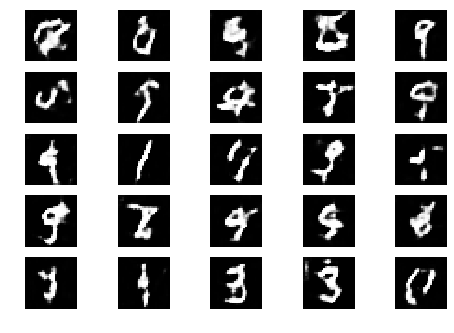

Epoch 0 Batch 1401/1875 [D loss: 0.742392, acc.: 56.25%] [G loss: 0.766806]
Epoch 0 Batch 1402/1875 [D loss: 0.541019, acc.: 71.88%] [G loss: 0.944420]
Epoch 0 Batch 1403/1875 [D loss: 0.756220, acc.: 46.88%] [G loss: 0.907356]
Epoch 0 Batch 1404/1875 [D loss: 0.612879, acc.: 75.00%] [G loss: 1.051108]
Epoch 0 Batch 1405/1875 [D loss: 0.716845, acc.: 53.12%] [G loss: 1.138311]
Epoch 0 Batch 1406/1875 [D loss: 0.729467, acc.: 59.38%] [G loss: 0.843797]
Epoch 0 Batch 1407/1875 [D loss: 0.805189, acc.: 50.00%] [G loss: 1.170963]
Epoch 0 Batch 1408/1875 [D loss: 0.704640, acc.: 43.75%] [G loss: 1.106725]
Epoch 0 Batch 1409/1875 [D loss: 0.607125, acc.: 71.88%] [G loss: 1.256109]
Epoch 0 Batch 1410/1875 [D loss: 0.656352, acc.: 68.75%] [G loss: 1.305623]
Epoch 0 Batch 1411/1875 [D loss: 0.746960, acc.: 43.75%] [G loss: 1.079035]
Epoch 0 Batch 1412/1875 [D loss: 0.639495, acc.: 68.75%] [G loss: 1.097473]
Epoch 0 Batch 1413/1875 [D loss: 0.662375, acc.: 59.38%] [G loss: 1.004858]
Epoch 0 Batc

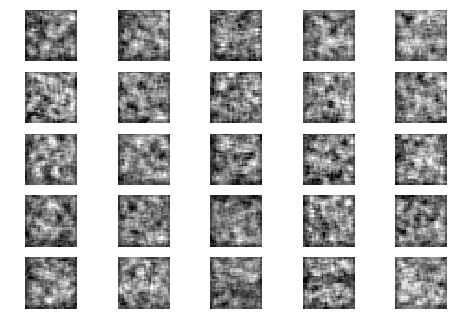

Epoch 0 Batch 1415/1875 [D loss: 0.716738, acc.: 56.25%] [G loss: 1.117669]
Epoch 0 Batch 1416/1875 [D loss: 0.632158, acc.: 68.75%] [G loss: 1.023447]
Epoch 0 Batch 1417/1875 [D loss: 0.700794, acc.: 59.38%] [G loss: 0.835009]
Epoch 0 Batch 1418/1875 [D loss: 0.853726, acc.: 43.75%] [G loss: 1.064915]
Epoch 0 Batch 1419/1875 [D loss: 0.699050, acc.: 65.62%] [G loss: 1.028061]
Epoch 0 Batch 1420/1875 [D loss: 0.821434, acc.: 40.62%] [G loss: 1.145108]
Epoch 0 Batch 1421/1875 [D loss: 0.612320, acc.: 62.50%] [G loss: 1.248590]
Epoch 0 Batch 1422/1875 [D loss: 0.658936, acc.: 59.38%] [G loss: 1.127629]
Epoch 0 Batch 1423/1875 [D loss: 0.719177, acc.: 56.25%] [G loss: 0.885176]
Epoch 0 Batch 1424/1875 [D loss: 0.615849, acc.: 68.75%] [G loss: 1.120117]
Epoch 0 Batch 1425/1875 [D loss: 0.589973, acc.: 65.62%] [G loss: 0.960784]
Epoch 0 Batch 1426/1875 [D loss: 0.624933, acc.: 65.62%] [G loss: 1.141224]
Epoch 0 Batch 1427/1875 [D loss: 0.615843, acc.: 71.88%] [G loss: 1.215435]
Epoch 0 Batc

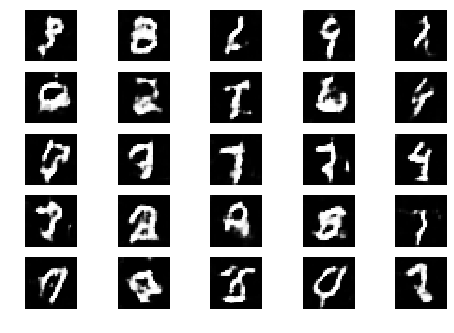

Epoch 0 Batch 1429/1875 [D loss: 0.706722, acc.: 56.25%] [G loss: 1.036346]
Epoch 0 Batch 1430/1875 [D loss: 0.626051, acc.: 53.12%] [G loss: 0.975743]
Epoch 0 Batch 1431/1875 [D loss: 0.623207, acc.: 65.62%] [G loss: 1.085111]
Epoch 0 Batch 1432/1875 [D loss: 0.753450, acc.: 56.25%] [G loss: 0.994782]
Epoch 0 Batch 1433/1875 [D loss: 0.662528, acc.: 56.25%] [G loss: 0.897418]
Epoch 0 Batch 1434/1875 [D loss: 0.727821, acc.: 59.38%] [G loss: 0.981381]
Epoch 0 Batch 1435/1875 [D loss: 0.622249, acc.: 62.50%] [G loss: 0.839025]
Epoch 0 Batch 1436/1875 [D loss: 0.699423, acc.: 68.75%] [G loss: 1.126786]
Epoch 0 Batch 1437/1875 [D loss: 0.688163, acc.: 62.50%] [G loss: 1.190239]
Epoch 0 Batch 1438/1875 [D loss: 0.692986, acc.: 65.62%] [G loss: 1.036342]
Epoch 0 Batch 1439/1875 [D loss: 0.726199, acc.: 59.38%] [G loss: 0.901412]
Epoch 0 Batch 1440/1875 [D loss: 0.773276, acc.: 46.88%] [G loss: 0.925487]
Epoch 0 Batch 1441/1875 [D loss: 0.744507, acc.: 62.50%] [G loss: 1.073326]
Epoch 0 Batc

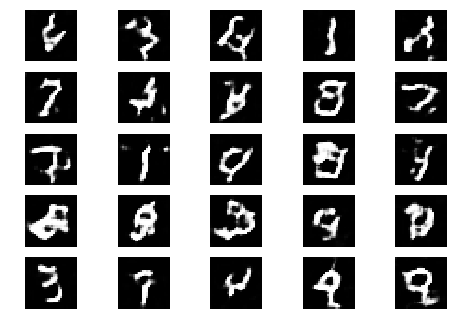

Epoch 0 Batch 1501/1875 [D loss: 0.655216, acc.: 65.62%] [G loss: 1.187054]
Epoch 0 Batch 1502/1875 [D loss: 0.624829, acc.: 59.38%] [G loss: 1.150579]
Epoch 0 Batch 1503/1875 [D loss: 0.492379, acc.: 81.25%] [G loss: 1.342076]
Epoch 0 Batch 1504/1875 [D loss: 0.683919, acc.: 62.50%] [G loss: 0.998228]
Epoch 0 Batch 1505/1875 [D loss: 0.647751, acc.: 50.00%] [G loss: 0.927448]
Epoch 0 Batch 1506/1875 [D loss: 0.808399, acc.: 46.88%] [G loss: 0.926445]
Epoch 0 Batch 1507/1875 [D loss: 0.550065, acc.: 81.25%] [G loss: 1.055992]
Epoch 0 Batch 1508/1875 [D loss: 0.636053, acc.: 62.50%] [G loss: 0.933772]
Epoch 0 Batch 1509/1875 [D loss: 0.526608, acc.: 78.12%] [G loss: 1.307105]
Epoch 0 Batch 1510/1875 [D loss: 0.739825, acc.: 50.00%] [G loss: 0.944649]
Epoch 0 Batch 1511/1875 [D loss: 0.645559, acc.: 65.62%] [G loss: 0.935448]
Epoch 0 Batch 1512/1875 [D loss: 0.573813, acc.: 75.00%] [G loss: 0.874311]
Epoch 0 Batch 1513/1875 [D loss: 0.674583, acc.: 62.50%] [G loss: 0.911136]
Epoch 0 Batc

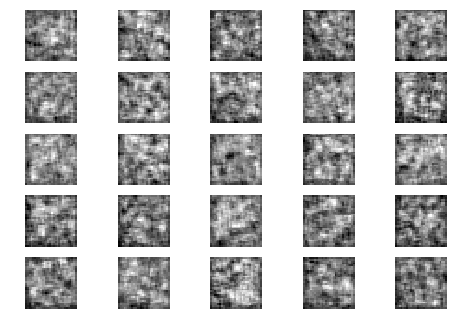

Epoch 0 Batch 1516/1875 [D loss: 0.557062, acc.: 75.00%] [G loss: 1.068399]
Epoch 0 Batch 1517/1875 [D loss: 0.776381, acc.: 56.25%] [G loss: 0.988939]
Epoch 0 Batch 1518/1875 [D loss: 0.549556, acc.: 71.88%] [G loss: 1.043439]
Epoch 0 Batch 1519/1875 [D loss: 0.739901, acc.: 43.75%] [G loss: 1.074842]
Epoch 0 Batch 1520/1875 [D loss: 0.666772, acc.: 56.25%] [G loss: 1.030166]
Epoch 0 Batch 1521/1875 [D loss: 0.572887, acc.: 75.00%] [G loss: 1.280880]
Epoch 0 Batch 1522/1875 [D loss: 0.654430, acc.: 56.25%] [G loss: 1.142602]
Epoch 0 Batch 1523/1875 [D loss: 0.725886, acc.: 53.12%] [G loss: 1.065495]
Epoch 0 Batch 1524/1875 [D loss: 0.620216, acc.: 62.50%] [G loss: 1.019970]
Epoch 0 Batch 1525/1875 [D loss: 0.711445, acc.: 43.75%] [G loss: 1.125257]
Epoch 0 Batch 1526/1875 [D loss: 0.731840, acc.: 53.12%] [G loss: 0.908499]
Epoch 0 Batch 1527/1875 [D loss: 0.625288, acc.: 65.62%] [G loss: 1.068758]
Epoch 0 Batch 1528/1875 [D loss: 0.668342, acc.: 50.00%] [G loss: 1.141163]
Epoch 0 Batc

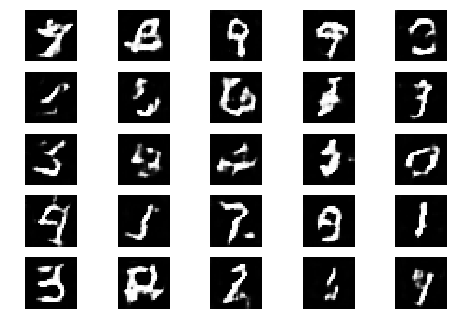

Epoch 0 Batch 1531/1875 [D loss: 0.562010, acc.: 78.12%] [G loss: 0.929748]
Epoch 0 Batch 1532/1875 [D loss: 0.858284, acc.: 46.88%] [G loss: 0.863878]
Epoch 0 Batch 1533/1875 [D loss: 0.671760, acc.: 65.62%] [G loss: 1.169517]
Epoch 0 Batch 1534/1875 [D loss: 0.705379, acc.: 50.00%] [G loss: 0.972044]
Epoch 0 Batch 1535/1875 [D loss: 0.702080, acc.: 56.25%] [G loss: 0.933920]
Epoch 0 Batch 1536/1875 [D loss: 0.678223, acc.: 65.62%] [G loss: 1.088407]
Epoch 0 Batch 1537/1875 [D loss: 0.658149, acc.: 56.25%] [G loss: 1.183370]
Epoch 0 Batch 1538/1875 [D loss: 0.685845, acc.: 62.50%] [G loss: 1.011611]
Epoch 0 Batch 1539/1875 [D loss: 0.671167, acc.: 68.75%] [G loss: 1.074517]
Epoch 0 Batch 1540/1875 [D loss: 0.642086, acc.: 65.62%] [G loss: 0.923593]
Epoch 0 Batch 1541/1875 [D loss: 0.609856, acc.: 71.88%] [G loss: 1.083147]
Epoch 0 Batch 1542/1875 [D loss: 0.609717, acc.: 65.62%] [G loss: 0.823871]
Epoch 0 Batch 1543/1875 [D loss: 0.645304, acc.: 59.38%] [G loss: 1.010098]
Epoch 0 Batc

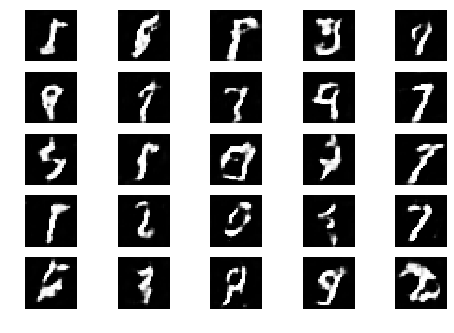

Epoch 0 Batch 1601/1875 [D loss: 0.762535, acc.: 53.12%] [G loss: 1.006543]
Epoch 0 Batch 1602/1875 [D loss: 0.684276, acc.: 56.25%] [G loss: 0.980450]
Epoch 0 Batch 1603/1875 [D loss: 0.591859, acc.: 65.62%] [G loss: 0.932654]
Epoch 0 Batch 1604/1875 [D loss: 0.844120, acc.: 46.88%] [G loss: 0.878636]
Epoch 0 Batch 1605/1875 [D loss: 0.731922, acc.: 59.38%] [G loss: 0.969301]
Epoch 0 Batch 1606/1875 [D loss: 0.599318, acc.: 62.50%] [G loss: 1.043937]
Epoch 0 Batch 1607/1875 [D loss: 0.819533, acc.: 46.88%] [G loss: 1.071652]
Epoch 0 Batch 1608/1875 [D loss: 0.805905, acc.: 46.88%] [G loss: 0.993270]
Epoch 0 Batch 1609/1875 [D loss: 0.679466, acc.: 62.50%] [G loss: 1.049332]
Epoch 0 Batch 1610/1875 [D loss: 0.813156, acc.: 53.12%] [G loss: 0.993983]
Epoch 0 Batch 1611/1875 [D loss: 0.751959, acc.: 43.75%] [G loss: 0.998091]
Epoch 0 Batch 1612/1875 [D loss: 0.732694, acc.: 53.12%] [G loss: 1.093602]
Epoch 0 Batch 1613/1875 [D loss: 0.730783, acc.: 53.12%] [G loss: 0.953942]
Epoch 0 Batc

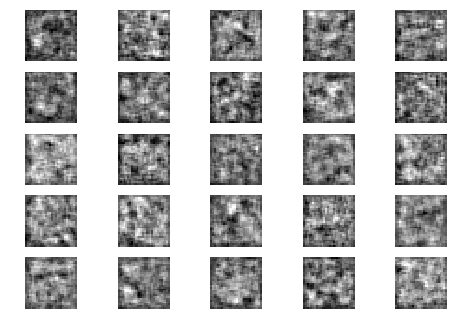

Epoch 0 Batch 1617/1875 [D loss: 0.757310, acc.: 50.00%] [G loss: 1.145938]
Epoch 0 Batch 1618/1875 [D loss: 0.717262, acc.: 50.00%] [G loss: 1.035133]
Epoch 0 Batch 1619/1875 [D loss: 0.640223, acc.: 62.50%] [G loss: 1.076752]
Epoch 0 Batch 1620/1875 [D loss: 0.717085, acc.: 62.50%] [G loss: 0.993215]
Epoch 0 Batch 1621/1875 [D loss: 0.599358, acc.: 71.88%] [G loss: 0.947441]
Epoch 0 Batch 1622/1875 [D loss: 0.622441, acc.: 65.62%] [G loss: 1.018321]
Epoch 0 Batch 1623/1875 [D loss: 0.665775, acc.: 71.88%] [G loss: 1.121428]
Epoch 0 Batch 1624/1875 [D loss: 0.582062, acc.: 68.75%] [G loss: 1.003041]
Epoch 0 Batch 1625/1875 [D loss: 0.739141, acc.: 56.25%] [G loss: 1.179221]
Epoch 0 Batch 1626/1875 [D loss: 0.707641, acc.: 43.75%] [G loss: 1.123173]
Epoch 0 Batch 1627/1875 [D loss: 0.826210, acc.: 46.88%] [G loss: 0.961194]
Epoch 0 Batch 1628/1875 [D loss: 0.650258, acc.: 65.62%] [G loss: 0.856435]
Epoch 0 Batch 1629/1875 [D loss: 0.660024, acc.: 53.12%] [G loss: 0.971980]
Epoch 0 Batc

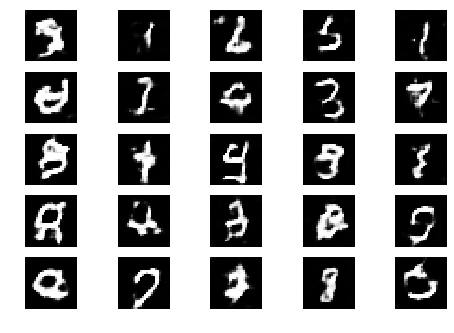

Epoch 0 Batch 1633/1875 [D loss: 0.626033, acc.: 62.50%] [G loss: 1.042926]
Epoch 0 Batch 1634/1875 [D loss: 0.596132, acc.: 56.25%] [G loss: 1.113232]
Epoch 0 Batch 1635/1875 [D loss: 0.693690, acc.: 56.25%] [G loss: 1.062794]
Epoch 0 Batch 1636/1875 [D loss: 0.619479, acc.: 68.75%] [G loss: 1.273640]
Epoch 0 Batch 1637/1875 [D loss: 0.839670, acc.: 40.62%] [G loss: 1.019570]
Epoch 0 Batch 1638/1875 [D loss: 0.661633, acc.: 68.75%] [G loss: 1.117225]
Epoch 0 Batch 1639/1875 [D loss: 0.562201, acc.: 68.75%] [G loss: 0.995752]
Epoch 0 Batch 1640/1875 [D loss: 0.678757, acc.: 65.62%] [G loss: 1.057074]
Epoch 0 Batch 1641/1875 [D loss: 0.733701, acc.: 56.25%] [G loss: 1.027048]
Epoch 0 Batch 1642/1875 [D loss: 0.603539, acc.: 65.62%] [G loss: 0.941204]
Epoch 0 Batch 1643/1875 [D loss: 0.685719, acc.: 56.25%] [G loss: 1.075698]
Epoch 0 Batch 1644/1875 [D loss: 0.695053, acc.: 62.50%] [G loss: 1.031699]
Epoch 0 Batch 1645/1875 [D loss: 0.592281, acc.: 65.62%] [G loss: 0.902420]
Epoch 0 Batc

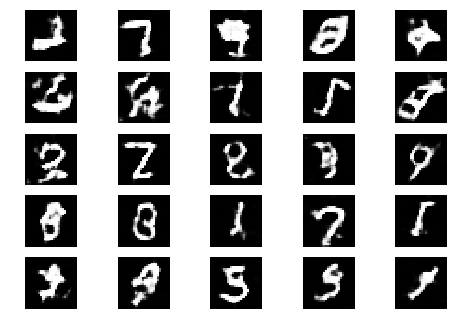

Epoch 0 Batch 1701/1875 [D loss: 0.517450, acc.: 75.00%] [G loss: 1.087174]
Epoch 0 Batch 1702/1875 [D loss: 0.656331, acc.: 68.75%] [G loss: 0.863524]
Epoch 0 Batch 1703/1875 [D loss: 0.660396, acc.: 68.75%] [G loss: 0.908768]
Epoch 0 Batch 1704/1875 [D loss: 0.685919, acc.: 59.38%] [G loss: 0.999785]
Epoch 0 Batch 1705/1875 [D loss: 0.649787, acc.: 62.50%] [G loss: 1.107752]
Epoch 0 Batch 1706/1875 [D loss: 0.592170, acc.: 59.38%] [G loss: 1.322248]
Epoch 0 Batch 1707/1875 [D loss: 0.785697, acc.: 43.75%] [G loss: 1.085123]
Epoch 0 Batch 1708/1875 [D loss: 0.775320, acc.: 46.88%] [G loss: 0.859845]
Epoch 0 Batch 1709/1875 [D loss: 0.622247, acc.: 68.75%] [G loss: 0.963294]
Epoch 0 Batch 1710/1875 [D loss: 0.531503, acc.: 75.00%] [G loss: 0.961607]
Epoch 0 Batch 1711/1875 [D loss: 0.628026, acc.: 68.75%] [G loss: 0.927749]
Epoch 0 Batch 1712/1875 [D loss: 0.630686, acc.: 65.62%] [G loss: 1.004304]
Epoch 0 Batch 1713/1875 [D loss: 0.577676, acc.: 65.62%] [G loss: 0.960765]
Epoch 0 Batc

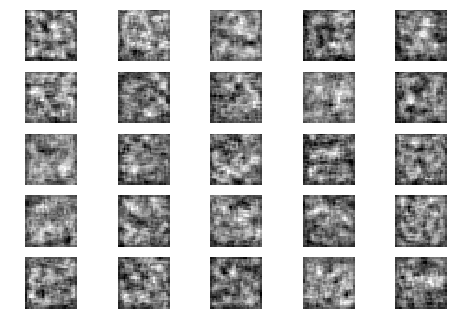

Epoch 0 Batch 1718/1875 [D loss: 0.759935, acc.: 56.25%] [G loss: 0.939294]
Epoch 0 Batch 1719/1875 [D loss: 0.612224, acc.: 59.38%] [G loss: 0.913853]
Epoch 0 Batch 1720/1875 [D loss: 0.773039, acc.: 43.75%] [G loss: 1.046555]
Epoch 0 Batch 1721/1875 [D loss: 0.715087, acc.: 59.38%] [G loss: 0.902911]
Epoch 0 Batch 1722/1875 [D loss: 0.849149, acc.: 46.88%] [G loss: 1.176883]
Epoch 0 Batch 1723/1875 [D loss: 0.707135, acc.: 50.00%] [G loss: 0.937511]
Epoch 0 Batch 1724/1875 [D loss: 0.738342, acc.: 62.50%] [G loss: 1.076122]
Epoch 0 Batch 1725/1875 [D loss: 0.696864, acc.: 68.75%] [G loss: 0.988358]
Epoch 0 Batch 1726/1875 [D loss: 0.674047, acc.: 65.62%] [G loss: 1.046749]
Epoch 0 Batch 1727/1875 [D loss: 0.631513, acc.: 59.38%] [G loss: 1.056424]
Epoch 0 Batch 1728/1875 [D loss: 0.559694, acc.: 81.25%] [G loss: 1.061184]
Epoch 0 Batch 1729/1875 [D loss: 0.617252, acc.: 62.50%] [G loss: 0.959934]
Epoch 0 Batch 1730/1875 [D loss: 0.675607, acc.: 62.50%] [G loss: 1.035021]
Epoch 0 Batc

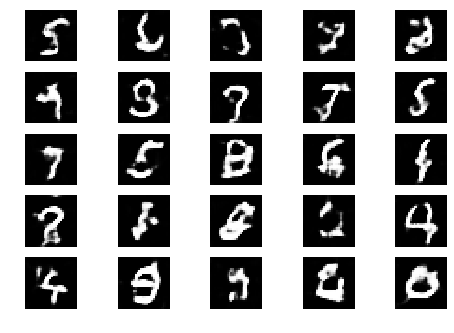

Epoch 0 Batch 1735/1875 [D loss: 0.803587, acc.: 40.62%] [G loss: 0.983621]
Epoch 0 Batch 1736/1875 [D loss: 0.674791, acc.: 56.25%] [G loss: 1.185920]
Epoch 0 Batch 1737/1875 [D loss: 0.730773, acc.: 50.00%] [G loss: 0.922252]
Epoch 0 Batch 1738/1875 [D loss: 0.590001, acc.: 81.25%] [G loss: 1.088302]
Epoch 0 Batch 1739/1875 [D loss: 0.685064, acc.: 59.38%] [G loss: 1.293055]
Epoch 0 Batch 1740/1875 [D loss: 0.868726, acc.: 37.50%] [G loss: 1.172184]
Epoch 0 Batch 1741/1875 [D loss: 0.691750, acc.: 53.12%] [G loss: 0.955722]
Epoch 0 Batch 1742/1875 [D loss: 0.487002, acc.: 87.50%] [G loss: 1.227893]
Epoch 0 Batch 1743/1875 [D loss: 0.821812, acc.: 50.00%] [G loss: 0.924990]
Epoch 0 Batch 1744/1875 [D loss: 0.556841, acc.: 65.62%] [G loss: 0.882658]
Epoch 0 Batch 1745/1875 [D loss: 0.625857, acc.: 62.50%] [G loss: 0.916212]
Epoch 0 Batch 1746/1875 [D loss: 0.772413, acc.: 59.38%] [G loss: 0.892622]
Epoch 0 Batch 1747/1875 [D loss: 0.683152, acc.: 59.38%] [G loss: 0.857871]
Epoch 0 Batc

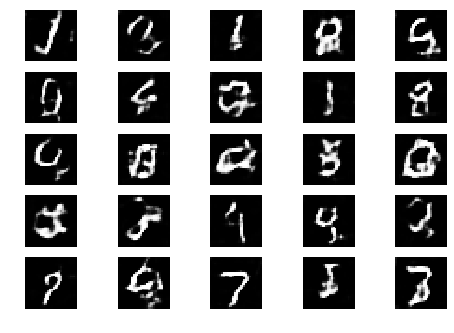

Epoch 0 Batch 1801/1875 [D loss: 0.749880, acc.: 50.00%] [G loss: 1.074143]
Epoch 0 Batch 1802/1875 [D loss: 0.752264, acc.: 50.00%] [G loss: 0.985587]
Epoch 0 Batch 1803/1875 [D loss: 0.602071, acc.: 59.38%] [G loss: 1.085843]
Epoch 0 Batch 1804/1875 [D loss: 0.691767, acc.: 53.12%] [G loss: 1.099073]
Epoch 0 Batch 1805/1875 [D loss: 0.640804, acc.: 59.38%] [G loss: 0.907647]
Epoch 0 Batch 1806/1875 [D loss: 0.675899, acc.: 62.50%] [G loss: 0.974236]
Epoch 0 Batch 1807/1875 [D loss: 0.684209, acc.: 56.25%] [G loss: 1.247142]
Epoch 0 Batch 1808/1875 [D loss: 0.591169, acc.: 65.62%] [G loss: 0.874225]
Epoch 0 Batch 1809/1875 [D loss: 0.687172, acc.: 59.38%] [G loss: 1.210568]
Epoch 0 Batch 1810/1875 [D loss: 0.701299, acc.: 50.00%] [G loss: 1.093539]
Epoch 0 Batch 1811/1875 [D loss: 0.504624, acc.: 81.25%] [G loss: 1.015330]
Epoch 0 Batch 1812/1875 [D loss: 0.784251, acc.: 53.12%] [G loss: 1.105628]
Epoch 0 Batch 1813/1875 [D loss: 0.674293, acc.: 50.00%] [G loss: 1.181551]
Epoch 0 Batc

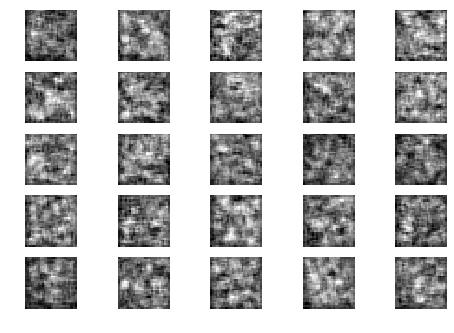

Epoch 0 Batch 1819/1875 [D loss: 0.631969, acc.: 50.00%] [G loss: 1.006182]
Epoch 0 Batch 1820/1875 [D loss: 0.571912, acc.: 65.62%] [G loss: 1.012679]
Epoch 0 Batch 1821/1875 [D loss: 0.709958, acc.: 59.38%] [G loss: 0.856254]
Epoch 0 Batch 1822/1875 [D loss: 0.735911, acc.: 50.00%] [G loss: 0.811218]
Epoch 0 Batch 1823/1875 [D loss: 0.508714, acc.: 78.12%] [G loss: 0.829108]
Epoch 0 Batch 1824/1875 [D loss: 0.747721, acc.: 50.00%] [G loss: 1.001758]
Epoch 0 Batch 1825/1875 [D loss: 0.578487, acc.: 71.88%] [G loss: 0.894855]
Epoch 0 Batch 1826/1875 [D loss: 0.639869, acc.: 62.50%] [G loss: 0.894445]
Epoch 0 Batch 1827/1875 [D loss: 0.744883, acc.: 53.12%] [G loss: 0.927017]
Epoch 0 Batch 1828/1875 [D loss: 0.526553, acc.: 68.75%] [G loss: 1.194072]
Epoch 0 Batch 1829/1875 [D loss: 0.644347, acc.: 62.50%] [G loss: 1.047395]
Epoch 0 Batch 1830/1875 [D loss: 0.578598, acc.: 78.12%] [G loss: 1.194496]
Epoch 0 Batch 1831/1875 [D loss: 0.703130, acc.: 59.38%] [G loss: 1.021699]
Epoch 0 Batc

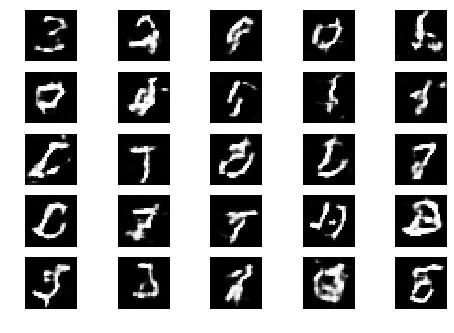

Epoch 0 Batch 1837/1875 [D loss: 0.620512, acc.: 68.75%] [G loss: 1.325285]
Epoch 0 Batch 1838/1875 [D loss: 0.660351, acc.: 65.62%] [G loss: 1.003920]
Epoch 0 Batch 1839/1875 [D loss: 0.633515, acc.: 65.62%] [G loss: 1.080176]
Epoch 0 Batch 1840/1875 [D loss: 0.882445, acc.: 40.62%] [G loss: 1.015630]
Epoch 0 Batch 1841/1875 [D loss: 0.627680, acc.: 53.12%] [G loss: 0.837905]
Epoch 0 Batch 1842/1875 [D loss: 0.616781, acc.: 68.75%] [G loss: 0.910464]
Epoch 0 Batch 1843/1875 [D loss: 0.663777, acc.: 50.00%] [G loss: 1.028680]
Epoch 0 Batch 1844/1875 [D loss: 0.544985, acc.: 75.00%] [G loss: 1.094527]
Epoch 0 Batch 1845/1875 [D loss: 0.683694, acc.: 59.38%] [G loss: 0.819822]
Epoch 0 Batch 1846/1875 [D loss: 0.580282, acc.: 62.50%] [G loss: 1.154417]
Epoch 0 Batch 1847/1875 [D loss: 0.665242, acc.: 62.50%] [G loss: 1.088769]
Epoch 0 Batch 1848/1875 [D loss: 0.711407, acc.: 50.00%] [G loss: 0.952990]
Epoch 0 Batch 1849/1875 [D loss: 0.670189, acc.: 65.62%] [G loss: 0.884639]
Epoch 0 Batc

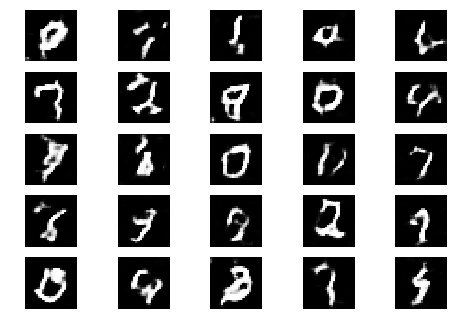

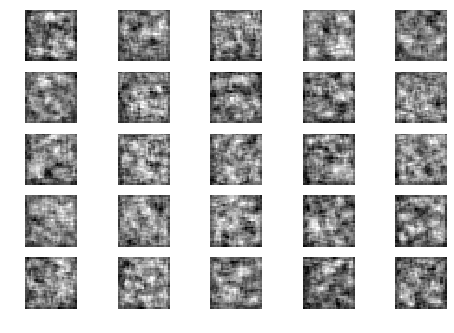

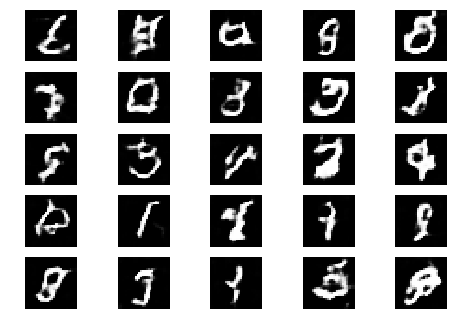

Epoch 1 Batch 1/1875 [D loss: 0.715837, acc.: 59.38%] [G loss: 0.990496]
Epoch 1 Batch 2/1875 [D loss: 0.741280, acc.: 50.00%] [G loss: 1.072863]
Epoch 1 Batch 3/1875 [D loss: 0.645746, acc.: 68.75%] [G loss: 1.128884]
Epoch 1 Batch 4/1875 [D loss: 0.679045, acc.: 62.50%] [G loss: 1.097266]
Epoch 1 Batch 5/1875 [D loss: 0.766603, acc.: 50.00%] [G loss: 0.988979]
Epoch 1 Batch 6/1875 [D loss: 0.695910, acc.: 53.12%] [G loss: 0.935137]
Epoch 1 Batch 7/1875 [D loss: 0.508718, acc.: 87.50%] [G loss: 1.010182]
Epoch 1 Batch 8/1875 [D loss: 0.601647, acc.: 65.62%] [G loss: 1.077082]
Epoch 1 Batch 9/1875 [D loss: 0.589520, acc.: 78.12%] [G loss: 1.047462]
Epoch 1 Batch 10/1875 [D loss: 0.731465, acc.: 65.62%] [G loss: 0.781417]
Epoch 1 Batch 11/1875 [D loss: 0.503937, acc.: 84.38%] [G loss: 0.891657]
Epoch 1 Batch 12/1875 [D loss: 0.571849, acc.: 68.75%] [G loss: 0.951822]
Epoch 1 Batch 13/1875 [D loss: 0.716471, acc.: 53.12%] [G loss: 0.799873]
Epoch 1 Batch 14/1875 [D loss: 0.666240, acc.: 

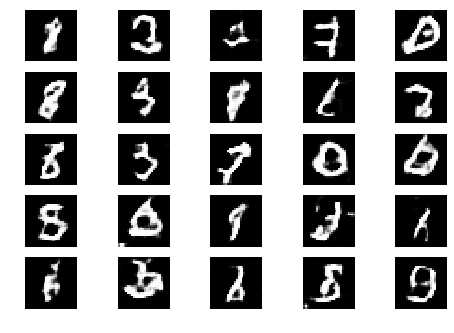

Epoch 1 Batch 101/1875 [D loss: 0.589885, acc.: 71.88%] [G loss: 0.987627]


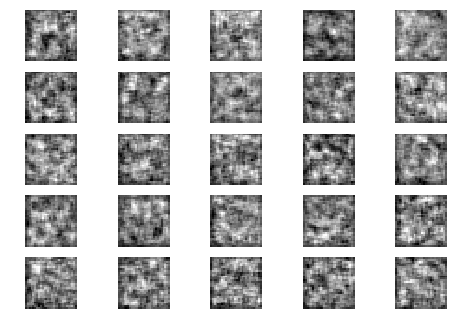

Epoch 1 Batch 102/1875 [D loss: 0.623010, acc.: 56.25%] [G loss: 1.216676]


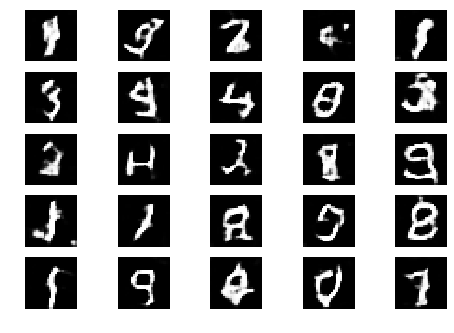

Epoch 1 Batch 103/1875 [D loss: 0.657620, acc.: 62.50%] [G loss: 1.212866]
Epoch 1 Batch 104/1875 [D loss: 0.498359, acc.: 81.25%] [G loss: 1.201202]
Epoch 1 Batch 105/1875 [D loss: 0.774431, acc.: 56.25%] [G loss: 1.097526]
Epoch 1 Batch 106/1875 [D loss: 0.645154, acc.: 62.50%] [G loss: 1.141999]
Epoch 1 Batch 107/1875 [D loss: 0.535621, acc.: 75.00%] [G loss: 1.175309]
Epoch 1 Batch 108/1875 [D loss: 0.641210, acc.: 65.62%] [G loss: 1.102121]
Epoch 1 Batch 109/1875 [D loss: 0.644716, acc.: 65.62%] [G loss: 1.107392]
Epoch 1 Batch 110/1875 [D loss: 0.629515, acc.: 53.12%] [G loss: 1.270389]
Epoch 1 Batch 111/1875 [D loss: 0.754358, acc.: 43.75%] [G loss: 0.877561]
Epoch 1 Batch 112/1875 [D loss: 0.821103, acc.: 59.38%] [G loss: 0.898237]
Epoch 1 Batch 113/1875 [D loss: 0.679411, acc.: 59.38%] [G loss: 1.032372]
Epoch 1 Batch 114/1875 [D loss: 0.610376, acc.: 59.38%] [G loss: 1.095890]
Epoch 1 Batch 115/1875 [D loss: 0.575858, acc.: 68.75%] [G loss: 0.959521]
Epoch 1 Batch 116/1875 [D

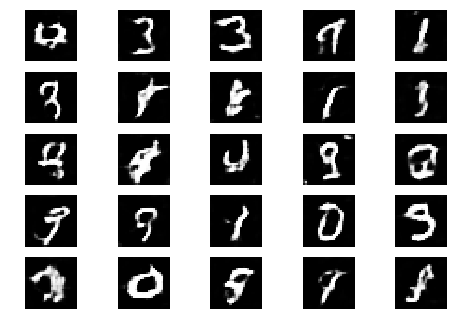

Epoch 1 Batch 201/1875 [D loss: 0.664209, acc.: 53.12%] [G loss: 0.983034]
Epoch 1 Batch 202/1875 [D loss: 0.690988, acc.: 62.50%] [G loss: 1.107311]


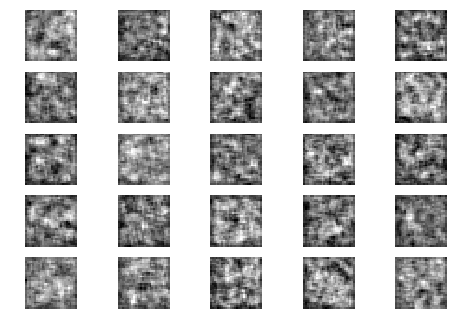

Epoch 1 Batch 203/1875 [D loss: 0.679959, acc.: 46.88%] [G loss: 0.977191]
Epoch 1 Batch 204/1875 [D loss: 0.680888, acc.: 62.50%] [G loss: 0.853155]


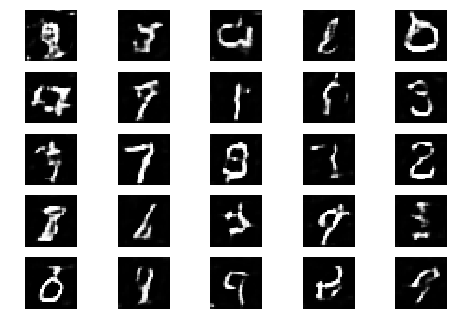

Epoch 1 Batch 205/1875 [D loss: 0.586353, acc.: 75.00%] [G loss: 1.078075]
Epoch 1 Batch 206/1875 [D loss: 0.522739, acc.: 78.12%] [G loss: 1.023355]
Epoch 1 Batch 207/1875 [D loss: 0.793726, acc.: 43.75%] [G loss: 0.998976]
Epoch 1 Batch 208/1875 [D loss: 0.656436, acc.: 62.50%] [G loss: 1.006612]
Epoch 1 Batch 209/1875 [D loss: 0.681331, acc.: 62.50%] [G loss: 0.837523]
Epoch 1 Batch 210/1875 [D loss: 0.524505, acc.: 75.00%] [G loss: 0.971993]
Epoch 1 Batch 211/1875 [D loss: 0.642635, acc.: 68.75%] [G loss: 1.360695]
Epoch 1 Batch 212/1875 [D loss: 0.655126, acc.: 59.38%] [G loss: 1.404213]
Epoch 1 Batch 213/1875 [D loss: 0.542373, acc.: 84.38%] [G loss: 1.290617]
Epoch 1 Batch 214/1875 [D loss: 0.614979, acc.: 56.25%] [G loss: 1.087038]
Epoch 1 Batch 215/1875 [D loss: 0.729605, acc.: 56.25%] [G loss: 0.994755]
Epoch 1 Batch 216/1875 [D loss: 0.737619, acc.: 50.00%] [G loss: 1.123316]
Epoch 1 Batch 217/1875 [D loss: 0.873594, acc.: 34.38%] [G loss: 1.009241]
Epoch 1 Batch 218/1875 [D

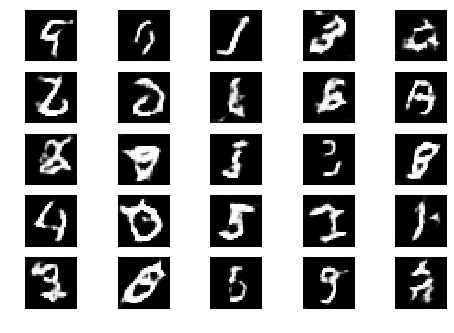

Epoch 1 Batch 301/1875 [D loss: 0.745902, acc.: 53.12%] [G loss: 0.997263]
Epoch 1 Batch 302/1875 [D loss: 0.522907, acc.: 78.12%] [G loss: 0.826626]
Epoch 1 Batch 303/1875 [D loss: 0.657749, acc.: 65.62%] [G loss: 1.256068]


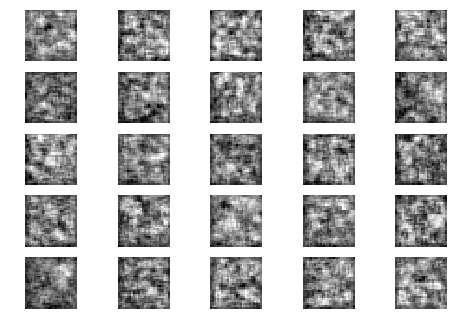

Epoch 1 Batch 304/1875 [D loss: 0.703262, acc.: 59.38%] [G loss: 0.977053]
Epoch 1 Batch 305/1875 [D loss: 0.662669, acc.: 62.50%] [G loss: 0.968189]
Epoch 1 Batch 306/1875 [D loss: 0.639567, acc.: 53.12%] [G loss: 1.068377]


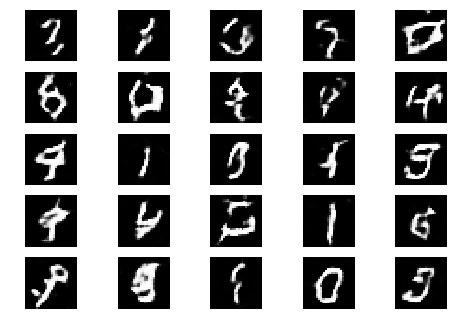

Epoch 1 Batch 307/1875 [D loss: 0.862702, acc.: 40.62%] [G loss: 0.802216]
Epoch 1 Batch 308/1875 [D loss: 0.837670, acc.: 46.88%] [G loss: 0.787528]
Epoch 1 Batch 309/1875 [D loss: 0.658648, acc.: 62.50%] [G loss: 1.057966]
Epoch 1 Batch 310/1875 [D loss: 0.670619, acc.: 56.25%] [G loss: 1.140251]
Epoch 1 Batch 311/1875 [D loss: 0.581196, acc.: 71.88%] [G loss: 1.210968]
Epoch 1 Batch 312/1875 [D loss: 0.480851, acc.: 81.25%] [G loss: 1.294676]
Epoch 1 Batch 313/1875 [D loss: 0.668006, acc.: 59.38%] [G loss: 1.045627]
Epoch 1 Batch 314/1875 [D loss: 0.772316, acc.: 43.75%] [G loss: 0.825971]
Epoch 1 Batch 315/1875 [D loss: 0.542150, acc.: 75.00%] [G loss: 1.110218]
Epoch 1 Batch 316/1875 [D loss: 0.615051, acc.: 68.75%] [G loss: 0.875764]
Epoch 1 Batch 317/1875 [D loss: 0.696073, acc.: 59.38%] [G loss: 1.115582]
Epoch 1 Batch 318/1875 [D loss: 0.676475, acc.: 56.25%] [G loss: 0.944067]
Epoch 1 Batch 319/1875 [D loss: 0.763643, acc.: 50.00%] [G loss: 0.768715]
Epoch 1 Batch 320/1875 [D

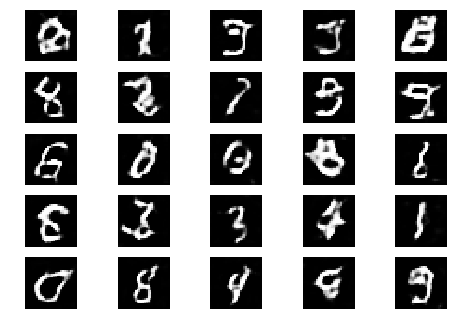

Epoch 1 Batch 401/1875 [D loss: 0.538388, acc.: 75.00%] [G loss: 1.193444]
Epoch 1 Batch 402/1875 [D loss: 0.705531, acc.: 50.00%] [G loss: 1.086548]
Epoch 1 Batch 403/1875 [D loss: 0.560872, acc.: 65.62%] [G loss: 0.935123]
Epoch 1 Batch 404/1875 [D loss: 0.758089, acc.: 50.00%] [G loss: 0.885085]


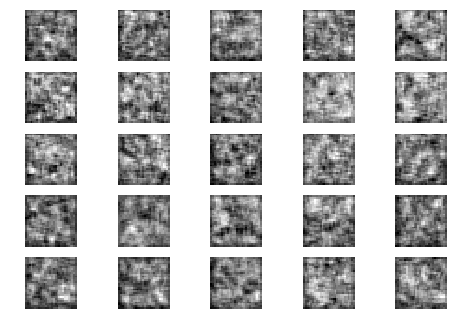

Epoch 1 Batch 405/1875 [D loss: 0.759030, acc.: 50.00%] [G loss: 1.189200]
Epoch 1 Batch 406/1875 [D loss: 0.788287, acc.: 46.88%] [G loss: 1.054101]
Epoch 1 Batch 407/1875 [D loss: 0.525808, acc.: 78.12%] [G loss: 0.985706]
Epoch 1 Batch 408/1875 [D loss: 0.663752, acc.: 62.50%] [G loss: 0.857404]


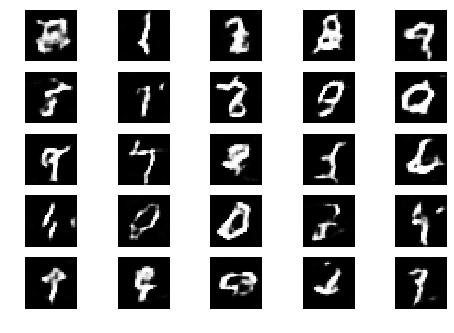

Epoch 1 Batch 409/1875 [D loss: 0.735137, acc.: 59.38%] [G loss: 0.906121]
Epoch 1 Batch 410/1875 [D loss: 0.779377, acc.: 50.00%] [G loss: 0.680640]
Epoch 1 Batch 411/1875 [D loss: 0.566819, acc.: 65.62%] [G loss: 1.071915]
Epoch 1 Batch 412/1875 [D loss: 0.632277, acc.: 68.75%] [G loss: 1.228907]
Epoch 1 Batch 413/1875 [D loss: 0.679533, acc.: 46.88%] [G loss: 0.869232]
Epoch 1 Batch 414/1875 [D loss: 0.658148, acc.: 56.25%] [G loss: 1.076630]
Epoch 1 Batch 415/1875 [D loss: 0.730065, acc.: 56.25%] [G loss: 1.100260]
Epoch 1 Batch 416/1875 [D loss: 0.651567, acc.: 53.12%] [G loss: 1.119051]
Epoch 1 Batch 417/1875 [D loss: 0.777487, acc.: 34.38%] [G loss: 1.047446]
Epoch 1 Batch 418/1875 [D loss: 0.659088, acc.: 56.25%] [G loss: 1.008062]
Epoch 1 Batch 419/1875 [D loss: 0.729707, acc.: 50.00%] [G loss: 0.808810]
Epoch 1 Batch 420/1875 [D loss: 0.448693, acc.: 84.38%] [G loss: 0.958844]
Epoch 1 Batch 421/1875 [D loss: 0.533942, acc.: 75.00%] [G loss: 1.023307]
Epoch 1 Batch 422/1875 [D

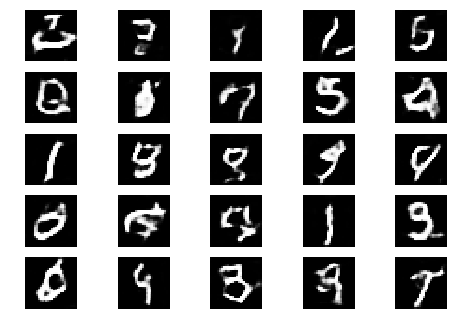

Epoch 1 Batch 501/1875 [D loss: 0.541590, acc.: 65.62%] [G loss: 1.028114]
Epoch 1 Batch 502/1875 [D loss: 0.872103, acc.: 40.62%] [G loss: 0.922745]
Epoch 1 Batch 503/1875 [D loss: 0.651275, acc.: 62.50%] [G loss: 1.159723]
Epoch 1 Batch 504/1875 [D loss: 0.680936, acc.: 59.38%] [G loss: 1.418957]
Epoch 1 Batch 505/1875 [D loss: 0.616302, acc.: 59.38%] [G loss: 0.873222]


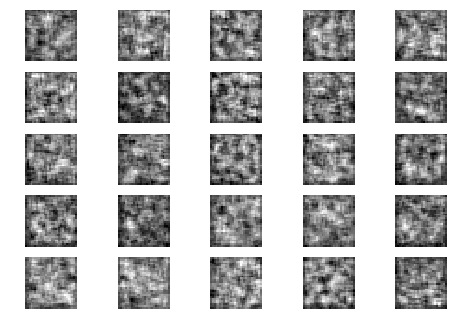

Epoch 1 Batch 506/1875 [D loss: 0.645379, acc.: 62.50%] [G loss: 0.941184]
Epoch 1 Batch 507/1875 [D loss: 0.783936, acc.: 43.75%] [G loss: 1.094944]
Epoch 1 Batch 508/1875 [D loss: 0.588147, acc.: 78.12%] [G loss: 1.114945]
Epoch 1 Batch 509/1875 [D loss: 0.557716, acc.: 62.50%] [G loss: 1.150263]
Epoch 1 Batch 510/1875 [D loss: 0.584722, acc.: 62.50%] [G loss: 1.164265]


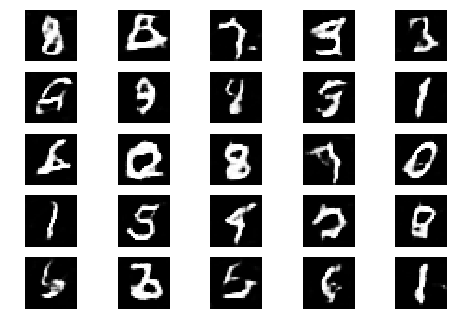

Epoch 1 Batch 511/1875 [D loss: 0.782183, acc.: 50.00%] [G loss: 1.136651]
Epoch 1 Batch 512/1875 [D loss: 0.724664, acc.: 53.12%] [G loss: 1.026652]
Epoch 1 Batch 513/1875 [D loss: 0.673733, acc.: 59.38%] [G loss: 1.133562]
Epoch 1 Batch 514/1875 [D loss: 0.748562, acc.: 50.00%] [G loss: 0.966508]
Epoch 1 Batch 515/1875 [D loss: 0.694225, acc.: 56.25%] [G loss: 0.934228]
Epoch 1 Batch 516/1875 [D loss: 0.737385, acc.: 50.00%] [G loss: 0.927569]
Epoch 1 Batch 517/1875 [D loss: 0.617457, acc.: 71.88%] [G loss: 0.893076]
Epoch 1 Batch 518/1875 [D loss: 0.658004, acc.: 71.88%] [G loss: 0.830072]
Epoch 1 Batch 519/1875 [D loss: 0.580660, acc.: 71.88%] [G loss: 0.952294]
Epoch 1 Batch 520/1875 [D loss: 0.659493, acc.: 59.38%] [G loss: 0.939875]
Epoch 1 Batch 521/1875 [D loss: 0.630867, acc.: 68.75%] [G loss: 0.891973]
Epoch 1 Batch 522/1875 [D loss: 0.816191, acc.: 46.88%] [G loss: 0.904222]
Epoch 1 Batch 523/1875 [D loss: 0.676629, acc.: 65.62%] [G loss: 0.987627]
Epoch 1 Batch 524/1875 [D

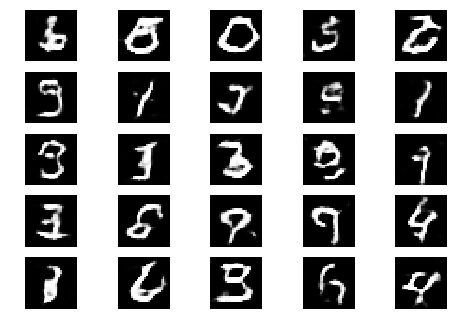

Epoch 1 Batch 601/1875 [D loss: 0.840111, acc.: 46.88%] [G loss: 0.935449]
Epoch 1 Batch 602/1875 [D loss: 0.665048, acc.: 65.62%] [G loss: 1.030583]
Epoch 1 Batch 603/1875 [D loss: 0.565360, acc.: 71.88%] [G loss: 1.080042]
Epoch 1 Batch 604/1875 [D loss: 0.608050, acc.: 62.50%] [G loss: 1.185735]
Epoch 1 Batch 605/1875 [D loss: 0.507767, acc.: 75.00%] [G loss: 1.316857]
Epoch 1 Batch 606/1875 [D loss: 0.580021, acc.: 59.38%] [G loss: 1.444592]


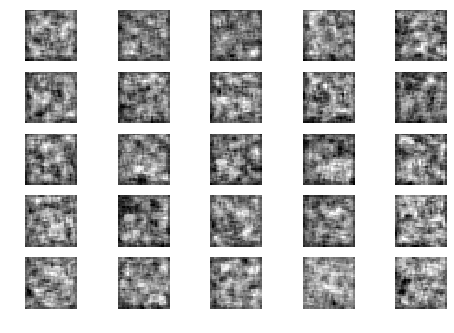

Epoch 1 Batch 607/1875 [D loss: 0.784778, acc.: 50.00%] [G loss: 0.919212]
Epoch 1 Batch 608/1875 [D loss: 0.710897, acc.: 59.38%] [G loss: 0.891217]
Epoch 1 Batch 609/1875 [D loss: 0.753332, acc.: 40.62%] [G loss: 1.026070]
Epoch 1 Batch 610/1875 [D loss: 0.754472, acc.: 53.12%] [G loss: 0.901678]
Epoch 1 Batch 611/1875 [D loss: 0.612981, acc.: 71.88%] [G loss: 1.134004]
Epoch 1 Batch 612/1875 [D loss: 0.730473, acc.: 53.12%] [G loss: 0.965325]


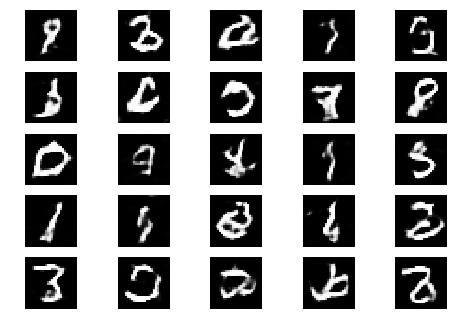

Epoch 1 Batch 613/1875 [D loss: 0.562923, acc.: 68.75%] [G loss: 1.087721]
Epoch 1 Batch 614/1875 [D loss: 0.675457, acc.: 68.75%] [G loss: 0.890162]
Epoch 1 Batch 615/1875 [D loss: 0.585723, acc.: 71.88%] [G loss: 0.988665]
Epoch 1 Batch 616/1875 [D loss: 0.992589, acc.: 21.88%] [G loss: 1.002904]
Epoch 1 Batch 617/1875 [D loss: 0.559709, acc.: 62.50%] [G loss: 1.196238]
Epoch 1 Batch 618/1875 [D loss: 0.581690, acc.: 71.88%] [G loss: 1.165305]
Epoch 1 Batch 619/1875 [D loss: 0.736558, acc.: 50.00%] [G loss: 1.016641]
Epoch 1 Batch 620/1875 [D loss: 0.712588, acc.: 56.25%] [G loss: 1.168931]
Epoch 1 Batch 621/1875 [D loss: 0.679253, acc.: 59.38%] [G loss: 0.823964]
Epoch 1 Batch 622/1875 [D loss: 0.584287, acc.: 65.62%] [G loss: 1.090992]
Epoch 1 Batch 623/1875 [D loss: 0.733492, acc.: 62.50%] [G loss: 0.840459]
Epoch 1 Batch 624/1875 [D loss: 0.774046, acc.: 50.00%] [G loss: 0.854743]
Epoch 1 Batch 625/1875 [D loss: 0.547784, acc.: 71.88%] [G loss: 0.913335]
Epoch 1 Batch 626/1875 [D

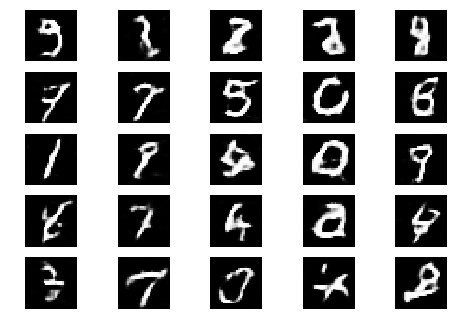

Epoch 1 Batch 701/1875 [D loss: 0.525365, acc.: 71.88%] [G loss: 1.060264]
Epoch 1 Batch 702/1875 [D loss: 0.608512, acc.: 59.38%] [G loss: 1.007470]
Epoch 1 Batch 703/1875 [D loss: 0.796982, acc.: 43.75%] [G loss: 1.006082]
Epoch 1 Batch 704/1875 [D loss: 0.702360, acc.: 50.00%] [G loss: 0.952577]
Epoch 1 Batch 705/1875 [D loss: 0.673678, acc.: 53.12%] [G loss: 1.021912]
Epoch 1 Batch 706/1875 [D loss: 0.725615, acc.: 71.88%] [G loss: 0.985360]
Epoch 1 Batch 707/1875 [D loss: 0.569474, acc.: 65.62%] [G loss: 0.977355]


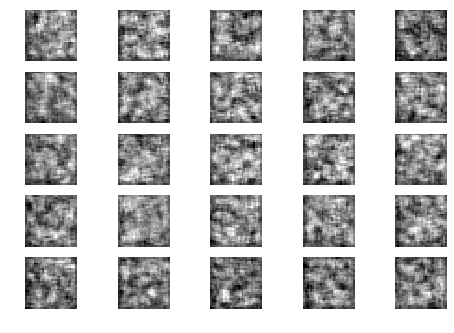

Epoch 1 Batch 708/1875 [D loss: 0.705914, acc.: 59.38%] [G loss: 1.146258]
Epoch 1 Batch 709/1875 [D loss: 0.673205, acc.: 65.62%] [G loss: 0.923943]
Epoch 1 Batch 710/1875 [D loss: 0.589499, acc.: 68.75%] [G loss: 1.078985]
Epoch 1 Batch 711/1875 [D loss: 0.564470, acc.: 71.88%] [G loss: 1.013693]
Epoch 1 Batch 712/1875 [D loss: 0.697249, acc.: 46.88%] [G loss: 1.161742]
Epoch 1 Batch 713/1875 [D loss: 0.780568, acc.: 46.88%] [G loss: 0.959092]
Epoch 1 Batch 714/1875 [D loss: 0.757560, acc.: 50.00%] [G loss: 1.038051]


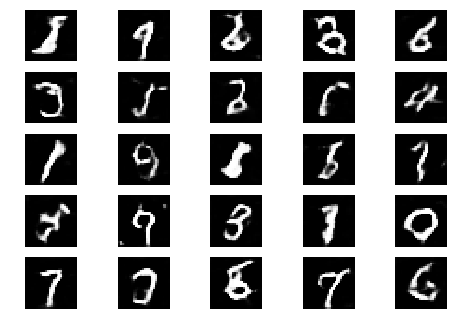

Epoch 1 Batch 715/1875 [D loss: 0.709482, acc.: 50.00%] [G loss: 1.239647]
Epoch 1 Batch 716/1875 [D loss: 0.708620, acc.: 50.00%] [G loss: 0.923687]
Epoch 1 Batch 717/1875 [D loss: 0.807595, acc.: 43.75%] [G loss: 1.033814]
Epoch 1 Batch 718/1875 [D loss: 0.728625, acc.: 62.50%] [G loss: 0.928364]
Epoch 1 Batch 719/1875 [D loss: 0.655031, acc.: 65.62%] [G loss: 0.809290]
Epoch 1 Batch 720/1875 [D loss: 0.674574, acc.: 53.12%] [G loss: 0.811845]
Epoch 1 Batch 721/1875 [D loss: 0.750690, acc.: 56.25%] [G loss: 1.077670]
Epoch 1 Batch 722/1875 [D loss: 0.729722, acc.: 53.12%] [G loss: 1.082010]
Epoch 1 Batch 723/1875 [D loss: 0.928981, acc.: 37.50%] [G loss: 0.949815]
Epoch 1 Batch 724/1875 [D loss: 0.777791, acc.: 53.12%] [G loss: 1.010301]
Epoch 1 Batch 725/1875 [D loss: 0.673766, acc.: 65.62%] [G loss: 0.951150]
Epoch 1 Batch 726/1875 [D loss: 0.617534, acc.: 65.62%] [G loss: 0.995196]
Epoch 1 Batch 727/1875 [D loss: 0.631419, acc.: 59.38%] [G loss: 0.984053]
Epoch 1 Batch 728/1875 [D

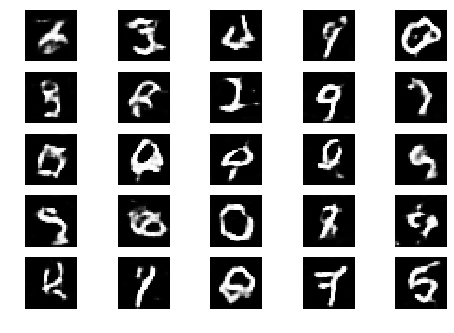

Epoch 1 Batch 801/1875 [D loss: 0.612538, acc.: 62.50%] [G loss: 1.013199]
Epoch 1 Batch 802/1875 [D loss: 0.593126, acc.: 65.62%] [G loss: 1.060895]
Epoch 1 Batch 803/1875 [D loss: 0.527776, acc.: 81.25%] [G loss: 0.969605]
Epoch 1 Batch 804/1875 [D loss: 0.671416, acc.: 53.12%] [G loss: 0.918778]
Epoch 1 Batch 805/1875 [D loss: 0.605830, acc.: 65.62%] [G loss: 0.741653]
Epoch 1 Batch 806/1875 [D loss: 0.682487, acc.: 50.00%] [G loss: 0.843397]
Epoch 1 Batch 807/1875 [D loss: 0.689427, acc.: 68.75%] [G loss: 1.040203]
Epoch 1 Batch 808/1875 [D loss: 0.547432, acc.: 71.88%] [G loss: 0.997579]


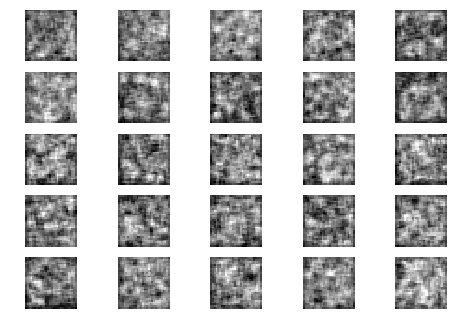

Epoch 1 Batch 809/1875 [D loss: 0.620634, acc.: 65.62%] [G loss: 0.748678]
Epoch 1 Batch 810/1875 [D loss: 0.573103, acc.: 75.00%] [G loss: 0.910650]
Epoch 1 Batch 811/1875 [D loss: 0.769678, acc.: 53.12%] [G loss: 1.077209]
Epoch 1 Batch 812/1875 [D loss: 0.632826, acc.: 65.62%] [G loss: 1.115602]
Epoch 1 Batch 813/1875 [D loss: 0.664477, acc.: 53.12%] [G loss: 1.170270]
Epoch 1 Batch 814/1875 [D loss: 0.728582, acc.: 53.12%] [G loss: 1.288406]
Epoch 1 Batch 815/1875 [D loss: 0.786691, acc.: 56.25%] [G loss: 1.151976]
Epoch 1 Batch 816/1875 [D loss: 0.691811, acc.: 59.38%] [G loss: 1.108437]


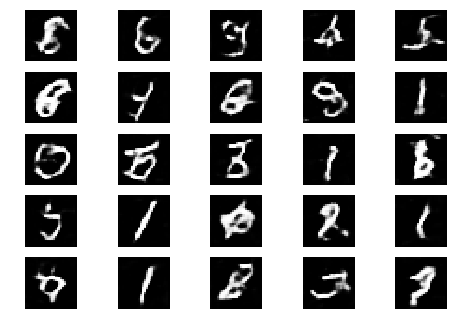

Epoch 1 Batch 817/1875 [D loss: 0.842284, acc.: 50.00%] [G loss: 1.050642]
Epoch 1 Batch 818/1875 [D loss: 0.651960, acc.: 62.50%] [G loss: 0.908684]
Epoch 1 Batch 819/1875 [D loss: 0.621359, acc.: 65.62%] [G loss: 1.070710]
Epoch 1 Batch 820/1875 [D loss: 0.611125, acc.: 68.75%] [G loss: 0.911479]
Epoch 1 Batch 821/1875 [D loss: 0.765821, acc.: 43.75%] [G loss: 1.089903]
Epoch 1 Batch 822/1875 [D loss: 0.529442, acc.: 78.12%] [G loss: 0.953193]
Epoch 1 Batch 823/1875 [D loss: 0.778161, acc.: 50.00%] [G loss: 1.174222]
Epoch 1 Batch 824/1875 [D loss: 0.641289, acc.: 62.50%] [G loss: 1.130986]
Epoch 1 Batch 825/1875 [D loss: 0.589447, acc.: 68.75%] [G loss: 1.020758]
Epoch 1 Batch 826/1875 [D loss: 0.612043, acc.: 65.62%] [G loss: 1.180269]
Epoch 1 Batch 827/1875 [D loss: 0.668432, acc.: 56.25%] [G loss: 0.887396]
Epoch 1 Batch 828/1875 [D loss: 0.527027, acc.: 81.25%] [G loss: 1.020873]
Epoch 1 Batch 829/1875 [D loss: 0.615082, acc.: 68.75%] [G loss: 1.017423]
Epoch 1 Batch 830/1875 [D

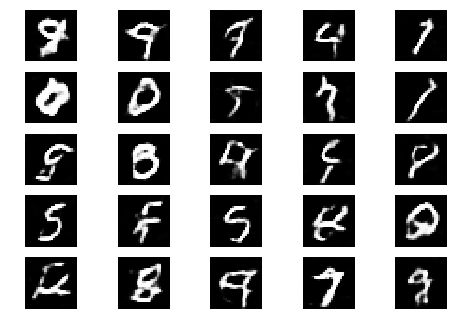

Epoch 1 Batch 901/1875 [D loss: 0.628401, acc.: 59.38%] [G loss: 1.086521]
Epoch 1 Batch 902/1875 [D loss: 0.848544, acc.: 34.38%] [G loss: 0.919764]
Epoch 1 Batch 903/1875 [D loss: 0.736389, acc.: 59.38%] [G loss: 0.864774]
Epoch 1 Batch 904/1875 [D loss: 0.670751, acc.: 62.50%] [G loss: 0.930618]
Epoch 1 Batch 905/1875 [D loss: 0.837893, acc.: 46.88%] [G loss: 0.919008]
Epoch 1 Batch 906/1875 [D loss: 0.637417, acc.: 59.38%] [G loss: 0.845452]
Epoch 1 Batch 907/1875 [D loss: 0.749820, acc.: 59.38%] [G loss: 1.023506]
Epoch 1 Batch 908/1875 [D loss: 0.730569, acc.: 59.38%] [G loss: 0.849553]
Epoch 1 Batch 909/1875 [D loss: 0.633152, acc.: 71.88%] [G loss: 0.934845]


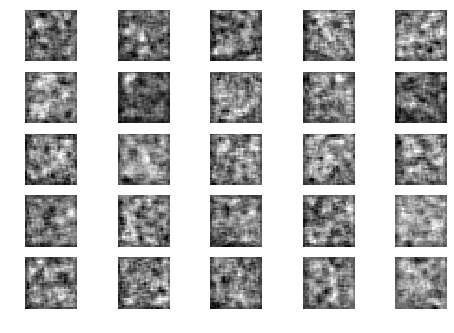

Epoch 1 Batch 910/1875 [D loss: 0.667172, acc.: 59.38%] [G loss: 0.787015]
Epoch 1 Batch 911/1875 [D loss: 0.717369, acc.: 56.25%] [G loss: 0.776150]
Epoch 1 Batch 912/1875 [D loss: 0.575665, acc.: 71.88%] [G loss: 0.978897]
Epoch 1 Batch 913/1875 [D loss: 0.744989, acc.: 43.75%] [G loss: 0.829646]
Epoch 1 Batch 914/1875 [D loss: 0.652216, acc.: 68.75%] [G loss: 0.925842]
Epoch 1 Batch 915/1875 [D loss: 0.568805, acc.: 68.75%] [G loss: 1.000117]
Epoch 1 Batch 916/1875 [D loss: 0.656932, acc.: 62.50%] [G loss: 0.876809]
Epoch 1 Batch 917/1875 [D loss: 0.570618, acc.: 59.38%] [G loss: 1.036594]
Epoch 1 Batch 918/1875 [D loss: 0.749660, acc.: 56.25%] [G loss: 1.082177]


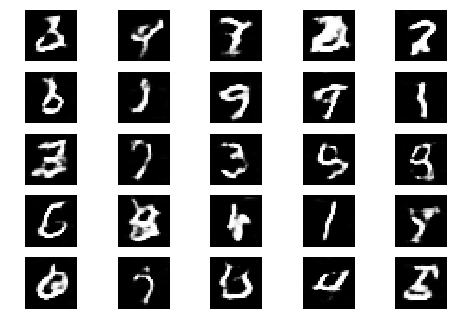

Epoch 1 Batch 919/1875 [D loss: 0.870447, acc.: 50.00%] [G loss: 1.112709]
Epoch 1 Batch 920/1875 [D loss: 0.729401, acc.: 50.00%] [G loss: 1.073242]
Epoch 1 Batch 921/1875 [D loss: 0.713928, acc.: 46.88%] [G loss: 0.948837]
Epoch 1 Batch 922/1875 [D loss: 0.731382, acc.: 50.00%] [G loss: 1.017606]
Epoch 1 Batch 923/1875 [D loss: 0.586800, acc.: 68.75%] [G loss: 0.863778]
Epoch 1 Batch 924/1875 [D loss: 0.632858, acc.: 68.75%] [G loss: 0.810822]
Epoch 1 Batch 925/1875 [D loss: 0.703392, acc.: 46.88%] [G loss: 1.046072]
Epoch 1 Batch 926/1875 [D loss: 0.709947, acc.: 50.00%] [G loss: 1.022338]
Epoch 1 Batch 927/1875 [D loss: 0.689842, acc.: 53.12%] [G loss: 0.904509]
Epoch 1 Batch 928/1875 [D loss: 0.591926, acc.: 81.25%] [G loss: 0.913416]
Epoch 1 Batch 929/1875 [D loss: 0.723829, acc.: 56.25%] [G loss: 1.006873]
Epoch 1 Batch 930/1875 [D loss: 0.692243, acc.: 68.75%] [G loss: 1.055134]
Epoch 1 Batch 931/1875 [D loss: 0.755039, acc.: 40.62%] [G loss: 1.163906]
Epoch 1 Batch 932/1875 [D

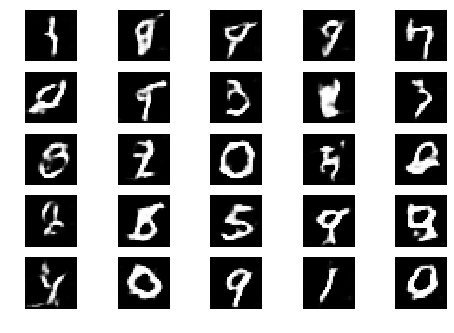

Epoch 1 Batch 1001/1875 [D loss: 0.431569, acc.: 87.50%] [G loss: 0.904599]
Epoch 1 Batch 1002/1875 [D loss: 0.820998, acc.: 43.75%] [G loss: 0.696431]
Epoch 1 Batch 1003/1875 [D loss: 0.578197, acc.: 71.88%] [G loss: 0.677435]
Epoch 1 Batch 1004/1875 [D loss: 0.575279, acc.: 65.62%] [G loss: 0.891565]
Epoch 1 Batch 1005/1875 [D loss: 0.681106, acc.: 53.12%] [G loss: 0.873030]
Epoch 1 Batch 1006/1875 [D loss: 0.554056, acc.: 75.00%] [G loss: 0.936047]
Epoch 1 Batch 1007/1875 [D loss: 0.593491, acc.: 65.62%] [G loss: 0.976363]
Epoch 1 Batch 1008/1875 [D loss: 0.670614, acc.: 56.25%] [G loss: 0.826083]
Epoch 1 Batch 1009/1875 [D loss: 0.697337, acc.: 62.50%] [G loss: 1.018758]
Epoch 1 Batch 1010/1875 [D loss: 0.763229, acc.: 50.00%] [G loss: 0.842988]


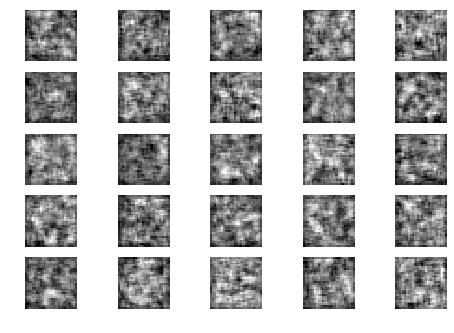

Epoch 1 Batch 1011/1875 [D loss: 0.751733, acc.: 50.00%] [G loss: 0.972032]
Epoch 1 Batch 1012/1875 [D loss: 0.679654, acc.: 53.12%] [G loss: 1.090509]
Epoch 1 Batch 1013/1875 [D loss: 0.752799, acc.: 53.12%] [G loss: 0.813283]
Epoch 1 Batch 1014/1875 [D loss: 0.655067, acc.: 53.12%] [G loss: 1.152395]
Epoch 1 Batch 1015/1875 [D loss: 0.729589, acc.: 43.75%] [G loss: 0.863159]
Epoch 1 Batch 1016/1875 [D loss: 0.528037, acc.: 84.38%] [G loss: 0.914389]
Epoch 1 Batch 1017/1875 [D loss: 0.742750, acc.: 50.00%] [G loss: 0.875897]
Epoch 1 Batch 1018/1875 [D loss: 0.596479, acc.: 68.75%] [G loss: 1.055116]
Epoch 1 Batch 1019/1875 [D loss: 0.605790, acc.: 65.62%] [G loss: 1.070059]
Epoch 1 Batch 1020/1875 [D loss: 0.746336, acc.: 56.25%] [G loss: 1.065656]


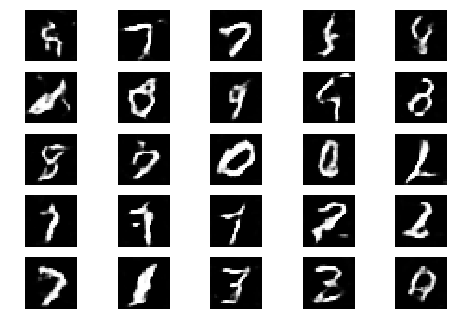

Epoch 1 Batch 1021/1875 [D loss: 0.757890, acc.: 43.75%] [G loss: 0.883368]
Epoch 1 Batch 1022/1875 [D loss: 0.553027, acc.: 71.88%] [G loss: 1.080981]
Epoch 1 Batch 1023/1875 [D loss: 0.605167, acc.: 75.00%] [G loss: 1.071906]
Epoch 1 Batch 1024/1875 [D loss: 0.567519, acc.: 71.88%] [G loss: 1.011147]
Epoch 1 Batch 1025/1875 [D loss: 0.736128, acc.: 56.25%] [G loss: 0.828295]
Epoch 1 Batch 1026/1875 [D loss: 0.677984, acc.: 50.00%] [G loss: 1.032969]
Epoch 1 Batch 1027/1875 [D loss: 0.730189, acc.: 50.00%] [G loss: 0.956086]
Epoch 1 Batch 1028/1875 [D loss: 0.556450, acc.: 75.00%] [G loss: 1.116624]
Epoch 1 Batch 1029/1875 [D loss: 0.615869, acc.: 62.50%] [G loss: 0.983517]
Epoch 1 Batch 1030/1875 [D loss: 0.632061, acc.: 62.50%] [G loss: 0.964110]
Epoch 1 Batch 1031/1875 [D loss: 0.586122, acc.: 65.62%] [G loss: 0.991263]
Epoch 1 Batch 1032/1875 [D loss: 0.575082, acc.: 75.00%] [G loss: 0.733406]
Epoch 1 Batch 1033/1875 [D loss: 0.696649, acc.: 62.50%] [G loss: 0.887461]
Epoch 1 Batc

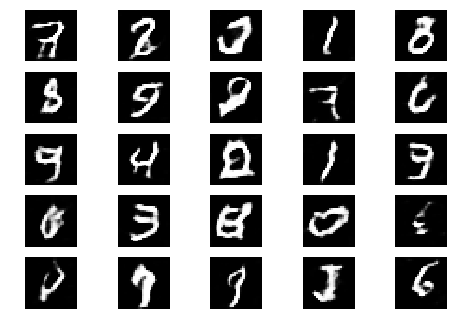

Epoch 1 Batch 1101/1875 [D loss: 0.701845, acc.: 53.12%] [G loss: 1.001295]
Epoch 1 Batch 1102/1875 [D loss: 0.590450, acc.: 59.38%] [G loss: 1.049081]
Epoch 1 Batch 1103/1875 [D loss: 0.686861, acc.: 56.25%] [G loss: 1.227327]
Epoch 1 Batch 1104/1875 [D loss: 0.615671, acc.: 56.25%] [G loss: 1.126341]
Epoch 1 Batch 1105/1875 [D loss: 0.632037, acc.: 65.62%] [G loss: 0.957586]
Epoch 1 Batch 1106/1875 [D loss: 0.714032, acc.: 53.12%] [G loss: 0.906453]
Epoch 1 Batch 1107/1875 [D loss: 0.588534, acc.: 62.50%] [G loss: 0.816092]
Epoch 1 Batch 1108/1875 [D loss: 0.542647, acc.: 68.75%] [G loss: 1.130555]
Epoch 1 Batch 1109/1875 [D loss: 0.622519, acc.: 62.50%] [G loss: 0.952428]
Epoch 1 Batch 1110/1875 [D loss: 0.780887, acc.: 62.50%] [G loss: 1.183429]
Epoch 1 Batch 1111/1875 [D loss: 0.635690, acc.: 62.50%] [G loss: 0.952745]


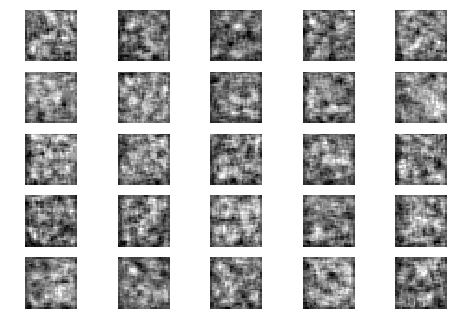

Epoch 1 Batch 1112/1875 [D loss: 0.555609, acc.: 68.75%] [G loss: 1.158121]
Epoch 1 Batch 1113/1875 [D loss: 0.701088, acc.: 59.38%] [G loss: 1.016230]
Epoch 1 Batch 1114/1875 [D loss: 0.750239, acc.: 53.12%] [G loss: 1.094623]
Epoch 1 Batch 1115/1875 [D loss: 0.654676, acc.: 56.25%] [G loss: 0.914721]
Epoch 1 Batch 1116/1875 [D loss: 0.583573, acc.: 75.00%] [G loss: 1.015461]
Epoch 1 Batch 1117/1875 [D loss: 0.732925, acc.: 62.50%] [G loss: 1.130947]
Epoch 1 Batch 1118/1875 [D loss: 0.619346, acc.: 62.50%] [G loss: 1.190741]
Epoch 1 Batch 1119/1875 [D loss: 0.732405, acc.: 46.88%] [G loss: 1.022527]
Epoch 1 Batch 1120/1875 [D loss: 0.805033, acc.: 43.75%] [G loss: 0.993966]
Epoch 1 Batch 1121/1875 [D loss: 0.604974, acc.: 65.62%] [G loss: 0.896505]
Epoch 1 Batch 1122/1875 [D loss: 0.573258, acc.: 75.00%] [G loss: 0.987082]


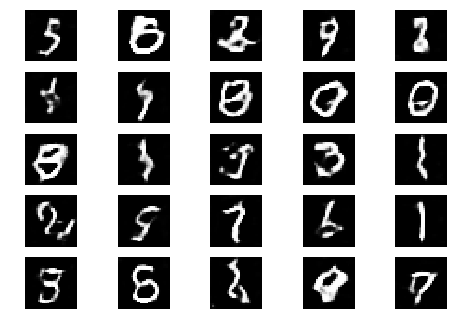

Epoch 1 Batch 1123/1875 [D loss: 0.559228, acc.: 75.00%] [G loss: 0.846203]
Epoch 1 Batch 1124/1875 [D loss: 0.682482, acc.: 59.38%] [G loss: 1.094848]
Epoch 1 Batch 1125/1875 [D loss: 0.686649, acc.: 53.12%] [G loss: 0.952086]
Epoch 1 Batch 1126/1875 [D loss: 0.592816, acc.: 68.75%] [G loss: 0.832013]
Epoch 1 Batch 1127/1875 [D loss: 0.663192, acc.: 62.50%] [G loss: 1.085233]
Epoch 1 Batch 1128/1875 [D loss: 0.715714, acc.: 56.25%] [G loss: 0.998593]
Epoch 1 Batch 1129/1875 [D loss: 0.531712, acc.: 71.88%] [G loss: 0.945943]
Epoch 1 Batch 1130/1875 [D loss: 0.628408, acc.: 71.88%] [G loss: 0.758444]
Epoch 1 Batch 1131/1875 [D loss: 0.707738, acc.: 59.38%] [G loss: 0.753886]
Epoch 1 Batch 1132/1875 [D loss: 0.577968, acc.: 65.62%] [G loss: 0.935860]
Epoch 1 Batch 1133/1875 [D loss: 0.608976, acc.: 65.62%] [G loss: 0.973465]
Epoch 1 Batch 1134/1875 [D loss: 0.627937, acc.: 65.62%] [G loss: 1.025505]
Epoch 1 Batch 1135/1875 [D loss: 0.699120, acc.: 53.12%] [G loss: 0.854359]
Epoch 1 Batc

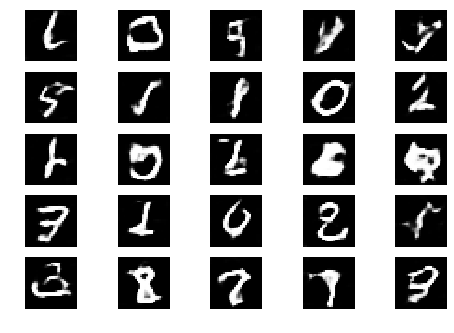

Epoch 1 Batch 1201/1875 [D loss: 0.789949, acc.: 43.75%] [G loss: 1.095959]
Epoch 1 Batch 1202/1875 [D loss: 0.634121, acc.: 68.75%] [G loss: 1.212870]
Epoch 1 Batch 1203/1875 [D loss: 0.618134, acc.: 59.38%] [G loss: 1.055986]
Epoch 1 Batch 1204/1875 [D loss: 0.637651, acc.: 65.62%] [G loss: 1.132203]
Epoch 1 Batch 1205/1875 [D loss: 0.775051, acc.: 50.00%] [G loss: 0.893285]
Epoch 1 Batch 1206/1875 [D loss: 0.563011, acc.: 78.12%] [G loss: 0.835391]
Epoch 1 Batch 1207/1875 [D loss: 0.606875, acc.: 68.75%] [G loss: 0.925404]
Epoch 1 Batch 1208/1875 [D loss: 0.672781, acc.: 53.12%] [G loss: 0.901870]
Epoch 1 Batch 1209/1875 [D loss: 0.666433, acc.: 65.62%] [G loss: 0.790650]
Epoch 1 Batch 1210/1875 [D loss: 0.684261, acc.: 62.50%] [G loss: 0.788835]
Epoch 1 Batch 1211/1875 [D loss: 0.604833, acc.: 65.62%] [G loss: 0.950978]
Epoch 1 Batch 1212/1875 [D loss: 0.655716, acc.: 68.75%] [G loss: 0.990263]


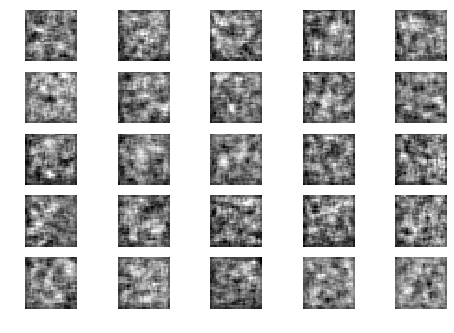

Epoch 1 Batch 1213/1875 [D loss: 0.556948, acc.: 71.88%] [G loss: 1.162786]
Epoch 1 Batch 1214/1875 [D loss: 0.830245, acc.: 40.62%] [G loss: 1.086898]
Epoch 1 Batch 1215/1875 [D loss: 0.875809, acc.: 37.50%] [G loss: 0.826351]
Epoch 1 Batch 1216/1875 [D loss: 0.777378, acc.: 40.62%] [G loss: 0.897632]
Epoch 1 Batch 1217/1875 [D loss: 0.658342, acc.: 59.38%] [G loss: 1.033997]
Epoch 1 Batch 1218/1875 [D loss: 0.634242, acc.: 68.75%] [G loss: 0.937438]
Epoch 1 Batch 1219/1875 [D loss: 0.610019, acc.: 71.88%] [G loss: 0.837418]
Epoch 1 Batch 1220/1875 [D loss: 0.530625, acc.: 78.12%] [G loss: 1.071136]
Epoch 1 Batch 1221/1875 [D loss: 0.794474, acc.: 46.88%] [G loss: 0.820008]
Epoch 1 Batch 1222/1875 [D loss: 0.768516, acc.: 56.25%] [G loss: 0.979512]
Epoch 1 Batch 1223/1875 [D loss: 0.739164, acc.: 56.25%] [G loss: 0.903931]
Epoch 1 Batch 1224/1875 [D loss: 0.674487, acc.: 68.75%] [G loss: 0.938391]


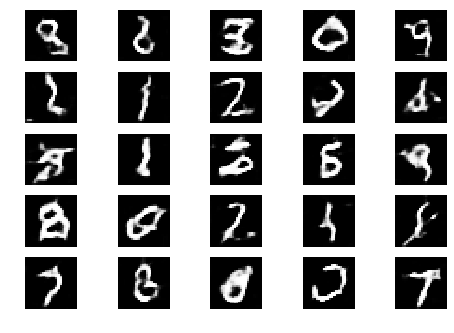

Epoch 1 Batch 1225/1875 [D loss: 0.711290, acc.: 62.50%] [G loss: 0.940623]
Epoch 1 Batch 1226/1875 [D loss: 0.697696, acc.: 53.12%] [G loss: 0.739169]
Epoch 1 Batch 1227/1875 [D loss: 0.755842, acc.: 46.88%] [G loss: 0.874631]
Epoch 1 Batch 1228/1875 [D loss: 0.633387, acc.: 59.38%] [G loss: 0.896753]
Epoch 1 Batch 1229/1875 [D loss: 0.659356, acc.: 71.88%] [G loss: 0.888051]
Epoch 1 Batch 1230/1875 [D loss: 0.570059, acc.: 68.75%] [G loss: 1.029913]
Epoch 1 Batch 1231/1875 [D loss: 0.677669, acc.: 62.50%] [G loss: 0.812185]
Epoch 1 Batch 1232/1875 [D loss: 0.644445, acc.: 56.25%] [G loss: 0.918574]
Epoch 1 Batch 1233/1875 [D loss: 0.593877, acc.: 62.50%] [G loss: 1.034176]
Epoch 1 Batch 1234/1875 [D loss: 0.632442, acc.: 65.62%] [G loss: 1.031444]
Epoch 1 Batch 1235/1875 [D loss: 0.709793, acc.: 56.25%] [G loss: 0.922871]
Epoch 1 Batch 1236/1875 [D loss: 0.639325, acc.: 59.38%] [G loss: 0.830750]
Epoch 1 Batch 1237/1875 [D loss: 0.733140, acc.: 43.75%] [G loss: 1.119383]
Epoch 1 Batc

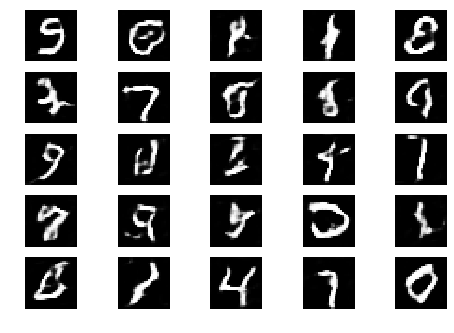

Epoch 1 Batch 1301/1875 [D loss: 0.720286, acc.: 56.25%] [G loss: 0.928202]
Epoch 1 Batch 1302/1875 [D loss: 0.613805, acc.: 68.75%] [G loss: 0.961395]
Epoch 1 Batch 1303/1875 [D loss: 0.580715, acc.: 68.75%] [G loss: 0.906476]
Epoch 1 Batch 1304/1875 [D loss: 0.608074, acc.: 68.75%] [G loss: 1.054145]
Epoch 1 Batch 1305/1875 [D loss: 0.513269, acc.: 81.25%] [G loss: 1.084728]
Epoch 1 Batch 1306/1875 [D loss: 0.764136, acc.: 50.00%] [G loss: 0.947484]
Epoch 1 Batch 1307/1875 [D loss: 0.653679, acc.: 71.88%] [G loss: 0.897977]
Epoch 1 Batch 1308/1875 [D loss: 0.505991, acc.: 68.75%] [G loss: 0.802306]
Epoch 1 Batch 1309/1875 [D loss: 0.560888, acc.: 71.88%] [G loss: 1.076745]
Epoch 1 Batch 1310/1875 [D loss: 0.601666, acc.: 71.88%] [G loss: 1.124857]
Epoch 1 Batch 1311/1875 [D loss: 0.753872, acc.: 50.00%] [G loss: 0.982247]
Epoch 1 Batch 1312/1875 [D loss: 0.612248, acc.: 65.62%] [G loss: 0.874915]
Epoch 1 Batch 1313/1875 [D loss: 0.734205, acc.: 65.62%] [G loss: 0.866932]


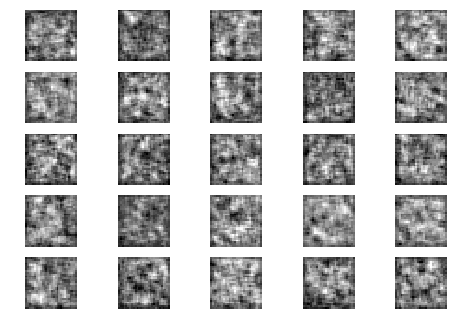

Epoch 1 Batch 1314/1875 [D loss: 0.555548, acc.: 68.75%] [G loss: 0.916166]
Epoch 1 Batch 1315/1875 [D loss: 0.581136, acc.: 68.75%] [G loss: 0.974904]
Epoch 1 Batch 1316/1875 [D loss: 0.626141, acc.: 53.12%] [G loss: 0.874009]
Epoch 1 Batch 1317/1875 [D loss: 0.599610, acc.: 68.75%] [G loss: 1.051855]
Epoch 1 Batch 1318/1875 [D loss: 0.642109, acc.: 68.75%] [G loss: 1.019840]
Epoch 1 Batch 1319/1875 [D loss: 0.680729, acc.: 53.12%] [G loss: 1.117509]
Epoch 1 Batch 1320/1875 [D loss: 0.697996, acc.: 65.62%] [G loss: 1.089754]
Epoch 1 Batch 1321/1875 [D loss: 0.717238, acc.: 59.38%] [G loss: 0.962221]
Epoch 1 Batch 1322/1875 [D loss: 0.645683, acc.: 65.62%] [G loss: 1.073262]
Epoch 1 Batch 1323/1875 [D loss: 0.715305, acc.: 56.25%] [G loss: 0.951622]
Epoch 1 Batch 1324/1875 [D loss: 0.782752, acc.: 46.88%] [G loss: 1.071907]
Epoch 1 Batch 1325/1875 [D loss: 0.632047, acc.: 68.75%] [G loss: 0.835008]
Epoch 1 Batch 1326/1875 [D loss: 0.750714, acc.: 56.25%] [G loss: 0.878482]


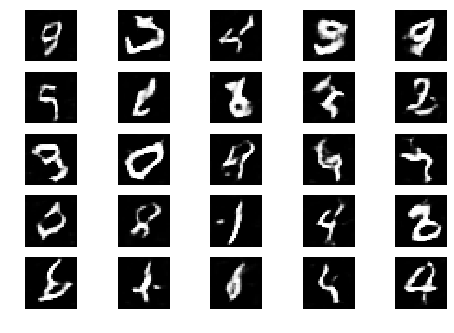

Epoch 1 Batch 1327/1875 [D loss: 0.676534, acc.: 53.12%] [G loss: 1.018559]
Epoch 1 Batch 1328/1875 [D loss: 0.655280, acc.: 65.62%] [G loss: 0.859323]
Epoch 1 Batch 1329/1875 [D loss: 0.599286, acc.: 68.75%] [G loss: 0.974472]
Epoch 1 Batch 1330/1875 [D loss: 0.647042, acc.: 56.25%] [G loss: 1.007018]
Epoch 1 Batch 1331/1875 [D loss: 0.776179, acc.: 59.38%] [G loss: 0.913316]
Epoch 1 Batch 1332/1875 [D loss: 0.558972, acc.: 59.38%] [G loss: 1.084374]
Epoch 1 Batch 1333/1875 [D loss: 0.543524, acc.: 75.00%] [G loss: 1.107547]
Epoch 1 Batch 1334/1875 [D loss: 0.722646, acc.: 46.88%] [G loss: 0.887394]
Epoch 1 Batch 1335/1875 [D loss: 0.702391, acc.: 53.12%] [G loss: 0.897441]
Epoch 1 Batch 1336/1875 [D loss: 0.675122, acc.: 59.38%] [G loss: 0.952778]
Epoch 1 Batch 1337/1875 [D loss: 0.731865, acc.: 56.25%] [G loss: 0.999952]
Epoch 1 Batch 1338/1875 [D loss: 0.664625, acc.: 62.50%] [G loss: 1.146786]
Epoch 1 Batch 1339/1875 [D loss: 0.785447, acc.: 50.00%] [G loss: 0.953895]
Epoch 1 Batc

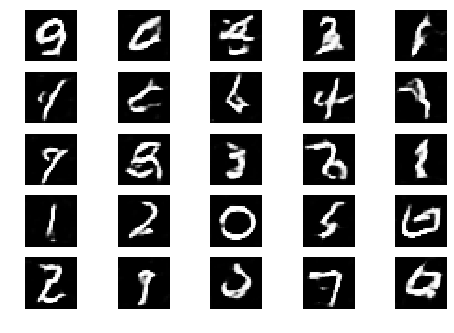

Epoch 1 Batch 1401/1875 [D loss: 0.687959, acc.: 59.38%] [G loss: 0.872296]
Epoch 1 Batch 1402/1875 [D loss: 0.643694, acc.: 56.25%] [G loss: 0.915456]
Epoch 1 Batch 1403/1875 [D loss: 0.650723, acc.: 62.50%] [G loss: 0.847997]
Epoch 1 Batch 1404/1875 [D loss: 0.692976, acc.: 59.38%] [G loss: 1.007239]
Epoch 1 Batch 1405/1875 [D loss: 0.643616, acc.: 62.50%] [G loss: 0.905681]
Epoch 1 Batch 1406/1875 [D loss: 0.660212, acc.: 53.12%] [G loss: 0.887067]
Epoch 1 Batch 1407/1875 [D loss: 0.703286, acc.: 53.12%] [G loss: 0.981099]
Epoch 1 Batch 1408/1875 [D loss: 0.701044, acc.: 59.38%] [G loss: 0.953773]
Epoch 1 Batch 1409/1875 [D loss: 0.837758, acc.: 40.62%] [G loss: 0.918999]
Epoch 1 Batch 1410/1875 [D loss: 0.735999, acc.: 53.12%] [G loss: 0.894445]
Epoch 1 Batch 1411/1875 [D loss: 0.610165, acc.: 65.62%] [G loss: 0.874779]
Epoch 1 Batch 1412/1875 [D loss: 0.592703, acc.: 62.50%] [G loss: 1.009759]
Epoch 1 Batch 1413/1875 [D loss: 0.490186, acc.: 93.75%] [G loss: 0.960769]
Epoch 1 Batc

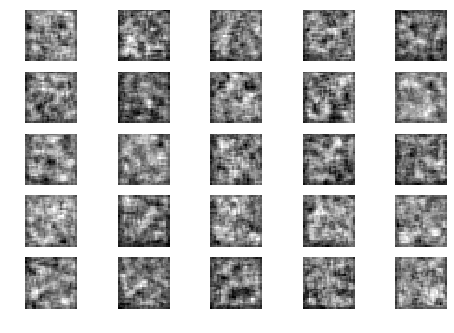

Epoch 1 Batch 1415/1875 [D loss: 0.689817, acc.: 56.25%] [G loss: 1.061125]
Epoch 1 Batch 1416/1875 [D loss: 0.566340, acc.: 71.88%] [G loss: 0.897291]
Epoch 1 Batch 1417/1875 [D loss: 0.791311, acc.: 50.00%] [G loss: 1.104780]
Epoch 1 Batch 1418/1875 [D loss: 0.639563, acc.: 65.62%] [G loss: 1.057817]
Epoch 1 Batch 1419/1875 [D loss: 0.634245, acc.: 68.75%] [G loss: 1.138381]
Epoch 1 Batch 1420/1875 [D loss: 0.612591, acc.: 62.50%] [G loss: 0.919879]
Epoch 1 Batch 1421/1875 [D loss: 0.636899, acc.: 62.50%] [G loss: 1.101184]
Epoch 1 Batch 1422/1875 [D loss: 0.623850, acc.: 68.75%] [G loss: 0.825899]
Epoch 1 Batch 1423/1875 [D loss: 0.697474, acc.: 53.12%] [G loss: 0.985444]
Epoch 1 Batch 1424/1875 [D loss: 0.616347, acc.: 71.88%] [G loss: 1.027602]
Epoch 1 Batch 1425/1875 [D loss: 0.453864, acc.: 81.25%] [G loss: 1.102929]
Epoch 1 Batch 1426/1875 [D loss: 0.592703, acc.: 71.88%] [G loss: 0.971523]
Epoch 1 Batch 1427/1875 [D loss: 0.811087, acc.: 31.25%] [G loss: 0.935379]
Epoch 1 Batc

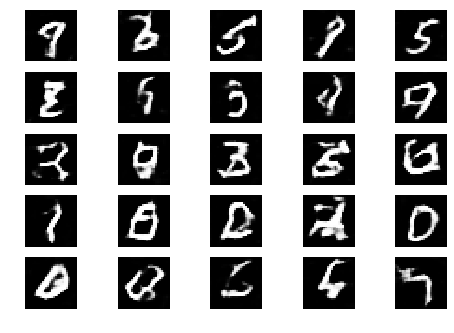

Epoch 1 Batch 1429/1875 [D loss: 0.670851, acc.: 65.62%] [G loss: 0.970135]
Epoch 1 Batch 1430/1875 [D loss: 0.671036, acc.: 62.50%] [G loss: 0.921359]
Epoch 1 Batch 1431/1875 [D loss: 0.696073, acc.: 56.25%] [G loss: 1.156003]
Epoch 1 Batch 1432/1875 [D loss: 0.642580, acc.: 59.38%] [G loss: 1.088395]
Epoch 1 Batch 1433/1875 [D loss: 0.658517, acc.: 62.50%] [G loss: 0.985360]
Epoch 1 Batch 1434/1875 [D loss: 0.766683, acc.: 40.62%] [G loss: 0.983725]
Epoch 1 Batch 1435/1875 [D loss: 0.824481, acc.: 40.62%] [G loss: 1.171818]
Epoch 1 Batch 1436/1875 [D loss: 0.687267, acc.: 56.25%] [G loss: 0.851259]
Epoch 1 Batch 1437/1875 [D loss: 0.673075, acc.: 68.75%] [G loss: 0.877504]
Epoch 1 Batch 1438/1875 [D loss: 0.567173, acc.: 75.00%] [G loss: 1.016790]
Epoch 1 Batch 1439/1875 [D loss: 0.552904, acc.: 75.00%] [G loss: 1.069993]
Epoch 1 Batch 1440/1875 [D loss: 0.589302, acc.: 75.00%] [G loss: 1.159651]
Epoch 1 Batch 1441/1875 [D loss: 0.636529, acc.: 59.38%] [G loss: 1.002051]
Epoch 1 Batc

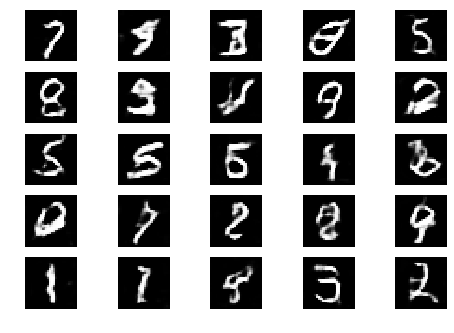

Epoch 1 Batch 1501/1875 [D loss: 0.592375, acc.: 65.62%] [G loss: 0.836065]
Epoch 1 Batch 1502/1875 [D loss: 0.608735, acc.: 65.62%] [G loss: 1.181339]
Epoch 1 Batch 1503/1875 [D loss: 0.504264, acc.: 81.25%] [G loss: 0.992020]
Epoch 1 Batch 1504/1875 [D loss: 0.585390, acc.: 65.62%] [G loss: 1.064568]
Epoch 1 Batch 1505/1875 [D loss: 0.640440, acc.: 68.75%] [G loss: 1.336805]
Epoch 1 Batch 1506/1875 [D loss: 0.863726, acc.: 37.50%] [G loss: 1.093019]
Epoch 1 Batch 1507/1875 [D loss: 0.575977, acc.: 68.75%] [G loss: 0.963083]
Epoch 1 Batch 1508/1875 [D loss: 0.709537, acc.: 56.25%] [G loss: 1.067881]
Epoch 1 Batch 1509/1875 [D loss: 0.975394, acc.: 28.12%] [G loss: 1.139961]
Epoch 1 Batch 1510/1875 [D loss: 0.635983, acc.: 59.38%] [G loss: 1.003869]
Epoch 1 Batch 1511/1875 [D loss: 0.886394, acc.: 34.38%] [G loss: 0.860823]
Epoch 1 Batch 1512/1875 [D loss: 0.558972, acc.: 62.50%] [G loss: 1.000932]
Epoch 1 Batch 1513/1875 [D loss: 0.578548, acc.: 71.88%] [G loss: 0.987433]
Epoch 1 Batc

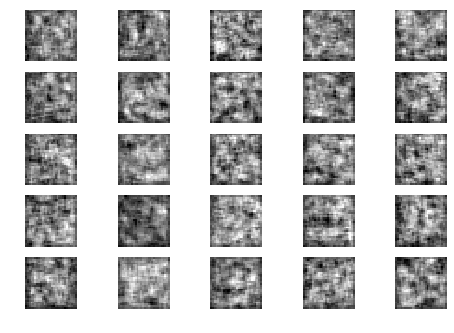

Epoch 1 Batch 1516/1875 [D loss: 0.655167, acc.: 59.38%] [G loss: 0.982150]
Epoch 1 Batch 1517/1875 [D loss: 0.587473, acc.: 75.00%] [G loss: 1.194142]
Epoch 1 Batch 1518/1875 [D loss: 0.745635, acc.: 50.00%] [G loss: 1.004189]
Epoch 1 Batch 1519/1875 [D loss: 0.622410, acc.: 65.62%] [G loss: 0.861865]
Epoch 1 Batch 1520/1875 [D loss: 0.555977, acc.: 78.12%] [G loss: 0.914383]
Epoch 1 Batch 1521/1875 [D loss: 0.634687, acc.: 56.25%] [G loss: 0.996291]
Epoch 1 Batch 1522/1875 [D loss: 0.663337, acc.: 53.12%] [G loss: 0.827935]
Epoch 1 Batch 1523/1875 [D loss: 0.622045, acc.: 68.75%] [G loss: 0.920412]
Epoch 1 Batch 1524/1875 [D loss: 0.588362, acc.: 65.62%] [G loss: 0.915648]
Epoch 1 Batch 1525/1875 [D loss: 0.729772, acc.: 53.12%] [G loss: 0.926740]
Epoch 1 Batch 1526/1875 [D loss: 0.801058, acc.: 40.62%] [G loss: 0.929484]
Epoch 1 Batch 1527/1875 [D loss: 0.631238, acc.: 65.62%] [G loss: 0.957967]
Epoch 1 Batch 1528/1875 [D loss: 0.468045, acc.: 78.12%] [G loss: 1.106335]
Epoch 1 Batc

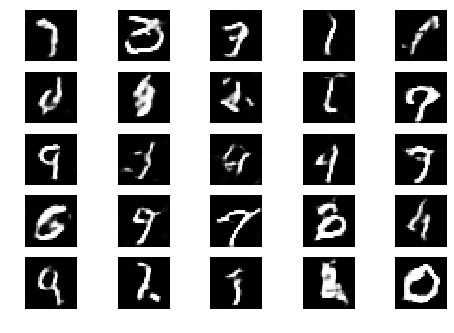

Epoch 1 Batch 1531/1875 [D loss: 0.659974, acc.: 68.75%] [G loss: 0.974317]
Epoch 1 Batch 1532/1875 [D loss: 0.688459, acc.: 59.38%] [G loss: 0.975753]
Epoch 1 Batch 1533/1875 [D loss: 0.627114, acc.: 65.62%] [G loss: 0.956812]
Epoch 1 Batch 1534/1875 [D loss: 0.677356, acc.: 62.50%] [G loss: 1.093570]
Epoch 1 Batch 1535/1875 [D loss: 0.790259, acc.: 56.25%] [G loss: 0.910567]
Epoch 1 Batch 1536/1875 [D loss: 0.819399, acc.: 53.12%] [G loss: 0.890647]
Epoch 1 Batch 1537/1875 [D loss: 0.831062, acc.: 37.50%] [G loss: 0.966330]
Epoch 1 Batch 1538/1875 [D loss: 0.688493, acc.: 53.12%] [G loss: 0.918288]
Epoch 1 Batch 1539/1875 [D loss: 0.630375, acc.: 65.62%] [G loss: 1.031353]
Epoch 1 Batch 1540/1875 [D loss: 0.711287, acc.: 56.25%] [G loss: 0.920869]
Epoch 1 Batch 1541/1875 [D loss: 0.625447, acc.: 71.88%] [G loss: 1.072633]
Epoch 1 Batch 1542/1875 [D loss: 0.748988, acc.: 59.38%] [G loss: 0.939359]
Epoch 1 Batch 1543/1875 [D loss: 0.708147, acc.: 53.12%] [G loss: 1.183647]
Epoch 1 Batc

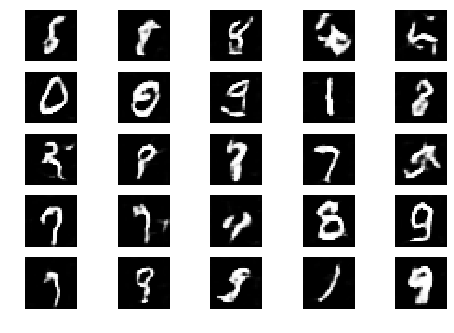

Epoch 1 Batch 1601/1875 [D loss: 0.512170, acc.: 75.00%] [G loss: 1.071949]
Epoch 1 Batch 1602/1875 [D loss: 0.691059, acc.: 50.00%] [G loss: 0.905261]
Epoch 1 Batch 1603/1875 [D loss: 0.674917, acc.: 62.50%] [G loss: 1.054072]
Epoch 1 Batch 1604/1875 [D loss: 0.789687, acc.: 46.88%] [G loss: 0.944230]
Epoch 1 Batch 1605/1875 [D loss: 0.591856, acc.: 71.88%] [G loss: 1.095318]
Epoch 1 Batch 1606/1875 [D loss: 0.707197, acc.: 62.50%] [G loss: 1.031011]
Epoch 1 Batch 1607/1875 [D loss: 0.564823, acc.: 59.38%] [G loss: 1.109102]
Epoch 1 Batch 1608/1875 [D loss: 0.681767, acc.: 53.12%] [G loss: 1.091402]
Epoch 1 Batch 1609/1875 [D loss: 0.676626, acc.: 53.12%] [G loss: 1.099443]
Epoch 1 Batch 1610/1875 [D loss: 0.657621, acc.: 68.75%] [G loss: 0.940839]
Epoch 1 Batch 1611/1875 [D loss: 0.676946, acc.: 62.50%] [G loss: 0.791137]
Epoch 1 Batch 1612/1875 [D loss: 0.582362, acc.: 75.00%] [G loss: 0.777100]
Epoch 1 Batch 1613/1875 [D loss: 0.800732, acc.: 50.00%] [G loss: 0.816399]
Epoch 1 Batc

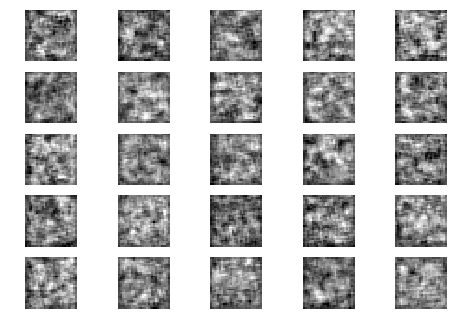

Epoch 1 Batch 1617/1875 [D loss: 0.721423, acc.: 50.00%] [G loss: 1.068042]
Epoch 1 Batch 1618/1875 [D loss: 0.716032, acc.: 59.38%] [G loss: 1.121320]
Epoch 1 Batch 1619/1875 [D loss: 0.762702, acc.: 40.62%] [G loss: 1.209713]
Epoch 1 Batch 1620/1875 [D loss: 0.580930, acc.: 75.00%] [G loss: 1.115271]
Epoch 1 Batch 1621/1875 [D loss: 0.677064, acc.: 59.38%] [G loss: 0.929772]
Epoch 1 Batch 1622/1875 [D loss: 0.718204, acc.: 56.25%] [G loss: 0.945108]
Epoch 1 Batch 1623/1875 [D loss: 0.774325, acc.: 46.88%] [G loss: 0.907054]
Epoch 1 Batch 1624/1875 [D loss: 0.651103, acc.: 68.75%] [G loss: 0.937823]
Epoch 1 Batch 1625/1875 [D loss: 0.701890, acc.: 53.12%] [G loss: 0.955654]
Epoch 1 Batch 1626/1875 [D loss: 0.688725, acc.: 53.12%] [G loss: 0.895348]
Epoch 1 Batch 1627/1875 [D loss: 0.571214, acc.: 65.62%] [G loss: 1.076987]
Epoch 1 Batch 1628/1875 [D loss: 0.667067, acc.: 56.25%] [G loss: 1.073273]
Epoch 1 Batch 1629/1875 [D loss: 0.691575, acc.: 50.00%] [G loss: 1.065124]
Epoch 1 Batc

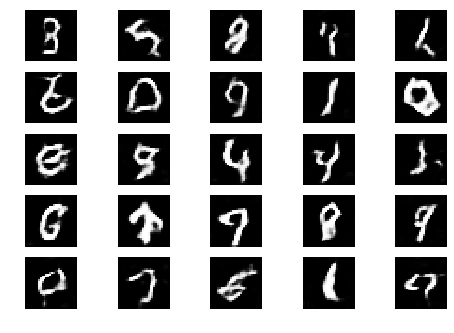

Epoch 1 Batch 1633/1875 [D loss: 0.687339, acc.: 62.50%] [G loss: 1.114933]
Epoch 1 Batch 1634/1875 [D loss: 0.623252, acc.: 65.62%] [G loss: 1.206700]
Epoch 1 Batch 1635/1875 [D loss: 0.523625, acc.: 78.12%] [G loss: 0.808839]
Epoch 1 Batch 1636/1875 [D loss: 0.564660, acc.: 68.75%] [G loss: 1.091104]
Epoch 1 Batch 1637/1875 [D loss: 0.724880, acc.: 46.88%] [G loss: 1.080253]
Epoch 1 Batch 1638/1875 [D loss: 0.756681, acc.: 43.75%] [G loss: 1.155787]
Epoch 1 Batch 1639/1875 [D loss: 0.701385, acc.: 56.25%] [G loss: 1.003652]
Epoch 1 Batch 1640/1875 [D loss: 0.610325, acc.: 68.75%] [G loss: 1.040323]
Epoch 1 Batch 1641/1875 [D loss: 0.844052, acc.: 31.25%] [G loss: 0.867184]
Epoch 1 Batch 1642/1875 [D loss: 0.619436, acc.: 65.62%] [G loss: 0.909620]
Epoch 1 Batch 1643/1875 [D loss: 0.647429, acc.: 59.38%] [G loss: 1.031197]
Epoch 1 Batch 1644/1875 [D loss: 0.668466, acc.: 62.50%] [G loss: 0.895178]
Epoch 1 Batch 1645/1875 [D loss: 0.652337, acc.: 56.25%] [G loss: 0.745223]
Epoch 1 Batc

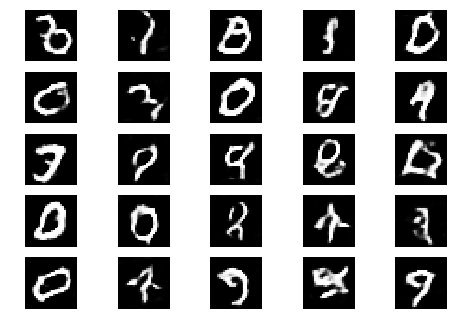

Epoch 1 Batch 1701/1875 [D loss: 0.558624, acc.: 68.75%] [G loss: 1.201049]
Epoch 1 Batch 1702/1875 [D loss: 0.681782, acc.: 62.50%] [G loss: 1.094758]
Epoch 1 Batch 1703/1875 [D loss: 0.777680, acc.: 53.12%] [G loss: 0.978322]
Epoch 1 Batch 1704/1875 [D loss: 0.800125, acc.: 46.88%] [G loss: 1.037518]
Epoch 1 Batch 1705/1875 [D loss: 0.545341, acc.: 71.88%] [G loss: 0.947639]
Epoch 1 Batch 1706/1875 [D loss: 0.794187, acc.: 43.75%] [G loss: 1.004199]
Epoch 1 Batch 1707/1875 [D loss: 0.758875, acc.: 46.88%] [G loss: 0.940180]
Epoch 1 Batch 1708/1875 [D loss: 0.761885, acc.: 50.00%] [G loss: 1.071803]
Epoch 1 Batch 1709/1875 [D loss: 0.731750, acc.: 53.12%] [G loss: 0.960427]
Epoch 1 Batch 1710/1875 [D loss: 0.581927, acc.: 65.62%] [G loss: 1.191553]
Epoch 1 Batch 1711/1875 [D loss: 0.589074, acc.: 65.62%] [G loss: 1.069360]
Epoch 1 Batch 1712/1875 [D loss: 0.716018, acc.: 46.88%] [G loss: 0.947565]
Epoch 1 Batch 1713/1875 [D loss: 0.625663, acc.: 59.38%] [G loss: 0.913733]
Epoch 1 Batc

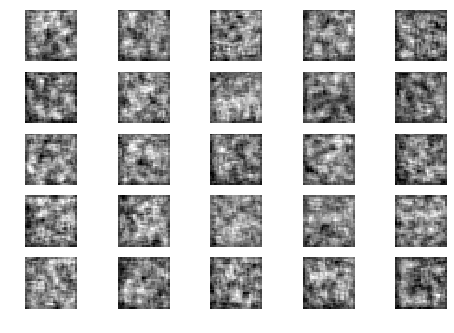

Epoch 1 Batch 1718/1875 [D loss: 0.572792, acc.: 75.00%] [G loss: 1.016718]
Epoch 1 Batch 1719/1875 [D loss: 0.627543, acc.: 59.38%] [G loss: 0.935567]
Epoch 1 Batch 1720/1875 [D loss: 0.623086, acc.: 71.88%] [G loss: 0.980448]
Epoch 1 Batch 1721/1875 [D loss: 0.698495, acc.: 59.38%] [G loss: 0.927641]
Epoch 1 Batch 1722/1875 [D loss: 0.542060, acc.: 75.00%] [G loss: 0.806208]
Epoch 1 Batch 1723/1875 [D loss: 0.733814, acc.: 46.88%] [G loss: 0.934895]
Epoch 1 Batch 1724/1875 [D loss: 0.629990, acc.: 62.50%] [G loss: 1.049977]
Epoch 1 Batch 1725/1875 [D loss: 0.556304, acc.: 78.12%] [G loss: 0.998122]
Epoch 1 Batch 1726/1875 [D loss: 0.794125, acc.: 56.25%] [G loss: 0.879934]
Epoch 1 Batch 1727/1875 [D loss: 0.558013, acc.: 78.12%] [G loss: 0.914064]
Epoch 1 Batch 1728/1875 [D loss: 0.568891, acc.: 78.12%] [G loss: 0.982889]
Epoch 1 Batch 1729/1875 [D loss: 0.696163, acc.: 56.25%] [G loss: 0.955166]
Epoch 1 Batch 1730/1875 [D loss: 0.696730, acc.: 65.62%] [G loss: 0.919881]
Epoch 1 Batc

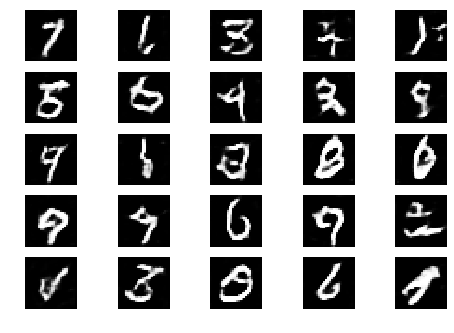

Epoch 1 Batch 1735/1875 [D loss: 0.755019, acc.: 50.00%] [G loss: 1.115704]
Epoch 1 Batch 1736/1875 [D loss: 0.702476, acc.: 53.12%] [G loss: 1.113064]
Epoch 1 Batch 1737/1875 [D loss: 0.560299, acc.: 71.88%] [G loss: 1.048131]
Epoch 1 Batch 1738/1875 [D loss: 0.667019, acc.: 53.12%] [G loss: 0.934821]
Epoch 1 Batch 1739/1875 [D loss: 0.610971, acc.: 68.75%] [G loss: 0.975668]
Epoch 1 Batch 1740/1875 [D loss: 0.708439, acc.: 56.25%] [G loss: 0.898977]
Epoch 1 Batch 1741/1875 [D loss: 0.658299, acc.: 56.25%] [G loss: 0.981413]
Epoch 1 Batch 1742/1875 [D loss: 0.589524, acc.: 62.50%] [G loss: 1.059919]
Epoch 1 Batch 1743/1875 [D loss: 0.607338, acc.: 71.88%] [G loss: 0.805045]
Epoch 1 Batch 1744/1875 [D loss: 0.614953, acc.: 68.75%] [G loss: 1.111102]
Epoch 1 Batch 1745/1875 [D loss: 0.604537, acc.: 68.75%] [G loss: 0.992712]
Epoch 1 Batch 1746/1875 [D loss: 0.568893, acc.: 71.88%] [G loss: 0.843024]
Epoch 1 Batch 1747/1875 [D loss: 0.580965, acc.: 75.00%] [G loss: 0.902489]
Epoch 1 Batc

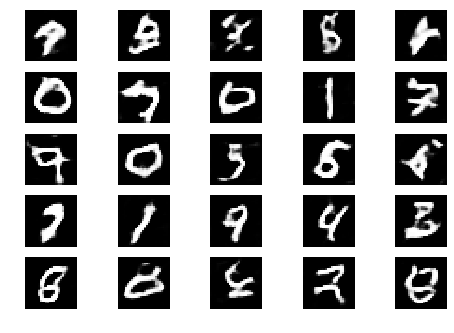

Epoch 1 Batch 1801/1875 [D loss: 0.639818, acc.: 65.62%] [G loss: 1.054434]
Epoch 1 Batch 1802/1875 [D loss: 0.709638, acc.: 56.25%] [G loss: 0.761196]
Epoch 1 Batch 1803/1875 [D loss: 0.589430, acc.: 78.12%] [G loss: 0.880441]
Epoch 1 Batch 1804/1875 [D loss: 0.680341, acc.: 56.25%] [G loss: 1.024426]
Epoch 1 Batch 1805/1875 [D loss: 0.622644, acc.: 65.62%] [G loss: 0.835017]
Epoch 1 Batch 1806/1875 [D loss: 0.525183, acc.: 81.25%] [G loss: 0.995423]
Epoch 1 Batch 1807/1875 [D loss: 0.624277, acc.: 68.75%] [G loss: 1.232605]
Epoch 1 Batch 1808/1875 [D loss: 0.732191, acc.: 50.00%] [G loss: 1.213802]
Epoch 1 Batch 1809/1875 [D loss: 0.670431, acc.: 59.38%] [G loss: 1.058590]
Epoch 1 Batch 1810/1875 [D loss: 0.523493, acc.: 78.12%] [G loss: 0.864560]
Epoch 1 Batch 1811/1875 [D loss: 0.608182, acc.: 65.62%] [G loss: 0.951229]
Epoch 1 Batch 1812/1875 [D loss: 0.668855, acc.: 62.50%] [G loss: 0.781489]
Epoch 1 Batch 1813/1875 [D loss: 0.594740, acc.: 65.62%] [G loss: 1.052669]
Epoch 1 Batc

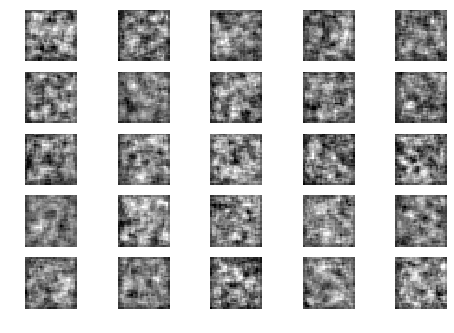

Epoch 1 Batch 1819/1875 [D loss: 0.523768, acc.: 81.25%] [G loss: 0.786115]
Epoch 1 Batch 1820/1875 [D loss: 0.814278, acc.: 56.25%] [G loss: 1.078477]
Epoch 1 Batch 1821/1875 [D loss: 0.646316, acc.: 56.25%] [G loss: 0.984034]
Epoch 1 Batch 1822/1875 [D loss: 0.590382, acc.: 71.88%] [G loss: 1.143046]
Epoch 1 Batch 1823/1875 [D loss: 0.588402, acc.: 65.62%] [G loss: 0.881393]
Epoch 1 Batch 1824/1875 [D loss: 0.635362, acc.: 59.38%] [G loss: 0.740699]
Epoch 1 Batch 1825/1875 [D loss: 0.567229, acc.: 71.88%] [G loss: 0.831681]
Epoch 1 Batch 1826/1875 [D loss: 0.708390, acc.: 56.25%] [G loss: 0.784071]
Epoch 1 Batch 1827/1875 [D loss: 0.680489, acc.: 46.88%] [G loss: 0.839885]
Epoch 1 Batch 1828/1875 [D loss: 0.538579, acc.: 71.88%] [G loss: 0.802438]
Epoch 1 Batch 1829/1875 [D loss: 0.682437, acc.: 62.50%] [G loss: 0.678714]
Epoch 1 Batch 1830/1875 [D loss: 0.408396, acc.: 93.75%] [G loss: 0.875258]
Epoch 1 Batch 1831/1875 [D loss: 0.719162, acc.: 56.25%] [G loss: 0.960898]
Epoch 1 Batc

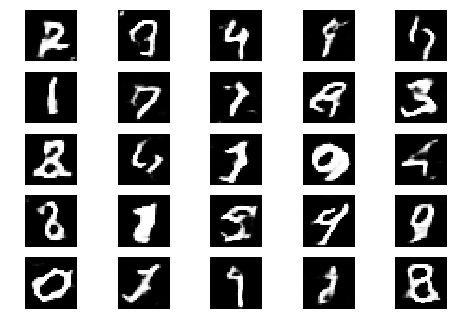

Epoch 1 Batch 1837/1875 [D loss: 0.789433, acc.: 46.88%] [G loss: 0.751825]
Epoch 1 Batch 1838/1875 [D loss: 0.483482, acc.: 84.38%] [G loss: 1.103511]
Epoch 1 Batch 1839/1875 [D loss: 0.913216, acc.: 43.75%] [G loss: 0.891620]
Epoch 1 Batch 1840/1875 [D loss: 0.468293, acc.: 75.00%] [G loss: 0.914086]
Epoch 1 Batch 1841/1875 [D loss: 0.548440, acc.: 75.00%] [G loss: 0.810222]
Epoch 1 Batch 1842/1875 [D loss: 0.553155, acc.: 75.00%] [G loss: 1.018758]
Epoch 1 Batch 1843/1875 [D loss: 0.533045, acc.: 75.00%] [G loss: 0.925904]
Epoch 1 Batch 1844/1875 [D loss: 0.744881, acc.: 50.00%] [G loss: 0.936275]
Epoch 1 Batch 1845/1875 [D loss: 0.694789, acc.: 56.25%] [G loss: 1.026767]
Epoch 1 Batch 1846/1875 [D loss: 0.609314, acc.: 62.50%] [G loss: 0.821290]
Epoch 1 Batch 1847/1875 [D loss: 0.734785, acc.: 46.88%] [G loss: 1.096533]
Epoch 1 Batch 1848/1875 [D loss: 0.743339, acc.: 50.00%] [G loss: 0.728133]
Epoch 1 Batch 1849/1875 [D loss: 0.675508, acc.: 62.50%] [G loss: 0.897927]
Epoch 1 Batc

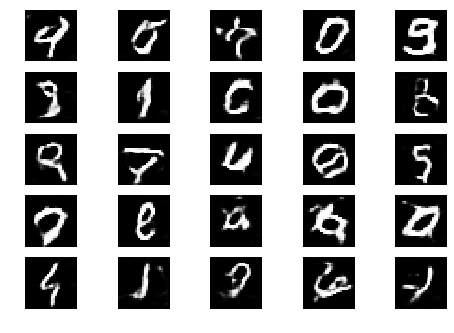

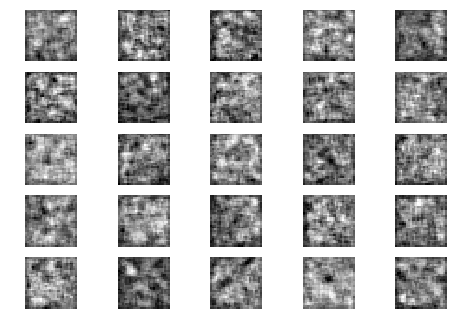

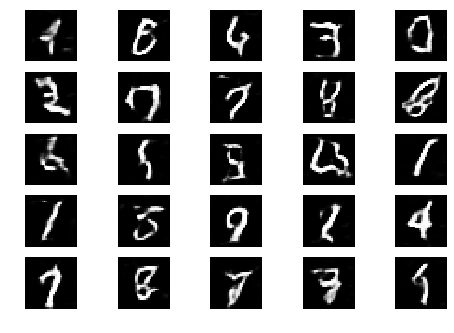

Epoch 2 Batch 1/1875 [D loss: 0.652124, acc.: 59.38%] [G loss: 1.031948]
Epoch 2 Batch 2/1875 [D loss: 0.694755, acc.: 59.38%] [G loss: 0.895578]
Epoch 2 Batch 3/1875 [D loss: 0.623485, acc.: 62.50%] [G loss: 1.014226]
Epoch 2 Batch 4/1875 [D loss: 0.611763, acc.: 71.88%] [G loss: 0.884268]
Epoch 2 Batch 5/1875 [D loss: 0.817917, acc.: 53.12%] [G loss: 0.947493]
Epoch 2 Batch 6/1875 [D loss: 0.541082, acc.: 68.75%] [G loss: 0.906411]
Epoch 2 Batch 7/1875 [D loss: 0.587336, acc.: 75.00%] [G loss: 1.024486]
Epoch 2 Batch 8/1875 [D loss: 0.734575, acc.: 53.12%] [G loss: 1.074321]
Epoch 2 Batch 9/1875 [D loss: 0.593900, acc.: 65.62%] [G loss: 1.220168]
Epoch 2 Batch 10/1875 [D loss: 0.658596, acc.: 53.12%] [G loss: 1.056953]
Epoch 2 Batch 11/1875 [D loss: 0.576026, acc.: 65.62%] [G loss: 0.933257]
Epoch 2 Batch 12/1875 [D loss: 0.620382, acc.: 59.38%] [G loss: 0.907869]
Epoch 2 Batch 13/1875 [D loss: 0.598982, acc.: 68.75%] [G loss: 0.886378]
Epoch 2 Batch 14/1875 [D loss: 0.781213, acc.: 

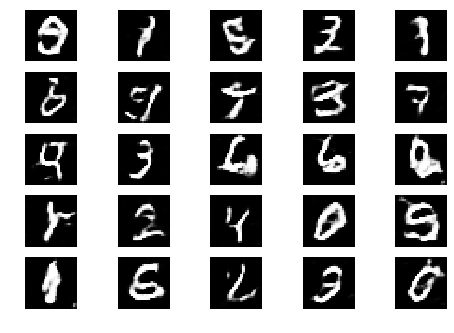

Epoch 2 Batch 101/1875 [D loss: 0.592418, acc.: 65.62%] [G loss: 0.953123]


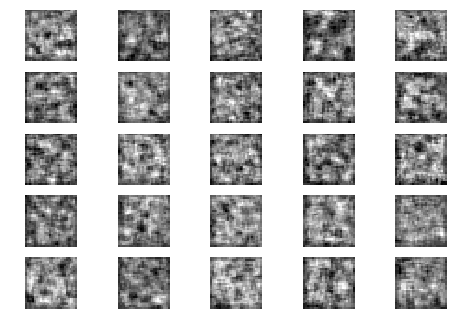

Epoch 2 Batch 102/1875 [D loss: 0.540419, acc.: 71.88%] [G loss: 1.176040]


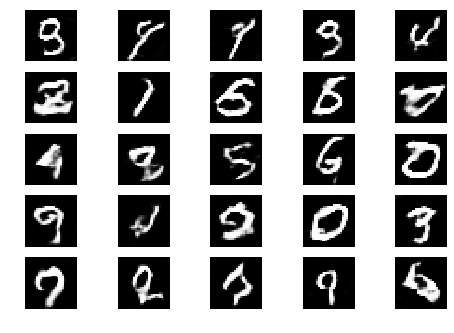

Epoch 2 Batch 103/1875 [D loss: 0.609618, acc.: 59.38%] [G loss: 0.874690]
Epoch 2 Batch 104/1875 [D loss: 0.651826, acc.: 62.50%] [G loss: 1.085289]
Epoch 2 Batch 105/1875 [D loss: 0.660163, acc.: 71.88%] [G loss: 0.952977]
Epoch 2 Batch 106/1875 [D loss: 0.556243, acc.: 75.00%] [G loss: 0.864443]
Epoch 2 Batch 107/1875 [D loss: 0.525312, acc.: 78.12%] [G loss: 0.815870]
Epoch 2 Batch 108/1875 [D loss: 0.612780, acc.: 53.12%] [G loss: 0.854736]
Epoch 2 Batch 109/1875 [D loss: 0.625613, acc.: 62.50%] [G loss: 1.089914]
Epoch 2 Batch 110/1875 [D loss: 0.727744, acc.: 46.88%] [G loss: 0.916736]
Epoch 2 Batch 111/1875 [D loss: 0.694243, acc.: 40.62%] [G loss: 0.915172]
Epoch 2 Batch 112/1875 [D loss: 0.647846, acc.: 68.75%] [G loss: 0.906777]
Epoch 2 Batch 113/1875 [D loss: 0.617593, acc.: 65.62%] [G loss: 1.146248]
Epoch 2 Batch 114/1875 [D loss: 0.684619, acc.: 65.62%] [G loss: 0.887779]
Epoch 2 Batch 115/1875 [D loss: 0.635865, acc.: 59.38%] [G loss: 1.045917]
Epoch 2 Batch 116/1875 [D

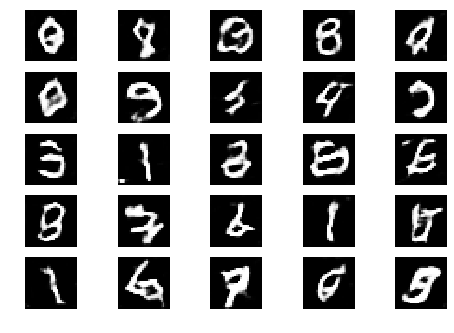

Epoch 2 Batch 201/1875 [D loss: 0.646367, acc.: 65.62%] [G loss: 1.045404]
Epoch 2 Batch 202/1875 [D loss: 0.737159, acc.: 56.25%] [G loss: 0.959762]


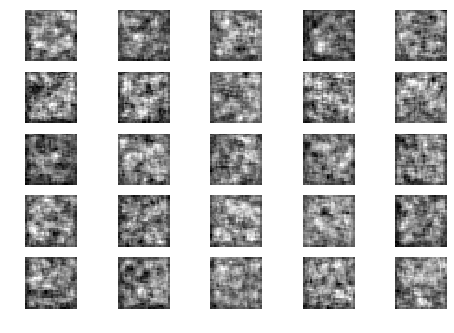

Epoch 2 Batch 203/1875 [D loss: 0.571548, acc.: 71.88%] [G loss: 1.114620]
Epoch 2 Batch 204/1875 [D loss: 0.570662, acc.: 68.75%] [G loss: 1.025940]


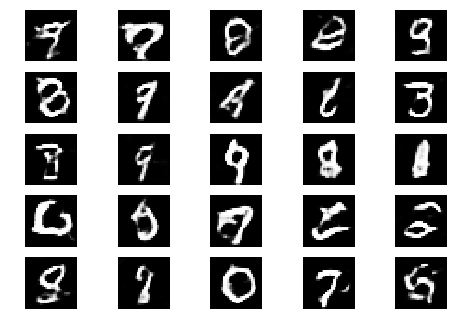

Epoch 2 Batch 205/1875 [D loss: 0.576618, acc.: 65.62%] [G loss: 1.074299]
Epoch 2 Batch 206/1875 [D loss: 0.657462, acc.: 59.38%] [G loss: 0.989371]
Epoch 2 Batch 207/1875 [D loss: 0.780075, acc.: 46.88%] [G loss: 0.963519]
Epoch 2 Batch 208/1875 [D loss: 0.709850, acc.: 68.75%] [G loss: 0.971218]
Epoch 2 Batch 209/1875 [D loss: 0.538729, acc.: 78.12%] [G loss: 0.919614]
Epoch 2 Batch 210/1875 [D loss: 0.534638, acc.: 78.12%] [G loss: 1.026665]
Epoch 2 Batch 211/1875 [D loss: 0.502204, acc.: 84.38%] [G loss: 0.790354]
Epoch 2 Batch 212/1875 [D loss: 0.620181, acc.: 56.25%] [G loss: 0.830348]
Epoch 2 Batch 213/1875 [D loss: 0.807556, acc.: 53.12%] [G loss: 0.856389]
Epoch 2 Batch 214/1875 [D loss: 0.641571, acc.: 68.75%] [G loss: 1.088856]
Epoch 2 Batch 215/1875 [D loss: 0.646559, acc.: 68.75%] [G loss: 0.990984]
Epoch 2 Batch 216/1875 [D loss: 0.641581, acc.: 71.88%] [G loss: 1.106789]
Epoch 2 Batch 217/1875 [D loss: 0.741586, acc.: 53.12%] [G loss: 0.984917]
Epoch 2 Batch 218/1875 [D

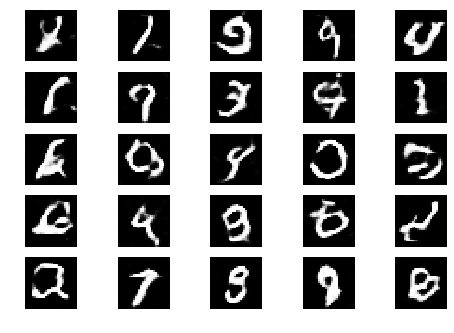

Epoch 2 Batch 301/1875 [D loss: 0.732515, acc.: 56.25%] [G loss: 0.795713]
Epoch 2 Batch 302/1875 [D loss: 0.672833, acc.: 62.50%] [G loss: 0.907597]
Epoch 2 Batch 303/1875 [D loss: 0.618928, acc.: 68.75%] [G loss: 1.023351]


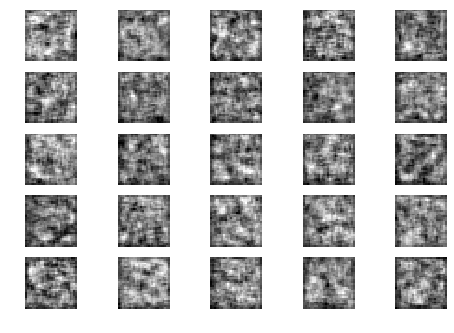

Epoch 2 Batch 304/1875 [D loss: 0.623065, acc.: 65.62%] [G loss: 0.945412]
Epoch 2 Batch 305/1875 [D loss: 0.757658, acc.: 50.00%] [G loss: 1.000518]
Epoch 2 Batch 306/1875 [D loss: 0.612719, acc.: 62.50%] [G loss: 0.814729]


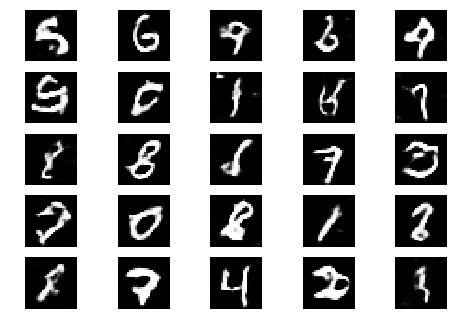

Epoch 2 Batch 307/1875 [D loss: 0.685284, acc.: 56.25%] [G loss: 0.895435]
Epoch 2 Batch 308/1875 [D loss: 0.648800, acc.: 68.75%] [G loss: 0.881576]
Epoch 2 Batch 309/1875 [D loss: 0.765663, acc.: 46.88%] [G loss: 0.901472]
Epoch 2 Batch 310/1875 [D loss: 0.773911, acc.: 59.38%] [G loss: 1.018756]
Epoch 2 Batch 311/1875 [D loss: 0.675400, acc.: 62.50%] [G loss: 0.966663]
Epoch 2 Batch 312/1875 [D loss: 0.578262, acc.: 65.62%] [G loss: 0.893074]
Epoch 2 Batch 313/1875 [D loss: 0.680015, acc.: 68.75%] [G loss: 0.850578]
Epoch 2 Batch 314/1875 [D loss: 0.722179, acc.: 46.88%] [G loss: 1.032546]
Epoch 2 Batch 315/1875 [D loss: 0.598296, acc.: 56.25%] [G loss: 1.006547]
Epoch 2 Batch 316/1875 [D loss: 0.578251, acc.: 56.25%] [G loss: 0.918939]
Epoch 2 Batch 317/1875 [D loss: 0.603504, acc.: 65.62%] [G loss: 0.830380]
Epoch 2 Batch 318/1875 [D loss: 0.773746, acc.: 56.25%] [G loss: 0.865956]
Epoch 2 Batch 319/1875 [D loss: 0.735182, acc.: 43.75%] [G loss: 0.988798]
Epoch 2 Batch 320/1875 [D

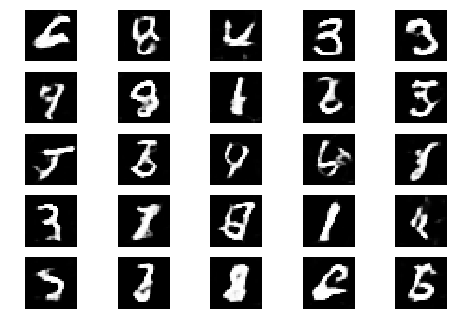

Epoch 2 Batch 401/1875 [D loss: 0.602786, acc.: 62.50%] [G loss: 0.950242]
Epoch 2 Batch 402/1875 [D loss: 0.512066, acc.: 75.00%] [G loss: 1.009782]
Epoch 2 Batch 403/1875 [D loss: 0.713995, acc.: 56.25%] [G loss: 1.011757]
Epoch 2 Batch 404/1875 [D loss: 0.617720, acc.: 68.75%] [G loss: 1.124255]


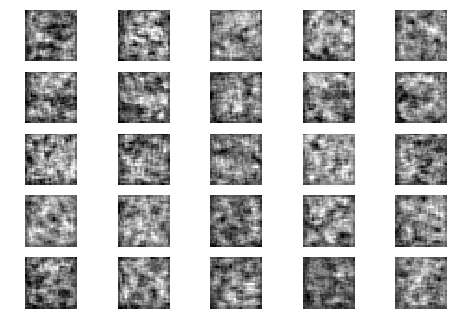

Epoch 2 Batch 405/1875 [D loss: 0.750749, acc.: 56.25%] [G loss: 1.071481]
Epoch 2 Batch 406/1875 [D loss: 0.879941, acc.: 37.50%] [G loss: 0.926535]
Epoch 2 Batch 407/1875 [D loss: 0.769784, acc.: 43.75%] [G loss: 0.953694]
Epoch 2 Batch 408/1875 [D loss: 0.583333, acc.: 75.00%] [G loss: 0.989144]


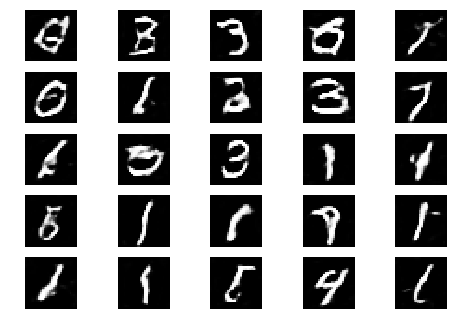

Epoch 2 Batch 409/1875 [D loss: 0.707294, acc.: 53.12%] [G loss: 1.064206]
Epoch 2 Batch 410/1875 [D loss: 0.682511, acc.: 53.12%] [G loss: 1.062864]
Epoch 2 Batch 411/1875 [D loss: 0.601948, acc.: 65.62%] [G loss: 1.039825]
Epoch 2 Batch 412/1875 [D loss: 0.710660, acc.: 56.25%] [G loss: 0.892722]
Epoch 2 Batch 413/1875 [D loss: 0.551683, acc.: 71.88%] [G loss: 1.035221]
Epoch 2 Batch 414/1875 [D loss: 0.650702, acc.: 62.50%] [G loss: 0.949381]
Epoch 2 Batch 415/1875 [D loss: 0.731327, acc.: 46.88%] [G loss: 1.127613]
Epoch 2 Batch 416/1875 [D loss: 0.567445, acc.: 71.88%] [G loss: 0.928311]
Epoch 2 Batch 417/1875 [D loss: 0.687621, acc.: 50.00%] [G loss: 0.894764]
Epoch 2 Batch 418/1875 [D loss: 0.652215, acc.: 65.62%] [G loss: 1.019686]
Epoch 2 Batch 419/1875 [D loss: 0.680586, acc.: 56.25%] [G loss: 0.945903]
Epoch 2 Batch 420/1875 [D loss: 0.790640, acc.: 50.00%] [G loss: 1.047336]
Epoch 2 Batch 421/1875 [D loss: 0.636994, acc.: 56.25%] [G loss: 1.084596]
Epoch 2 Batch 422/1875 [D

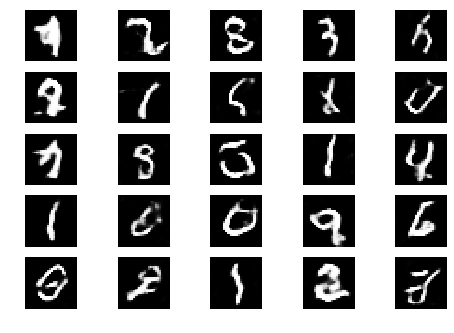

Epoch 2 Batch 501/1875 [D loss: 0.699594, acc.: 50.00%] [G loss: 0.977550]
Epoch 2 Batch 502/1875 [D loss: 0.564632, acc.: 65.62%] [G loss: 0.816458]
Epoch 2 Batch 503/1875 [D loss: 0.683308, acc.: 56.25%] [G loss: 1.113691]
Epoch 2 Batch 504/1875 [D loss: 0.691116, acc.: 65.62%] [G loss: 0.942879]
Epoch 2 Batch 505/1875 [D loss: 0.726280, acc.: 56.25%] [G loss: 0.949804]


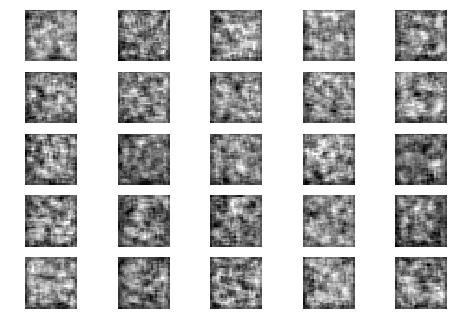

Epoch 2 Batch 506/1875 [D loss: 0.636420, acc.: 71.88%] [G loss: 0.725937]
Epoch 2 Batch 507/1875 [D loss: 0.715310, acc.: 59.38%] [G loss: 1.025590]
Epoch 2 Batch 508/1875 [D loss: 0.577144, acc.: 71.88%] [G loss: 0.960610]
Epoch 2 Batch 509/1875 [D loss: 0.717385, acc.: 53.12%] [G loss: 1.046184]
Epoch 2 Batch 510/1875 [D loss: 0.686627, acc.: 59.38%] [G loss: 1.003141]


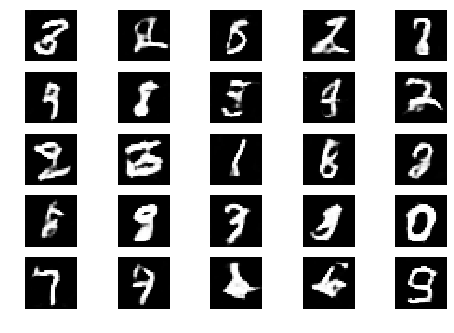

Epoch 2 Batch 511/1875 [D loss: 0.669408, acc.: 68.75%] [G loss: 1.034975]
Epoch 2 Batch 512/1875 [D loss: 0.785652, acc.: 46.88%] [G loss: 0.943047]
Epoch 2 Batch 513/1875 [D loss: 0.570541, acc.: 68.75%] [G loss: 1.068855]
Epoch 2 Batch 514/1875 [D loss: 0.728366, acc.: 53.12%] [G loss: 0.945022]
Epoch 2 Batch 515/1875 [D loss: 0.583196, acc.: 62.50%] [G loss: 0.970848]
Epoch 2 Batch 516/1875 [D loss: 0.721027, acc.: 50.00%] [G loss: 0.893311]
Epoch 2 Batch 517/1875 [D loss: 0.618338, acc.: 68.75%] [G loss: 1.092090]
Epoch 2 Batch 518/1875 [D loss: 0.688405, acc.: 59.38%] [G loss: 0.908823]
Epoch 2 Batch 519/1875 [D loss: 0.627625, acc.: 59.38%] [G loss: 0.989791]
Epoch 2 Batch 520/1875 [D loss: 0.672018, acc.: 59.38%] [G loss: 1.169211]
Epoch 2 Batch 521/1875 [D loss: 0.617181, acc.: 65.62%] [G loss: 0.954558]
Epoch 2 Batch 522/1875 [D loss: 0.761225, acc.: 59.38%] [G loss: 1.001268]
Epoch 2 Batch 523/1875 [D loss: 0.685784, acc.: 62.50%] [G loss: 0.756054]
Epoch 2 Batch 524/1875 [D

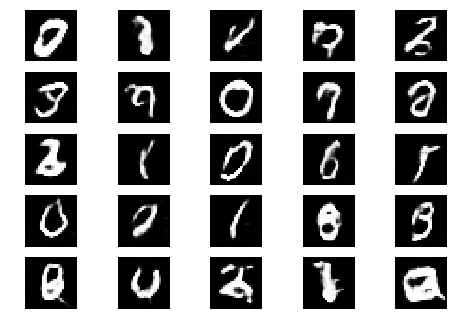

Epoch 2 Batch 601/1875 [D loss: 0.592214, acc.: 68.75%] [G loss: 1.006609]
Epoch 2 Batch 602/1875 [D loss: 0.745609, acc.: 46.88%] [G loss: 1.046005]
Epoch 2 Batch 603/1875 [D loss: 0.655906, acc.: 62.50%] [G loss: 0.857685]
Epoch 2 Batch 604/1875 [D loss: 0.527961, acc.: 71.88%] [G loss: 1.006563]
Epoch 2 Batch 605/1875 [D loss: 0.599892, acc.: 71.88%] [G loss: 0.964826]
Epoch 2 Batch 606/1875 [D loss: 0.659644, acc.: 65.62%] [G loss: 0.891791]


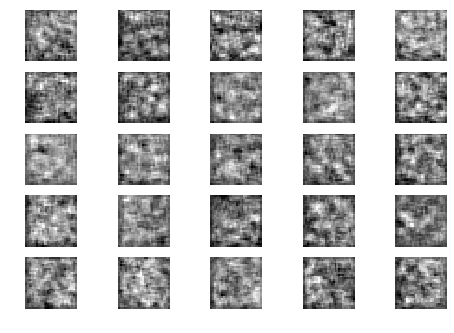

Epoch 2 Batch 607/1875 [D loss: 0.611458, acc.: 62.50%] [G loss: 1.027462]
Epoch 2 Batch 608/1875 [D loss: 0.615142, acc.: 68.75%] [G loss: 1.122806]
Epoch 2 Batch 609/1875 [D loss: 0.497688, acc.: 81.25%] [G loss: 1.072580]
Epoch 2 Batch 610/1875 [D loss: 0.567665, acc.: 78.12%] [G loss: 1.030413]
Epoch 2 Batch 611/1875 [D loss: 0.646657, acc.: 65.62%] [G loss: 0.861801]
Epoch 2 Batch 612/1875 [D loss: 0.573398, acc.: 68.75%] [G loss: 0.884403]


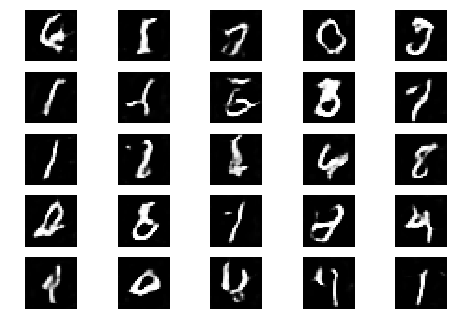

Epoch 2 Batch 613/1875 [D loss: 0.801123, acc.: 50.00%] [G loss: 0.917050]
Epoch 2 Batch 614/1875 [D loss: 0.678032, acc.: 59.38%] [G loss: 0.947936]
Epoch 2 Batch 615/1875 [D loss: 0.602704, acc.: 62.50%] [G loss: 1.087754]
Epoch 2 Batch 616/1875 [D loss: 0.644668, acc.: 59.38%] [G loss: 0.995102]
Epoch 2 Batch 617/1875 [D loss: 0.664526, acc.: 56.25%] [G loss: 0.907170]
Epoch 2 Batch 618/1875 [D loss: 0.821586, acc.: 53.12%] [G loss: 0.991010]
Epoch 2 Batch 619/1875 [D loss: 0.670234, acc.: 56.25%] [G loss: 0.923222]
Epoch 2 Batch 620/1875 [D loss: 0.646350, acc.: 75.00%] [G loss: 0.878534]
Epoch 2 Batch 621/1875 [D loss: 0.711789, acc.: 59.38%] [G loss: 1.028395]
Epoch 2 Batch 622/1875 [D loss: 0.649422, acc.: 65.62%] [G loss: 1.159193]
Epoch 2 Batch 623/1875 [D loss: 0.602637, acc.: 65.62%] [G loss: 0.986856]
Epoch 2 Batch 624/1875 [D loss: 0.647106, acc.: 62.50%] [G loss: 0.814967]
Epoch 2 Batch 625/1875 [D loss: 0.729973, acc.: 56.25%] [G loss: 0.875497]
Epoch 2 Batch 626/1875 [D

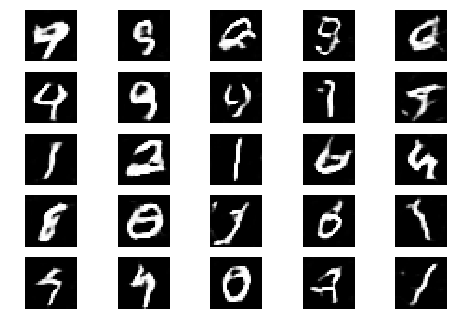

Epoch 2 Batch 701/1875 [D loss: 0.681523, acc.: 62.50%] [G loss: 1.021594]
Epoch 2 Batch 702/1875 [D loss: 0.787716, acc.: 46.88%] [G loss: 0.854410]
Epoch 2 Batch 703/1875 [D loss: 0.602627, acc.: 78.12%] [G loss: 0.996578]
Epoch 2 Batch 704/1875 [D loss: 0.699051, acc.: 46.88%] [G loss: 0.963397]
Epoch 2 Batch 705/1875 [D loss: 0.736995, acc.: 53.12%] [G loss: 0.899501]
Epoch 2 Batch 706/1875 [D loss: 0.627932, acc.: 65.62%] [G loss: 0.820663]
Epoch 2 Batch 707/1875 [D loss: 0.683780, acc.: 59.38%] [G loss: 0.922616]


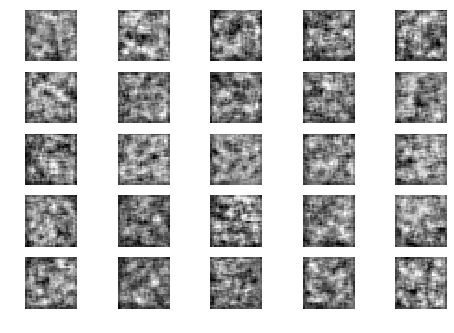

Epoch 2 Batch 708/1875 [D loss: 0.608936, acc.: 59.38%] [G loss: 0.994864]
Epoch 2 Batch 709/1875 [D loss: 0.683921, acc.: 56.25%] [G loss: 0.840519]
Epoch 2 Batch 710/1875 [D loss: 0.620824, acc.: 68.75%] [G loss: 1.070228]
Epoch 2 Batch 711/1875 [D loss: 0.546783, acc.: 75.00%] [G loss: 1.038535]
Epoch 2 Batch 712/1875 [D loss: 0.575181, acc.: 75.00%] [G loss: 1.044559]
Epoch 2 Batch 713/1875 [D loss: 0.752673, acc.: 59.38%] [G loss: 1.037784]
Epoch 2 Batch 714/1875 [D loss: 0.742577, acc.: 50.00%] [G loss: 1.146790]


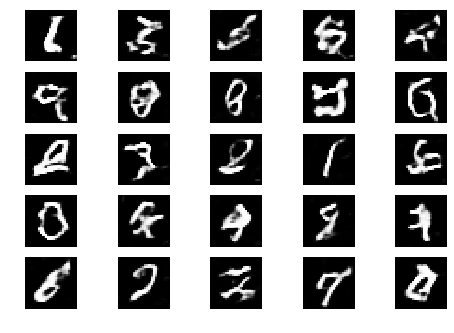

Epoch 2 Batch 715/1875 [D loss: 0.606963, acc.: 71.88%] [G loss: 1.091094]
Epoch 2 Batch 716/1875 [D loss: 0.629303, acc.: 68.75%] [G loss: 1.058958]
Epoch 2 Batch 717/1875 [D loss: 0.636776, acc.: 59.38%] [G loss: 1.008849]
Epoch 2 Batch 718/1875 [D loss: 0.742969, acc.: 50.00%] [G loss: 0.939462]
Epoch 2 Batch 719/1875 [D loss: 0.678450, acc.: 59.38%] [G loss: 0.944077]
Epoch 2 Batch 720/1875 [D loss: 0.588245, acc.: 78.12%] [G loss: 0.932554]
Epoch 2 Batch 721/1875 [D loss: 0.646117, acc.: 62.50%] [G loss: 1.004380]
Epoch 2 Batch 722/1875 [D loss: 0.694001, acc.: 59.38%] [G loss: 0.988847]
Epoch 2 Batch 723/1875 [D loss: 0.590552, acc.: 75.00%] [G loss: 0.959021]
Epoch 2 Batch 724/1875 [D loss: 0.618603, acc.: 65.62%] [G loss: 1.004250]
Epoch 2 Batch 725/1875 [D loss: 0.671057, acc.: 65.62%] [G loss: 0.950415]
Epoch 2 Batch 726/1875 [D loss: 0.590763, acc.: 71.88%] [G loss: 0.909054]
Epoch 2 Batch 727/1875 [D loss: 0.687597, acc.: 56.25%] [G loss: 0.876081]
Epoch 2 Batch 728/1875 [D

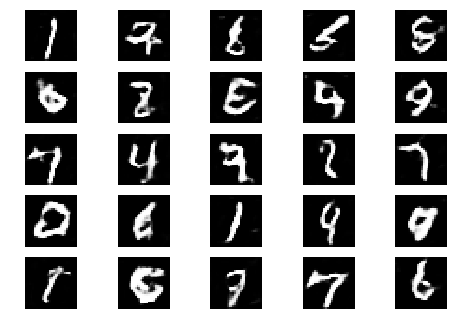

Epoch 2 Batch 801/1875 [D loss: 0.573150, acc.: 68.75%] [G loss: 0.944611]
Epoch 2 Batch 802/1875 [D loss: 0.661537, acc.: 59.38%] [G loss: 1.196612]
Epoch 2 Batch 803/1875 [D loss: 0.521370, acc.: 75.00%] [G loss: 1.176675]
Epoch 2 Batch 804/1875 [D loss: 0.667042, acc.: 62.50%] [G loss: 0.935818]
Epoch 2 Batch 805/1875 [D loss: 0.708225, acc.: 65.62%] [G loss: 1.014707]
Epoch 2 Batch 806/1875 [D loss: 0.767408, acc.: 56.25%] [G loss: 1.053549]
Epoch 2 Batch 807/1875 [D loss: 0.619032, acc.: 68.75%] [G loss: 1.100879]
Epoch 2 Batch 808/1875 [D loss: 0.652862, acc.: 59.38%] [G loss: 0.815495]


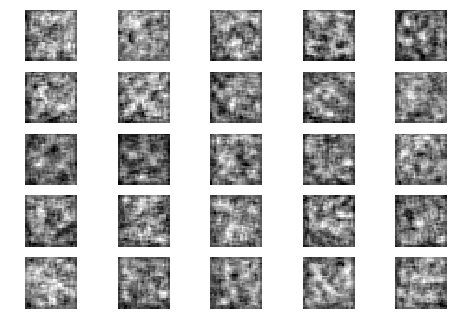

Epoch 2 Batch 809/1875 [D loss: 0.570108, acc.: 68.75%] [G loss: 0.898808]
Epoch 2 Batch 810/1875 [D loss: 0.611835, acc.: 65.62%] [G loss: 1.141528]
Epoch 2 Batch 811/1875 [D loss: 0.732069, acc.: 46.88%] [G loss: 0.920006]
Epoch 2 Batch 812/1875 [D loss: 0.538197, acc.: 78.12%] [G loss: 1.099321]
Epoch 2 Batch 813/1875 [D loss: 0.584772, acc.: 71.88%] [G loss: 0.893128]
Epoch 2 Batch 814/1875 [D loss: 0.697310, acc.: 50.00%] [G loss: 1.068708]
Epoch 2 Batch 815/1875 [D loss: 0.727796, acc.: 50.00%] [G loss: 0.893696]
Epoch 2 Batch 816/1875 [D loss: 0.753974, acc.: 53.12%] [G loss: 0.953438]


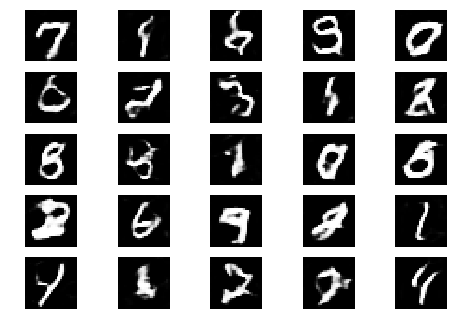

Epoch 2 Batch 817/1875 [D loss: 0.658425, acc.: 68.75%] [G loss: 1.053866]
Epoch 2 Batch 818/1875 [D loss: 0.678634, acc.: 62.50%] [G loss: 0.945274]
Epoch 2 Batch 819/1875 [D loss: 0.772305, acc.: 53.12%] [G loss: 0.891491]
Epoch 2 Batch 820/1875 [D loss: 0.541989, acc.: 78.12%] [G loss: 0.955063]
Epoch 2 Batch 821/1875 [D loss: 0.610144, acc.: 62.50%] [G loss: 0.984486]
Epoch 2 Batch 822/1875 [D loss: 0.636290, acc.: 68.75%] [G loss: 0.892787]
Epoch 2 Batch 823/1875 [D loss: 0.664168, acc.: 62.50%] [G loss: 1.040418]
Epoch 2 Batch 824/1875 [D loss: 0.489482, acc.: 81.25%] [G loss: 1.021643]
Epoch 2 Batch 825/1875 [D loss: 0.736989, acc.: 46.88%] [G loss: 0.954467]
Epoch 2 Batch 826/1875 [D loss: 0.616596, acc.: 68.75%] [G loss: 1.020460]
Epoch 2 Batch 827/1875 [D loss: 0.627991, acc.: 62.50%] [G loss: 1.074030]
Epoch 2 Batch 828/1875 [D loss: 0.747488, acc.: 56.25%] [G loss: 1.021140]
Epoch 2 Batch 829/1875 [D loss: 0.673281, acc.: 62.50%] [G loss: 0.953702]
Epoch 2 Batch 830/1875 [D

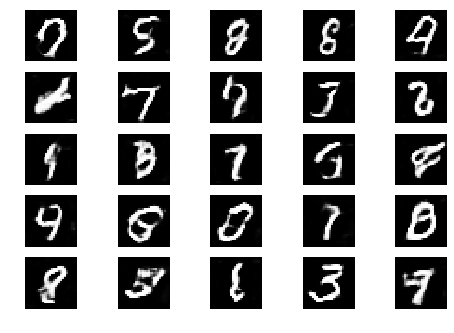

Epoch 2 Batch 901/1875 [D loss: 0.610906, acc.: 68.75%] [G loss: 1.056660]
Epoch 2 Batch 902/1875 [D loss: 0.553351, acc.: 75.00%] [G loss: 0.878168]
Epoch 2 Batch 903/1875 [D loss: 0.659232, acc.: 68.75%] [G loss: 0.998029]
Epoch 2 Batch 904/1875 [D loss: 0.616005, acc.: 62.50%] [G loss: 1.065204]
Epoch 2 Batch 905/1875 [D loss: 0.490451, acc.: 81.25%] [G loss: 1.157680]
Epoch 2 Batch 906/1875 [D loss: 0.669347, acc.: 62.50%] [G loss: 0.718579]
Epoch 2 Batch 907/1875 [D loss: 0.591813, acc.: 68.75%] [G loss: 1.111042]
Epoch 2 Batch 908/1875 [D loss: 0.670813, acc.: 56.25%] [G loss: 1.168384]
Epoch 2 Batch 909/1875 [D loss: 0.573543, acc.: 71.88%] [G loss: 0.968655]


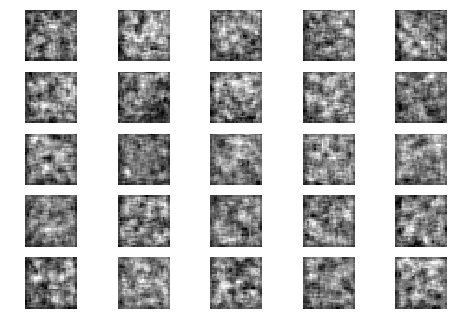

Epoch 2 Batch 910/1875 [D loss: 0.624624, acc.: 71.88%] [G loss: 1.074202]
Epoch 2 Batch 911/1875 [D loss: 0.850944, acc.: 40.62%] [G loss: 1.144258]
Epoch 2 Batch 912/1875 [D loss: 0.657929, acc.: 68.75%] [G loss: 1.063210]
Epoch 2 Batch 913/1875 [D loss: 0.806001, acc.: 43.75%] [G loss: 1.033569]
Epoch 2 Batch 914/1875 [D loss: 0.807074, acc.: 46.88%] [G loss: 0.829346]
Epoch 2 Batch 915/1875 [D loss: 0.560300, acc.: 71.88%] [G loss: 1.014756]
Epoch 2 Batch 916/1875 [D loss: 0.676499, acc.: 53.12%] [G loss: 0.971029]
Epoch 2 Batch 917/1875 [D loss: 0.715097, acc.: 59.38%] [G loss: 1.046070]
Epoch 2 Batch 918/1875 [D loss: 0.496340, acc.: 84.38%] [G loss: 0.939434]


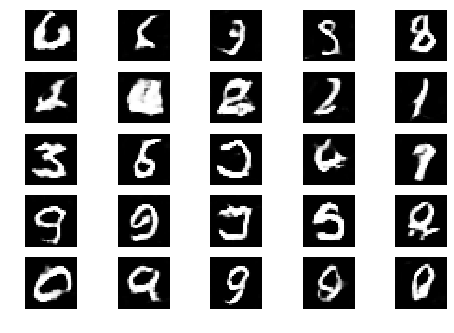

Epoch 2 Batch 919/1875 [D loss: 0.690979, acc.: 62.50%] [G loss: 1.018821]
Epoch 2 Batch 920/1875 [D loss: 0.649407, acc.: 56.25%] [G loss: 0.833177]
Epoch 2 Batch 921/1875 [D loss: 0.565293, acc.: 75.00%] [G loss: 0.979882]
Epoch 2 Batch 922/1875 [D loss: 0.607646, acc.: 62.50%] [G loss: 0.954126]
Epoch 2 Batch 923/1875 [D loss: 0.593510, acc.: 65.62%] [G loss: 1.188676]
Epoch 2 Batch 924/1875 [D loss: 0.701278, acc.: 68.75%] [G loss: 1.007140]
Epoch 2 Batch 925/1875 [D loss: 0.719500, acc.: 56.25%] [G loss: 0.882549]
Epoch 2 Batch 926/1875 [D loss: 0.678303, acc.: 62.50%] [G loss: 0.941872]
Epoch 2 Batch 927/1875 [D loss: 0.563460, acc.: 75.00%] [G loss: 0.934717]
Epoch 2 Batch 928/1875 [D loss: 0.723418, acc.: 56.25%] [G loss: 0.861222]
Epoch 2 Batch 929/1875 [D loss: 0.667614, acc.: 65.62%] [G loss: 0.954029]
Epoch 2 Batch 930/1875 [D loss: 0.644791, acc.: 65.62%] [G loss: 0.833589]
Epoch 2 Batch 931/1875 [D loss: 0.580724, acc.: 65.62%] [G loss: 1.052036]
Epoch 2 Batch 932/1875 [D

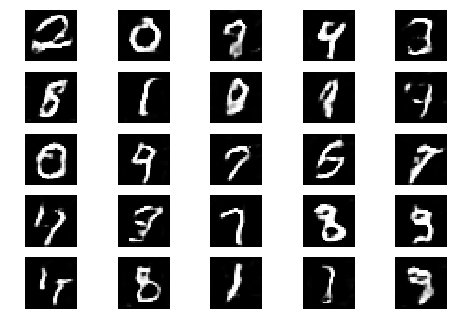

Epoch 2 Batch 1001/1875 [D loss: 0.702330, acc.: 56.25%] [G loss: 1.090056]
Epoch 2 Batch 1002/1875 [D loss: 0.589185, acc.: 59.38%] [G loss: 1.026865]
Epoch 2 Batch 1003/1875 [D loss: 0.627031, acc.: 62.50%] [G loss: 0.908952]
Epoch 2 Batch 1004/1875 [D loss: 0.562928, acc.: 71.88%] [G loss: 0.879809]
Epoch 2 Batch 1005/1875 [D loss: 0.645206, acc.: 62.50%] [G loss: 0.877339]
Epoch 2 Batch 1006/1875 [D loss: 0.650777, acc.: 56.25%] [G loss: 1.230342]
Epoch 2 Batch 1007/1875 [D loss: 0.778982, acc.: 46.88%] [G loss: 1.066216]
Epoch 2 Batch 1008/1875 [D loss: 0.652413, acc.: 59.38%] [G loss: 1.132286]
Epoch 2 Batch 1009/1875 [D loss: 0.621086, acc.: 71.88%] [G loss: 1.010635]
Epoch 2 Batch 1010/1875 [D loss: 0.601464, acc.: 65.62%] [G loss: 0.988292]


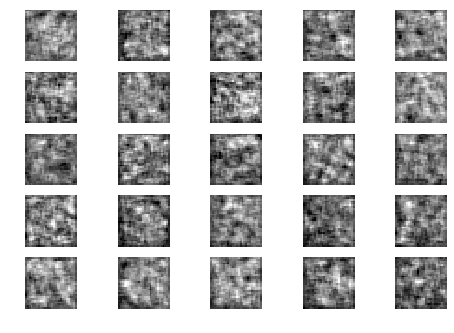

Epoch 2 Batch 1011/1875 [D loss: 0.549939, acc.: 71.88%] [G loss: 1.054375]
Epoch 2 Batch 1012/1875 [D loss: 0.813236, acc.: 46.88%] [G loss: 1.076861]
Epoch 2 Batch 1013/1875 [D loss: 0.733676, acc.: 50.00%] [G loss: 0.992085]
Epoch 2 Batch 1014/1875 [D loss: 0.648241, acc.: 68.75%] [G loss: 1.078847]
Epoch 2 Batch 1015/1875 [D loss: 0.518938, acc.: 78.12%] [G loss: 0.944435]
Epoch 2 Batch 1016/1875 [D loss: 0.750459, acc.: 59.38%] [G loss: 0.919655]
Epoch 2 Batch 1017/1875 [D loss: 0.571005, acc.: 65.62%] [G loss: 1.113478]
Epoch 2 Batch 1018/1875 [D loss: 0.658109, acc.: 56.25%] [G loss: 0.935950]
Epoch 2 Batch 1019/1875 [D loss: 0.712299, acc.: 50.00%] [G loss: 0.965567]
Epoch 2 Batch 1020/1875 [D loss: 0.728985, acc.: 53.12%] [G loss: 1.115238]


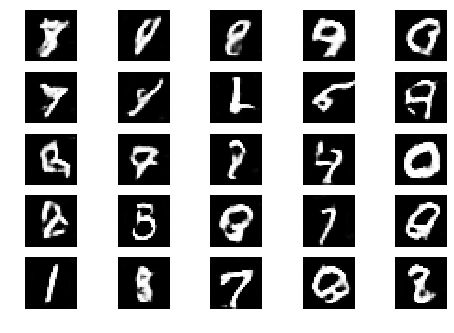

Epoch 2 Batch 1021/1875 [D loss: 0.542617, acc.: 78.12%] [G loss: 1.142891]
Epoch 2 Batch 1022/1875 [D loss: 0.656077, acc.: 65.62%] [G loss: 1.051079]
Epoch 2 Batch 1023/1875 [D loss: 0.576914, acc.: 65.62%] [G loss: 0.995190]
Epoch 2 Batch 1024/1875 [D loss: 0.578724, acc.: 65.62%] [G loss: 0.920570]
Epoch 2 Batch 1025/1875 [D loss: 0.675609, acc.: 62.50%] [G loss: 0.783176]
Epoch 2 Batch 1026/1875 [D loss: 0.716057, acc.: 53.12%] [G loss: 0.849643]
Epoch 2 Batch 1027/1875 [D loss: 0.584326, acc.: 71.88%] [G loss: 0.953165]
Epoch 2 Batch 1028/1875 [D loss: 0.774598, acc.: 43.75%] [G loss: 1.014192]
Epoch 2 Batch 1029/1875 [D loss: 0.606961, acc.: 71.88%] [G loss: 0.894915]
Epoch 2 Batch 1030/1875 [D loss: 0.707559, acc.: 59.38%] [G loss: 0.960751]
Epoch 2 Batch 1031/1875 [D loss: 0.551435, acc.: 75.00%] [G loss: 0.985741]
Epoch 2 Batch 1032/1875 [D loss: 0.886867, acc.: 40.62%] [G loss: 0.812889]
Epoch 2 Batch 1033/1875 [D loss: 0.505259, acc.: 71.88%] [G loss: 1.231063]
Epoch 2 Batc

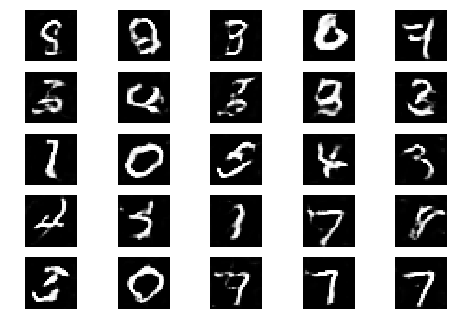

Epoch 2 Batch 1101/1875 [D loss: 0.564558, acc.: 71.88%] [G loss: 0.867285]
Epoch 2 Batch 1102/1875 [D loss: 0.677152, acc.: 53.12%] [G loss: 0.957239]
Epoch 2 Batch 1103/1875 [D loss: 0.853163, acc.: 46.88%] [G loss: 0.911769]
Epoch 2 Batch 1104/1875 [D loss: 0.684657, acc.: 62.50%] [G loss: 1.002012]
Epoch 2 Batch 1105/1875 [D loss: 0.594181, acc.: 68.75%] [G loss: 0.824207]
Epoch 2 Batch 1106/1875 [D loss: 0.606570, acc.: 68.75%] [G loss: 1.161548]
Epoch 2 Batch 1107/1875 [D loss: 0.715472, acc.: 53.12%] [G loss: 0.886830]
Epoch 2 Batch 1108/1875 [D loss: 0.711192, acc.: 56.25%] [G loss: 1.008112]
Epoch 2 Batch 1109/1875 [D loss: 0.658497, acc.: 65.62%] [G loss: 0.947444]
Epoch 2 Batch 1110/1875 [D loss: 0.785520, acc.: 40.62%] [G loss: 0.923424]
Epoch 2 Batch 1111/1875 [D loss: 0.566843, acc.: 68.75%] [G loss: 0.974545]


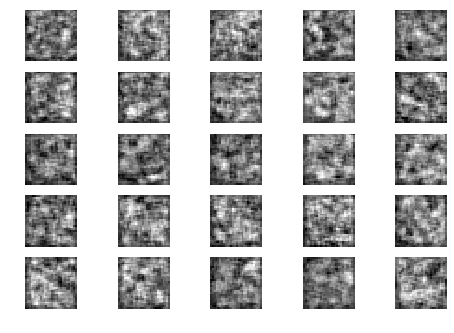

Epoch 2 Batch 1112/1875 [D loss: 0.689492, acc.: 53.12%] [G loss: 0.980942]
Epoch 2 Batch 1113/1875 [D loss: 0.665648, acc.: 59.38%] [G loss: 1.008696]
Epoch 2 Batch 1114/1875 [D loss: 0.598396, acc.: 62.50%] [G loss: 1.213041]
Epoch 2 Batch 1115/1875 [D loss: 0.726607, acc.: 62.50%] [G loss: 0.881150]
Epoch 2 Batch 1116/1875 [D loss: 0.699257, acc.: 59.38%] [G loss: 0.955660]
Epoch 2 Batch 1117/1875 [D loss: 0.723591, acc.: 43.75%] [G loss: 0.939648]
Epoch 2 Batch 1118/1875 [D loss: 0.703672, acc.: 59.38%] [G loss: 1.038289]
Epoch 2 Batch 1119/1875 [D loss: 0.628475, acc.: 68.75%] [G loss: 0.901940]
Epoch 2 Batch 1120/1875 [D loss: 0.652498, acc.: 68.75%] [G loss: 1.153324]
Epoch 2 Batch 1121/1875 [D loss: 0.522103, acc.: 78.12%] [G loss: 0.716882]
Epoch 2 Batch 1122/1875 [D loss: 0.524760, acc.: 71.88%] [G loss: 1.053474]


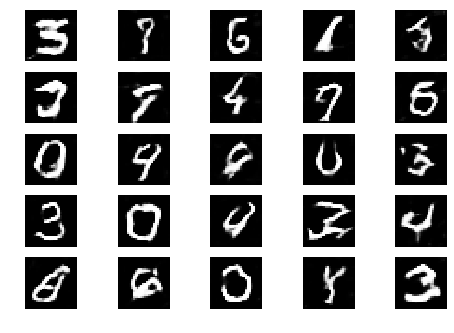

Epoch 2 Batch 1123/1875 [D loss: 0.822697, acc.: 50.00%] [G loss: 0.935801]
Epoch 2 Batch 1124/1875 [D loss: 0.698199, acc.: 50.00%] [G loss: 0.925116]
Epoch 2 Batch 1125/1875 [D loss: 0.615061, acc.: 62.50%] [G loss: 0.973976]
Epoch 2 Batch 1126/1875 [D loss: 0.756375, acc.: 53.12%] [G loss: 0.836313]
Epoch 2 Batch 1127/1875 [D loss: 0.678980, acc.: 56.25%] [G loss: 1.070550]
Epoch 2 Batch 1128/1875 [D loss: 0.542961, acc.: 71.88%] [G loss: 0.988597]
Epoch 2 Batch 1129/1875 [D loss: 0.632780, acc.: 68.75%] [G loss: 1.065849]
Epoch 2 Batch 1130/1875 [D loss: 0.602913, acc.: 65.62%] [G loss: 0.977126]
Epoch 2 Batch 1131/1875 [D loss: 0.689558, acc.: 56.25%] [G loss: 0.954390]
Epoch 2 Batch 1132/1875 [D loss: 0.700267, acc.: 53.12%] [G loss: 1.011811]
Epoch 2 Batch 1133/1875 [D loss: 0.660315, acc.: 56.25%] [G loss: 0.844882]
Epoch 2 Batch 1134/1875 [D loss: 0.593522, acc.: 68.75%] [G loss: 1.033787]
Epoch 2 Batch 1135/1875 [D loss: 0.599970, acc.: 65.62%] [G loss: 0.771531]
Epoch 2 Batc

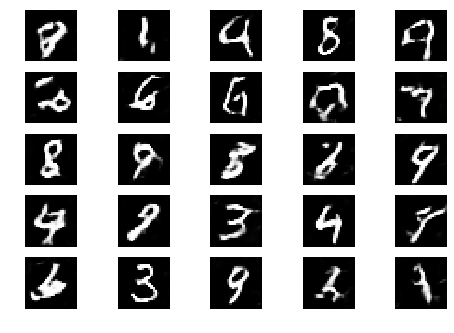

Epoch 2 Batch 1201/1875 [D loss: 0.701834, acc.: 59.38%] [G loss: 0.959035]
Epoch 2 Batch 1202/1875 [D loss: 0.635948, acc.: 62.50%] [G loss: 0.920814]
Epoch 2 Batch 1203/1875 [D loss: 0.526293, acc.: 75.00%] [G loss: 0.924947]
Epoch 2 Batch 1204/1875 [D loss: 0.659521, acc.: 65.62%] [G loss: 1.121596]
Epoch 2 Batch 1205/1875 [D loss: 0.603574, acc.: 75.00%] [G loss: 0.936255]
Epoch 2 Batch 1206/1875 [D loss: 0.750437, acc.: 56.25%] [G loss: 0.961991]
Epoch 2 Batch 1207/1875 [D loss: 0.564870, acc.: 71.88%] [G loss: 0.816406]
Epoch 2 Batch 1208/1875 [D loss: 0.609204, acc.: 65.62%] [G loss: 1.002949]
Epoch 2 Batch 1209/1875 [D loss: 0.751399, acc.: 62.50%] [G loss: 0.997199]
Epoch 2 Batch 1210/1875 [D loss: 0.649193, acc.: 62.50%] [G loss: 0.991114]
Epoch 2 Batch 1211/1875 [D loss: 0.721665, acc.: 53.12%] [G loss: 1.169135]
Epoch 2 Batch 1212/1875 [D loss: 0.620685, acc.: 59.38%] [G loss: 0.837320]


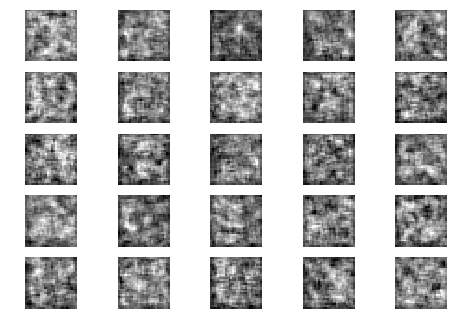

Epoch 2 Batch 1213/1875 [D loss: 0.607046, acc.: 68.75%] [G loss: 0.998147]
Epoch 2 Batch 1214/1875 [D loss: 0.739583, acc.: 53.12%] [G loss: 1.056087]
Epoch 2 Batch 1215/1875 [D loss: 0.592226, acc.: 65.62%] [G loss: 1.007508]
Epoch 2 Batch 1216/1875 [D loss: 0.584378, acc.: 56.25%] [G loss: 0.982842]
Epoch 2 Batch 1217/1875 [D loss: 0.500926, acc.: 81.25%] [G loss: 0.980732]
Epoch 2 Batch 1218/1875 [D loss: 0.671017, acc.: 53.12%] [G loss: 0.963337]
Epoch 2 Batch 1219/1875 [D loss: 0.590200, acc.: 75.00%] [G loss: 0.877989]
Epoch 2 Batch 1220/1875 [D loss: 0.718907, acc.: 56.25%] [G loss: 0.916860]
Epoch 2 Batch 1221/1875 [D loss: 0.571624, acc.: 65.62%] [G loss: 0.940557]
Epoch 2 Batch 1222/1875 [D loss: 0.786169, acc.: 43.75%] [G loss: 0.822069]
Epoch 2 Batch 1223/1875 [D loss: 0.882244, acc.: 34.38%] [G loss: 0.890407]
Epoch 2 Batch 1224/1875 [D loss: 0.652109, acc.: 62.50%] [G loss: 0.975815]


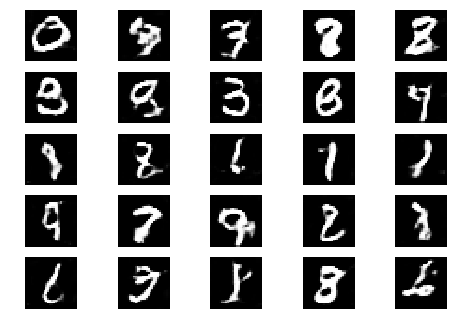

Epoch 2 Batch 1225/1875 [D loss: 0.563878, acc.: 71.88%] [G loss: 1.221777]
Epoch 2 Batch 1226/1875 [D loss: 0.622976, acc.: 59.38%] [G loss: 0.803160]
Epoch 2 Batch 1227/1875 [D loss: 0.572362, acc.: 68.75%] [G loss: 1.162807]
Epoch 2 Batch 1228/1875 [D loss: 0.766523, acc.: 56.25%] [G loss: 0.962129]
Epoch 2 Batch 1229/1875 [D loss: 0.524129, acc.: 84.38%] [G loss: 1.242685]
Epoch 2 Batch 1230/1875 [D loss: 0.707332, acc.: 46.88%] [G loss: 1.073878]
Epoch 2 Batch 1231/1875 [D loss: 0.633009, acc.: 65.62%] [G loss: 1.137695]
Epoch 2 Batch 1232/1875 [D loss: 0.510351, acc.: 87.50%] [G loss: 1.052119]
Epoch 2 Batch 1233/1875 [D loss: 0.667838, acc.: 59.38%] [G loss: 1.213745]
Epoch 2 Batch 1234/1875 [D loss: 0.638473, acc.: 62.50%] [G loss: 0.988617]
Epoch 2 Batch 1235/1875 [D loss: 0.648915, acc.: 62.50%] [G loss: 1.008481]
Epoch 2 Batch 1236/1875 [D loss: 0.590496, acc.: 68.75%] [G loss: 1.062923]
Epoch 2 Batch 1237/1875 [D loss: 0.572911, acc.: 71.88%] [G loss: 1.016379]
Epoch 2 Batc

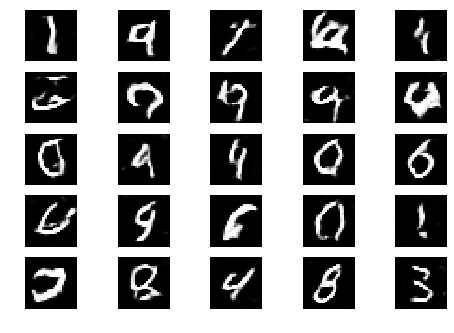

Epoch 2 Batch 1301/1875 [D loss: 0.652600, acc.: 56.25%] [G loss: 0.879396]
Epoch 2 Batch 1302/1875 [D loss: 0.955989, acc.: 31.25%] [G loss: 0.864587]
Epoch 2 Batch 1303/1875 [D loss: 0.571712, acc.: 71.88%] [G loss: 1.192698]
Epoch 2 Batch 1304/1875 [D loss: 0.859071, acc.: 43.75%] [G loss: 1.021728]
Epoch 2 Batch 1305/1875 [D loss: 0.594189, acc.: 59.38%] [G loss: 1.034369]
Epoch 2 Batch 1306/1875 [D loss: 0.700993, acc.: 59.38%] [G loss: 1.007533]
Epoch 2 Batch 1307/1875 [D loss: 0.643843, acc.: 75.00%] [G loss: 0.998194]
Epoch 2 Batch 1308/1875 [D loss: 0.615609, acc.: 59.38%] [G loss: 1.236330]
Epoch 2 Batch 1309/1875 [D loss: 0.609184, acc.: 68.75%] [G loss: 1.005095]
Epoch 2 Batch 1310/1875 [D loss: 0.640713, acc.: 71.88%] [G loss: 1.016332]
Epoch 2 Batch 1311/1875 [D loss: 0.513267, acc.: 78.12%] [G loss: 1.035068]
Epoch 2 Batch 1312/1875 [D loss: 0.618030, acc.: 65.62%] [G loss: 1.003812]
Epoch 2 Batch 1313/1875 [D loss: 0.649752, acc.: 59.38%] [G loss: 0.905827]


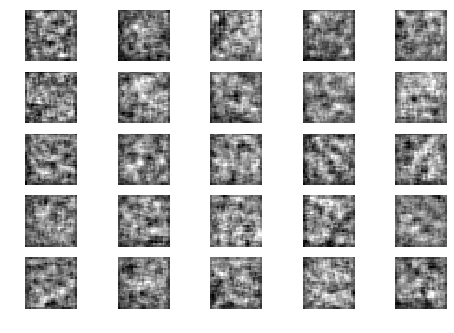

Epoch 2 Batch 1314/1875 [D loss: 0.784531, acc.: 56.25%] [G loss: 0.962258]
Epoch 2 Batch 1315/1875 [D loss: 0.834941, acc.: 43.75%] [G loss: 1.092683]
Epoch 2 Batch 1316/1875 [D loss: 0.605448, acc.: 62.50%] [G loss: 0.872628]
Epoch 2 Batch 1317/1875 [D loss: 0.749955, acc.: 53.12%] [G loss: 0.888994]
Epoch 2 Batch 1318/1875 [D loss: 0.589316, acc.: 68.75%] [G loss: 1.144980]
Epoch 2 Batch 1319/1875 [D loss: 0.597292, acc.: 71.88%] [G loss: 1.088849]
Epoch 2 Batch 1320/1875 [D loss: 0.555658, acc.: 75.00%] [G loss: 0.707242]
Epoch 2 Batch 1321/1875 [D loss: 0.732235, acc.: 53.12%] [G loss: 1.023946]
Epoch 2 Batch 1322/1875 [D loss: 0.595586, acc.: 68.75%] [G loss: 1.089934]
Epoch 2 Batch 1323/1875 [D loss: 0.690997, acc.: 46.88%] [G loss: 0.994503]
Epoch 2 Batch 1324/1875 [D loss: 0.655529, acc.: 62.50%] [G loss: 0.898652]
Epoch 2 Batch 1325/1875 [D loss: 0.688494, acc.: 50.00%] [G loss: 1.166043]
Epoch 2 Batch 1326/1875 [D loss: 0.734434, acc.: 53.12%] [G loss: 1.153906]


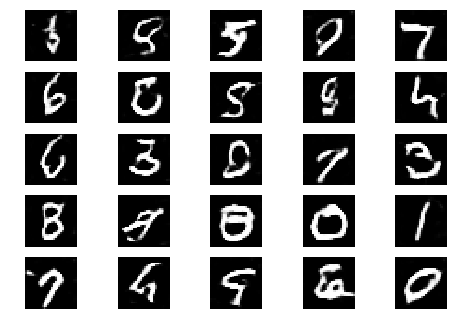

Epoch 2 Batch 1327/1875 [D loss: 0.657019, acc.: 65.62%] [G loss: 1.082668]
Epoch 2 Batch 1328/1875 [D loss: 0.709166, acc.: 59.38%] [G loss: 1.022860]
Epoch 2 Batch 1329/1875 [D loss: 0.530023, acc.: 84.38%] [G loss: 1.146431]
Epoch 2 Batch 1330/1875 [D loss: 0.666434, acc.: 62.50%] [G loss: 1.343279]
Epoch 2 Batch 1331/1875 [D loss: 0.627646, acc.: 56.25%] [G loss: 1.053397]
Epoch 2 Batch 1332/1875 [D loss: 0.569460, acc.: 71.88%] [G loss: 1.007529]
Epoch 2 Batch 1333/1875 [D loss: 0.558846, acc.: 71.88%] [G loss: 0.970735]
Epoch 2 Batch 1334/1875 [D loss: 0.687804, acc.: 59.38%] [G loss: 1.028700]
Epoch 2 Batch 1335/1875 [D loss: 0.672269, acc.: 53.12%] [G loss: 0.965162]
Epoch 2 Batch 1336/1875 [D loss: 0.594408, acc.: 78.12%] [G loss: 1.052730]
Epoch 2 Batch 1337/1875 [D loss: 0.702061, acc.: 50.00%] [G loss: 1.016857]
Epoch 2 Batch 1338/1875 [D loss: 0.801376, acc.: 50.00%] [G loss: 1.200135]
Epoch 2 Batch 1339/1875 [D loss: 0.623345, acc.: 68.75%] [G loss: 1.205407]
Epoch 2 Batc

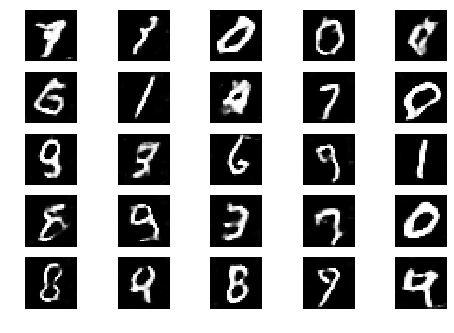

Epoch 2 Batch 1401/1875 [D loss: 0.731946, acc.: 46.88%] [G loss: 1.002550]
Epoch 2 Batch 1402/1875 [D loss: 0.673881, acc.: 59.38%] [G loss: 1.179127]
Epoch 2 Batch 1403/1875 [D loss: 0.533226, acc.: 75.00%] [G loss: 0.999005]
Epoch 2 Batch 1404/1875 [D loss: 0.580688, acc.: 78.12%] [G loss: 1.174389]
Epoch 2 Batch 1405/1875 [D loss: 0.766026, acc.: 43.75%] [G loss: 0.989894]
Epoch 2 Batch 1406/1875 [D loss: 0.652836, acc.: 62.50%] [G loss: 1.136232]
Epoch 2 Batch 1407/1875 [D loss: 0.723106, acc.: 56.25%] [G loss: 1.459690]
Epoch 2 Batch 1408/1875 [D loss: 0.656896, acc.: 68.75%] [G loss: 1.040955]
Epoch 2 Batch 1409/1875 [D loss: 0.685930, acc.: 56.25%] [G loss: 1.053339]
Epoch 2 Batch 1410/1875 [D loss: 0.644835, acc.: 62.50%] [G loss: 1.180773]
Epoch 2 Batch 1411/1875 [D loss: 0.743028, acc.: 53.12%] [G loss: 0.973314]
Epoch 2 Batch 1412/1875 [D loss: 0.739233, acc.: 53.12%] [G loss: 1.020706]
Epoch 2 Batch 1413/1875 [D loss: 0.634998, acc.: 68.75%] [G loss: 1.010649]
Epoch 2 Batc

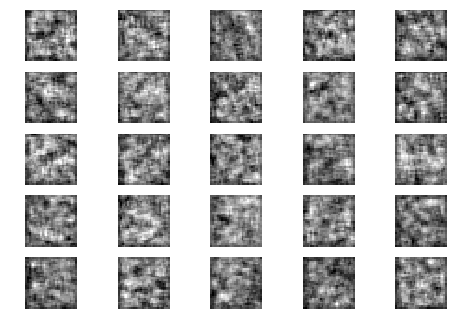

Epoch 2 Batch 1415/1875 [D loss: 0.716479, acc.: 50.00%] [G loss: 0.908490]
Epoch 2 Batch 1416/1875 [D loss: 0.543409, acc.: 68.75%] [G loss: 1.096965]
Epoch 2 Batch 1417/1875 [D loss: 0.710787, acc.: 68.75%] [G loss: 1.054749]
Epoch 2 Batch 1418/1875 [D loss: 0.847484, acc.: 43.75%] [G loss: 1.000796]
Epoch 2 Batch 1419/1875 [D loss: 0.593585, acc.: 59.38%] [G loss: 0.880824]
Epoch 2 Batch 1420/1875 [D loss: 0.664473, acc.: 59.38%] [G loss: 1.011320]
Epoch 2 Batch 1421/1875 [D loss: 0.760608, acc.: 59.38%] [G loss: 0.988562]
Epoch 2 Batch 1422/1875 [D loss: 0.789949, acc.: 46.88%] [G loss: 1.165685]
Epoch 2 Batch 1423/1875 [D loss: 0.522840, acc.: 71.88%] [G loss: 1.012815]
Epoch 2 Batch 1424/1875 [D loss: 0.803035, acc.: 59.38%] [G loss: 1.122382]
Epoch 2 Batch 1425/1875 [D loss: 0.637917, acc.: 65.62%] [G loss: 0.952366]
Epoch 2 Batch 1426/1875 [D loss: 0.753624, acc.: 53.12%] [G loss: 1.003642]
Epoch 2 Batch 1427/1875 [D loss: 0.576838, acc.: 65.62%] [G loss: 1.095338]
Epoch 2 Batc

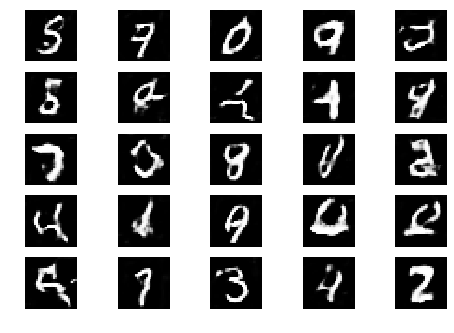

Epoch 2 Batch 1429/1875 [D loss: 0.733580, acc.: 53.12%] [G loss: 1.113914]
Epoch 2 Batch 1430/1875 [D loss: 0.577776, acc.: 75.00%] [G loss: 1.112628]
Epoch 2 Batch 1431/1875 [D loss: 0.719376, acc.: 53.12%] [G loss: 1.069588]
Epoch 2 Batch 1432/1875 [D loss: 0.719488, acc.: 53.12%] [G loss: 1.023169]
Epoch 2 Batch 1433/1875 [D loss: 0.695534, acc.: 59.38%] [G loss: 1.172067]
Epoch 2 Batch 1434/1875 [D loss: 0.640249, acc.: 71.88%] [G loss: 1.004011]
Epoch 2 Batch 1435/1875 [D loss: 0.619039, acc.: 62.50%] [G loss: 0.964320]
Epoch 2 Batch 1436/1875 [D loss: 0.598588, acc.: 65.62%] [G loss: 1.069725]
Epoch 2 Batch 1437/1875 [D loss: 0.595662, acc.: 65.62%] [G loss: 0.920408]
Epoch 2 Batch 1438/1875 [D loss: 0.681099, acc.: 56.25%] [G loss: 0.983296]
Epoch 2 Batch 1439/1875 [D loss: 0.705693, acc.: 53.12%] [G loss: 0.891462]
Epoch 2 Batch 1440/1875 [D loss: 0.718176, acc.: 53.12%] [G loss: 0.912210]
Epoch 2 Batch 1441/1875 [D loss: 0.600840, acc.: 68.75%] [G loss: 0.986765]
Epoch 2 Batc

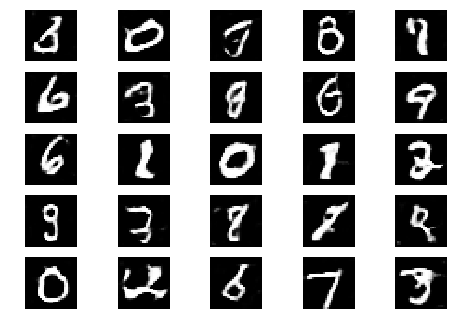

Epoch 2 Batch 1501/1875 [D loss: 0.745859, acc.: 59.38%] [G loss: 0.928409]
Epoch 2 Batch 1502/1875 [D loss: 0.636068, acc.: 68.75%] [G loss: 1.050483]
Epoch 2 Batch 1503/1875 [D loss: 0.755533, acc.: 53.12%] [G loss: 1.083217]
Epoch 2 Batch 1504/1875 [D loss: 0.611139, acc.: 71.88%] [G loss: 0.905178]
Epoch 2 Batch 1505/1875 [D loss: 0.624595, acc.: 59.38%] [G loss: 0.852581]
Epoch 2 Batch 1506/1875 [D loss: 0.876441, acc.: 37.50%] [G loss: 0.752031]
Epoch 2 Batch 1507/1875 [D loss: 0.659222, acc.: 59.38%] [G loss: 0.950804]
Epoch 2 Batch 1508/1875 [D loss: 0.757689, acc.: 50.00%] [G loss: 0.952636]
Epoch 2 Batch 1509/1875 [D loss: 0.513964, acc.: 84.38%] [G loss: 1.177377]
Epoch 2 Batch 1510/1875 [D loss: 0.811382, acc.: 43.75%] [G loss: 0.991436]
Epoch 2 Batch 1511/1875 [D loss: 0.599598, acc.: 62.50%] [G loss: 1.205570]
Epoch 2 Batch 1512/1875 [D loss: 0.732407, acc.: 59.38%] [G loss: 1.007097]
Epoch 2 Batch 1513/1875 [D loss: 0.657945, acc.: 62.50%] [G loss: 0.937658]
Epoch 2 Batc

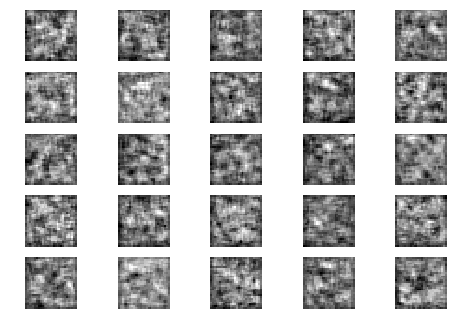

Epoch 2 Batch 1516/1875 [D loss: 0.713596, acc.: 56.25%] [G loss: 0.922692]
Epoch 2 Batch 1517/1875 [D loss: 0.635447, acc.: 65.62%] [G loss: 0.973564]
Epoch 2 Batch 1518/1875 [D loss: 0.563440, acc.: 71.88%] [G loss: 1.212357]
Epoch 2 Batch 1519/1875 [D loss: 0.634513, acc.: 65.62%] [G loss: 1.030850]
Epoch 2 Batch 1520/1875 [D loss: 0.743660, acc.: 50.00%] [G loss: 1.014153]
Epoch 2 Batch 1521/1875 [D loss: 0.705822, acc.: 43.75%] [G loss: 0.846232]
Epoch 2 Batch 1522/1875 [D loss: 0.738154, acc.: 59.38%] [G loss: 0.978955]
Epoch 2 Batch 1523/1875 [D loss: 0.620531, acc.: 71.88%] [G loss: 1.135201]
Epoch 2 Batch 1524/1875 [D loss: 0.696322, acc.: 62.50%] [G loss: 1.113533]
Epoch 2 Batch 1525/1875 [D loss: 0.667963, acc.: 59.38%] [G loss: 0.839154]
Epoch 2 Batch 1526/1875 [D loss: 0.498858, acc.: 87.50%] [G loss: 0.845116]
Epoch 2 Batch 1527/1875 [D loss: 0.660556, acc.: 71.88%] [G loss: 0.829795]
Epoch 2 Batch 1528/1875 [D loss: 0.729808, acc.: 46.88%] [G loss: 0.887710]
Epoch 2 Batc

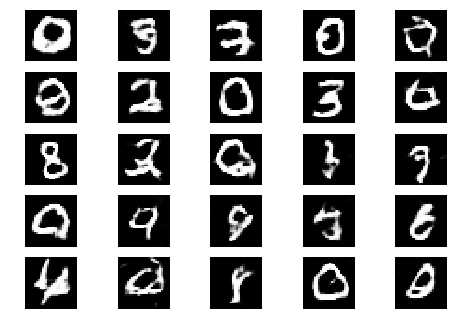

Epoch 2 Batch 1531/1875 [D loss: 0.621164, acc.: 56.25%] [G loss: 0.912228]
Epoch 2 Batch 1532/1875 [D loss: 0.663126, acc.: 59.38%] [G loss: 0.841092]
Epoch 2 Batch 1533/1875 [D loss: 0.682706, acc.: 50.00%] [G loss: 0.857223]
Epoch 2 Batch 1534/1875 [D loss: 0.639115, acc.: 65.62%] [G loss: 0.821875]
Epoch 2 Batch 1535/1875 [D loss: 0.823659, acc.: 37.50%] [G loss: 1.003092]
Epoch 2 Batch 1536/1875 [D loss: 0.738582, acc.: 53.12%] [G loss: 0.974701]
Epoch 2 Batch 1537/1875 [D loss: 0.642056, acc.: 62.50%] [G loss: 1.052467]
Epoch 2 Batch 1538/1875 [D loss: 0.677580, acc.: 59.38%] [G loss: 0.893481]
Epoch 2 Batch 1539/1875 [D loss: 0.656507, acc.: 56.25%] [G loss: 1.117788]
Epoch 2 Batch 1540/1875 [D loss: 0.475425, acc.: 87.50%] [G loss: 0.864529]
Epoch 2 Batch 1541/1875 [D loss: 0.414208, acc.: 87.50%] [G loss: 1.009352]
Epoch 2 Batch 1542/1875 [D loss: 0.827289, acc.: 50.00%] [G loss: 0.966199]
Epoch 2 Batch 1543/1875 [D loss: 0.641523, acc.: 65.62%] [G loss: 1.113390]
Epoch 2 Batc

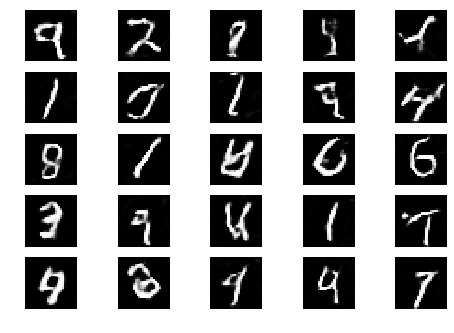

Epoch 2 Batch 1601/1875 [D loss: 0.677615, acc.: 59.38%] [G loss: 0.911316]
Epoch 2 Batch 1602/1875 [D loss: 0.674902, acc.: 59.38%] [G loss: 1.151139]
Epoch 2 Batch 1603/1875 [D loss: 0.584999, acc.: 75.00%] [G loss: 1.062639]
Epoch 2 Batch 1604/1875 [D loss: 0.606905, acc.: 65.62%] [G loss: 0.907016]
Epoch 2 Batch 1605/1875 [D loss: 0.715456, acc.: 43.75%] [G loss: 1.144721]
Epoch 2 Batch 1606/1875 [D loss: 0.702753, acc.: 50.00%] [G loss: 0.931011]
Epoch 2 Batch 1607/1875 [D loss: 0.740325, acc.: 53.12%] [G loss: 1.017583]
Epoch 2 Batch 1608/1875 [D loss: 0.638368, acc.: 56.25%] [G loss: 1.039373]
Epoch 2 Batch 1609/1875 [D loss: 0.686724, acc.: 53.12%] [G loss: 1.030236]
Epoch 2 Batch 1610/1875 [D loss: 0.639339, acc.: 65.62%] [G loss: 1.107855]
Epoch 2 Batch 1611/1875 [D loss: 0.658139, acc.: 53.12%] [G loss: 0.907329]
Epoch 2 Batch 1612/1875 [D loss: 0.736163, acc.: 50.00%] [G loss: 0.798515]
Epoch 2 Batch 1613/1875 [D loss: 0.776699, acc.: 50.00%] [G loss: 0.849310]
Epoch 2 Batc

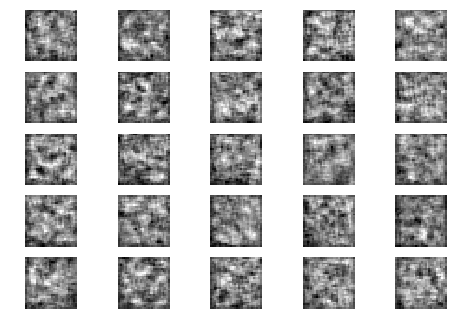

Epoch 2 Batch 1617/1875 [D loss: 0.502891, acc.: 78.12%] [G loss: 1.160967]
Epoch 2 Batch 1618/1875 [D loss: 0.619759, acc.: 59.38%] [G loss: 1.133022]
Epoch 2 Batch 1619/1875 [D loss: 0.702736, acc.: 62.50%] [G loss: 1.093439]
Epoch 2 Batch 1620/1875 [D loss: 0.583013, acc.: 71.88%] [G loss: 1.031998]
Epoch 2 Batch 1621/1875 [D loss: 0.665726, acc.: 56.25%] [G loss: 0.957948]
Epoch 2 Batch 1622/1875 [D loss: 0.592195, acc.: 68.75%] [G loss: 0.901558]
Epoch 2 Batch 1623/1875 [D loss: 0.774530, acc.: 40.62%] [G loss: 0.792815]
Epoch 2 Batch 1624/1875 [D loss: 0.838084, acc.: 50.00%] [G loss: 0.916755]
Epoch 2 Batch 1625/1875 [D loss: 0.617301, acc.: 56.25%] [G loss: 1.026330]
Epoch 2 Batch 1626/1875 [D loss: 0.721390, acc.: 59.38%] [G loss: 0.744344]
Epoch 2 Batch 1627/1875 [D loss: 0.742510, acc.: 50.00%] [G loss: 0.957873]
Epoch 2 Batch 1628/1875 [D loss: 0.578048, acc.: 68.75%] [G loss: 1.000300]
Epoch 2 Batch 1629/1875 [D loss: 0.528800, acc.: 68.75%] [G loss: 1.056034]
Epoch 2 Batc

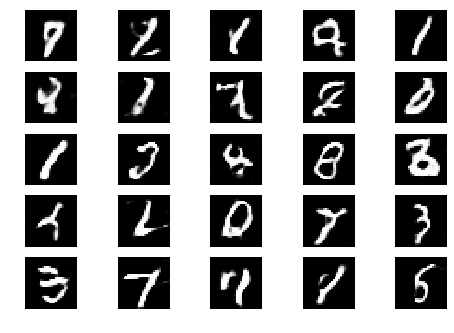

Epoch 2 Batch 1633/1875 [D loss: 0.543001, acc.: 78.12%] [G loss: 1.004335]
Epoch 2 Batch 1634/1875 [D loss: 0.704892, acc.: 56.25%] [G loss: 1.082990]
Epoch 2 Batch 1635/1875 [D loss: 0.594660, acc.: 68.75%] [G loss: 0.965015]
Epoch 2 Batch 1636/1875 [D loss: 0.576719, acc.: 71.88%] [G loss: 0.870192]
Epoch 2 Batch 1637/1875 [D loss: 0.638261, acc.: 68.75%] [G loss: 0.882598]
Epoch 2 Batch 1638/1875 [D loss: 0.766324, acc.: 43.75%] [G loss: 0.780945]
Epoch 2 Batch 1639/1875 [D loss: 0.876194, acc.: 34.38%] [G loss: 0.985126]
Epoch 2 Batch 1640/1875 [D loss: 0.719317, acc.: 56.25%] [G loss: 1.068088]
Epoch 2 Batch 1641/1875 [D loss: 0.610217, acc.: 62.50%] [G loss: 0.899186]
Epoch 2 Batch 1642/1875 [D loss: 0.679444, acc.: 68.75%] [G loss: 0.952058]
Epoch 2 Batch 1643/1875 [D loss: 0.709206, acc.: 56.25%] [G loss: 0.949655]
Epoch 2 Batch 1644/1875 [D loss: 0.650439, acc.: 59.38%] [G loss: 0.837666]
Epoch 2 Batch 1645/1875 [D loss: 0.591050, acc.: 75.00%] [G loss: 0.805536]
Epoch 2 Batc

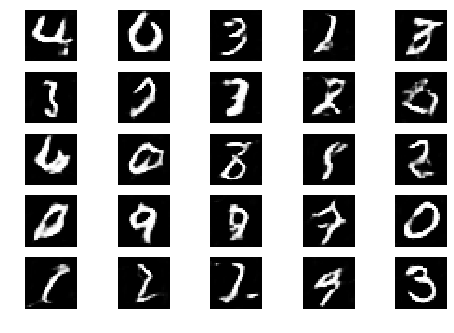

Epoch 2 Batch 1701/1875 [D loss: 0.636345, acc.: 59.38%] [G loss: 1.066200]
Epoch 2 Batch 1702/1875 [D loss: 0.814078, acc.: 40.62%] [G loss: 0.943305]
Epoch 2 Batch 1703/1875 [D loss: 0.737662, acc.: 53.12%] [G loss: 0.920308]
Epoch 2 Batch 1704/1875 [D loss: 0.615073, acc.: 59.38%] [G loss: 1.022988]
Epoch 2 Batch 1705/1875 [D loss: 0.597422, acc.: 68.75%] [G loss: 1.053521]
Epoch 2 Batch 1706/1875 [D loss: 0.572683, acc.: 71.88%] [G loss: 0.937768]
Epoch 2 Batch 1707/1875 [D loss: 0.564697, acc.: 65.62%] [G loss: 0.688902]
Epoch 2 Batch 1708/1875 [D loss: 0.779818, acc.: 53.12%] [G loss: 1.058325]
Epoch 2 Batch 1709/1875 [D loss: 0.601093, acc.: 75.00%] [G loss: 0.979222]
Epoch 2 Batch 1710/1875 [D loss: 0.627096, acc.: 71.88%] [G loss: 0.788758]
Epoch 2 Batch 1711/1875 [D loss: 0.670045, acc.: 62.50%] [G loss: 0.850858]
Epoch 2 Batch 1712/1875 [D loss: 0.631086, acc.: 62.50%] [G loss: 0.774215]
Epoch 2 Batch 1713/1875 [D loss: 0.669853, acc.: 50.00%] [G loss: 0.778597]
Epoch 2 Batc

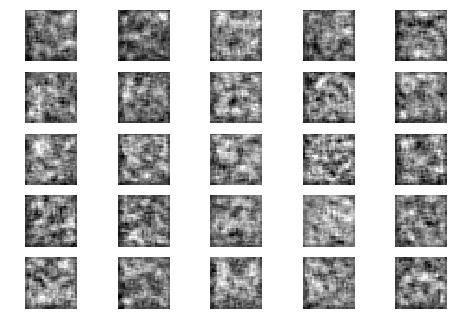

Epoch 2 Batch 1718/1875 [D loss: 0.773206, acc.: 46.88%] [G loss: 1.041243]
Epoch 2 Batch 1719/1875 [D loss: 0.500004, acc.: 71.88%] [G loss: 1.062681]
Epoch 2 Batch 1720/1875 [D loss: 0.681576, acc.: 59.38%] [G loss: 0.861585]
Epoch 2 Batch 1721/1875 [D loss: 0.720495, acc.: 59.38%] [G loss: 0.800242]
Epoch 2 Batch 1722/1875 [D loss: 0.763930, acc.: 50.00%] [G loss: 1.103819]
Epoch 2 Batch 1723/1875 [D loss: 0.556917, acc.: 75.00%] [G loss: 1.210574]
Epoch 2 Batch 1724/1875 [D loss: 0.584324, acc.: 65.62%] [G loss: 1.046394]
Epoch 2 Batch 1725/1875 [D loss: 0.726779, acc.: 56.25%] [G loss: 0.926858]
Epoch 2 Batch 1726/1875 [D loss: 0.571006, acc.: 68.75%] [G loss: 1.003579]
Epoch 2 Batch 1727/1875 [D loss: 0.611467, acc.: 75.00%] [G loss: 1.213129]
Epoch 2 Batch 1728/1875 [D loss: 0.620528, acc.: 62.50%] [G loss: 0.850154]
Epoch 2 Batch 1729/1875 [D loss: 0.531116, acc.: 75.00%] [G loss: 1.020376]
Epoch 2 Batch 1730/1875 [D loss: 0.727326, acc.: 53.12%] [G loss: 0.913821]
Epoch 2 Batc

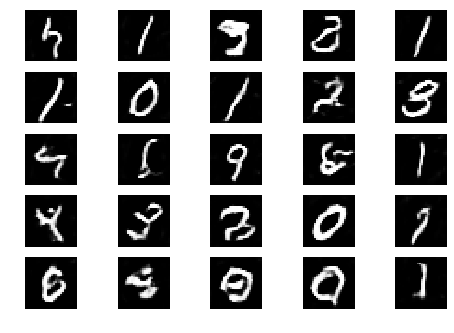

Epoch 2 Batch 1735/1875 [D loss: 0.640199, acc.: 65.62%] [G loss: 0.914369]
Epoch 2 Batch 1736/1875 [D loss: 0.724016, acc.: 43.75%] [G loss: 0.870310]
Epoch 2 Batch 1737/1875 [D loss: 0.714619, acc.: 62.50%] [G loss: 0.815098]
Epoch 2 Batch 1738/1875 [D loss: 0.803475, acc.: 53.12%] [G loss: 0.973623]
Epoch 2 Batch 1739/1875 [D loss: 0.595454, acc.: 65.62%] [G loss: 1.001297]
Epoch 2 Batch 1740/1875 [D loss: 0.673819, acc.: 62.50%] [G loss: 1.067136]
Epoch 2 Batch 1741/1875 [D loss: 0.625259, acc.: 71.88%] [G loss: 1.101833]
Epoch 2 Batch 1742/1875 [D loss: 0.683039, acc.: 59.38%] [G loss: 1.117073]
Epoch 2 Batch 1743/1875 [D loss: 0.522173, acc.: 81.25%] [G loss: 0.933976]
Epoch 2 Batch 1744/1875 [D loss: 0.580104, acc.: 62.50%] [G loss: 0.853512]
Epoch 2 Batch 1745/1875 [D loss: 0.663886, acc.: 59.38%] [G loss: 0.979387]
Epoch 2 Batch 1746/1875 [D loss: 0.551085, acc.: 78.12%] [G loss: 0.928043]
Epoch 2 Batch 1747/1875 [D loss: 0.657458, acc.: 59.38%] [G loss: 0.817449]
Epoch 2 Batc

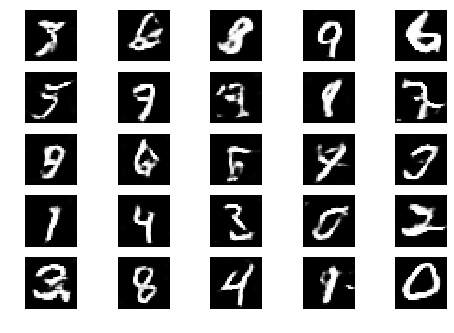

Epoch 2 Batch 1801/1875 [D loss: 0.582592, acc.: 75.00%] [G loss: 0.890261]
Epoch 2 Batch 1802/1875 [D loss: 0.655682, acc.: 62.50%] [G loss: 1.095730]
Epoch 2 Batch 1803/1875 [D loss: 0.705323, acc.: 53.12%] [G loss: 0.965631]
Epoch 2 Batch 1804/1875 [D loss: 0.716014, acc.: 50.00%] [G loss: 1.151719]
Epoch 2 Batch 1805/1875 [D loss: 0.650130, acc.: 56.25%] [G loss: 1.207130]
Epoch 2 Batch 1806/1875 [D loss: 0.542985, acc.: 75.00%] [G loss: 1.157045]
Epoch 2 Batch 1807/1875 [D loss: 0.711575, acc.: 50.00%] [G loss: 1.019372]
Epoch 2 Batch 1808/1875 [D loss: 0.533761, acc.: 78.12%] [G loss: 1.163382]
Epoch 2 Batch 1809/1875 [D loss: 0.548979, acc.: 78.12%] [G loss: 0.886218]
Epoch 2 Batch 1810/1875 [D loss: 0.722724, acc.: 50.00%] [G loss: 0.871516]
Epoch 2 Batch 1811/1875 [D loss: 0.541175, acc.: 84.38%] [G loss: 1.077416]
Epoch 2 Batch 1812/1875 [D loss: 0.620909, acc.: 65.62%] [G loss: 0.957515]
Epoch 2 Batch 1813/1875 [D loss: 0.725411, acc.: 59.38%] [G loss: 1.065888]
Epoch 2 Batc

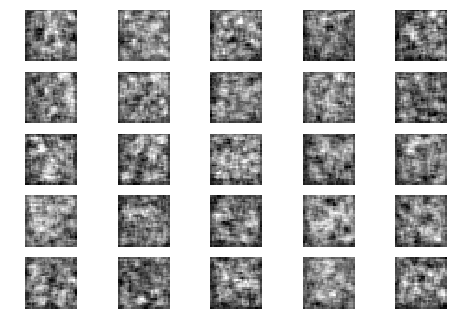

Epoch 2 Batch 1819/1875 [D loss: 0.777802, acc.: 46.88%] [G loss: 0.914006]
Epoch 2 Batch 1820/1875 [D loss: 0.672552, acc.: 53.12%] [G loss: 1.026079]
Epoch 2 Batch 1821/1875 [D loss: 0.585217, acc.: 75.00%] [G loss: 0.998126]
Epoch 2 Batch 1822/1875 [D loss: 0.641918, acc.: 62.50%] [G loss: 0.968889]
Epoch 2 Batch 1823/1875 [D loss: 0.677842, acc.: 56.25%] [G loss: 0.966189]
Epoch 2 Batch 1824/1875 [D loss: 0.817391, acc.: 53.12%] [G loss: 1.131144]
Epoch 2 Batch 1825/1875 [D loss: 0.688932, acc.: 65.62%] [G loss: 0.987579]
Epoch 2 Batch 1826/1875 [D loss: 0.673122, acc.: 59.38%] [G loss: 1.036288]
Epoch 2 Batch 1827/1875 [D loss: 0.702294, acc.: 56.25%] [G loss: 0.858009]
Epoch 2 Batch 1828/1875 [D loss: 0.679981, acc.: 53.12%] [G loss: 0.939027]
Epoch 2 Batch 1829/1875 [D loss: 0.640525, acc.: 65.62%] [G loss: 1.011599]
Epoch 2 Batch 1830/1875 [D loss: 0.717807, acc.: 50.00%] [G loss: 1.077804]
Epoch 2 Batch 1831/1875 [D loss: 0.600655, acc.: 65.62%] [G loss: 0.843344]
Epoch 2 Batc

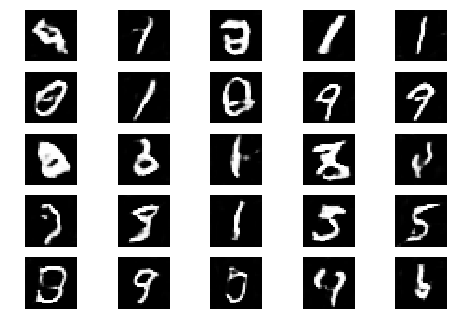

Epoch 2 Batch 1837/1875 [D loss: 0.560552, acc.: 78.12%] [G loss: 0.993843]
Epoch 2 Batch 1838/1875 [D loss: 0.640177, acc.: 62.50%] [G loss: 0.999175]
Epoch 2 Batch 1839/1875 [D loss: 0.656791, acc.: 65.62%] [G loss: 0.974568]
Epoch 2 Batch 1840/1875 [D loss: 0.627205, acc.: 62.50%] [G loss: 0.830317]
Epoch 2 Batch 1841/1875 [D loss: 0.749743, acc.: 40.62%] [G loss: 0.990062]
Epoch 2 Batch 1842/1875 [D loss: 0.791670, acc.: 43.75%] [G loss: 0.910395]
Epoch 2 Batch 1843/1875 [D loss: 0.746418, acc.: 62.50%] [G loss: 0.842708]
Epoch 2 Batch 1844/1875 [D loss: 0.678347, acc.: 65.62%] [G loss: 0.940900]
Epoch 2 Batch 1845/1875 [D loss: 0.641407, acc.: 78.12%] [G loss: 0.996319]
Epoch 2 Batch 1846/1875 [D loss: 0.728412, acc.: 50.00%] [G loss: 0.921215]
Epoch 2 Batch 1847/1875 [D loss: 0.614724, acc.: 75.00%] [G loss: 0.820708]
Epoch 2 Batch 1848/1875 [D loss: 0.728966, acc.: 56.25%] [G loss: 0.916481]
Epoch 2 Batch 1849/1875 [D loss: 0.512544, acc.: 81.25%] [G loss: 0.857081]
Epoch 2 Batc

In [18]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
!rm -rf generatorTrained1.h5

generator1.save('generatorTrained1.h5')


In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generatorTrainedepoch2.h5')


In [0]:
generator1 = generator1.load_weights('generatorTrainedepoch2.h5')

In [0]:
generator2 = generator2.load_weights('generatorTrainedepoch2.h5')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
##files.download('generator1.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

